<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Consumption needs of buildings - P4</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">| Analysis notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
import io
import gc
import ast
import datetime
import itertools
import operator
import math
from math import prod
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.decomposition import PCA

from functions import *

%matplotlib inline
sns.set_theme(style="darkgrid")

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [2]:
def df_analysis(df, name_df, *args, **kwargs):
    """
    Method used to analyze on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        
        *args, **kwargs:
        -----------------
            columns (list): Dataframe keys in list format
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    columns = kwargs.get("columns", None)
    type_analysis = kwargs.get("type_analysis", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        if columns is not None:
            print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        if type_analysis == "summarized":
            print("\n")
        
        if type_analysis is None or type_analysis != "summarized":
            pd.set_option("display.max_rows", None) # show full of showing rows
            pd.set_option("display.max_columns", None) # show full of showing cols
            pd.set_option("display.max_colwidth", None) # show full width of showing cols
            pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    
            
            if type_analysis is None or type_analysis != "complete":
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            elif type_analysis == "complete":
                df_resume["unique"] = list(df.nunique())
                df_desc = pd.DataFrame(df.describe().T).reset_index()
                df_desc = df_desc.rename(columns={"index": "name"})
                df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
                df_resume = df_resume[ORDERING_COMPLETE]
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
                
            display(df_resume.sort_values("records", ascending=False))
            
            pd.reset_option("display.max_rows") # reset max of showing rows
            pd.reset_option("display.max_columns") # reset max of showing cols
            pd.reset_option("display.max_colwidth") # reset width of showing cols
            pd.reset_option("display.float_format") # reset show full content in cell
            
        # deleting dataframe to free memory
        if type_analysis == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()


def comparing_columns_df():
    """
    Method used to identify columns that do not match between datasets

    Returns:
    -----------------
        df (pandas.DataFrame): Dataframe with columns that do not match
    """

    LIST_COL, LIST_ORIGIN = ([] for i in range(2))

    for col in data_2015.columns:
        if col not in list(data_2016.columns):
            LIST_COL.append(col)
            LIST_ORIGIN.append("data_2015")

    for col in data_2016.columns:
        if col not in list(data_2015.columns):
            LIST_COL.append(col)
            LIST_ORIGIN.append("data_2016")

    df = pd.DataFrame({
        "column": LIST_COL,
        "origin": LIST_ORIGIN
    })
    
    display(df.sort_values("column"))
    
    return df


def types_different():
    """
    Method used to identify the same columns with different dtypes

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    COLS_2015, COLS_2016, LIST_COL_DIFFERENT, LIST_DTYPE_2015, LIST_DTYPE_2016 = [[] for i in range(5)]
    
    for col in data_2015.columns:
        if col not in list(df_columns_not_matches.loc[df_columns_not_matches["origin"]=="data_2015", "column"]):         
            COLS_2015.append(col)
    for col in data_2016.columns:
        if col not in list(df_columns_not_matches.loc[df_columns_not_matches["origin"]=="data_2016", "column"]):
            COLS_2016.append(col)
    
    for col_2015, col_2016 in zip(COLS_2015, COLS_2016):
        if data_2015[col_2015].dtype != data_2016[col_2016].dtype:
            LIST_COL_DIFFERENT.append(col_2015)
            LIST_DTYPE_2015.append(str(data_2015[col_2015].dtype))
            LIST_DTYPE_2016.append(str(data_2016[col_2016].dtype))
            
    df_types_different = pd.DataFrame({
                            "column": LIST_COL_DIFFERENT,
                            "2015": LIST_DTYPE_2015,
                            "2016": LIST_DTYPE_2016
                        })
    
    return display(df_types_different.sort_values("column"))
            
            
def normality_test(df):
    """
    Method used to make the normality test.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    list_test = {
        "Shapiro-Wilk":stats.shapiro, "D’Agostino’s K^2":stats.normaltest,
        "Kolmogorov-Smirnov":stats.kstest
    }
    
    
    alpha = 0.05
    fail_to_reject_H = "Sample looks Gaussian (fail to reject H0)"
    reject_H = "Sample does not look Gaussian (reject H0)"
    
    variable, test_name, result, hypothesis = [[] for i in range(4)]
    
    for key, value in list_test.items():
    
        for col in df.columns:
            
            if df[col].dtypes == "float64" or df[col].dtypes == "int64":
                variable.append(col)
                test_name.append(key)
                
                if key == "Kolmogorov-Smirnov":
                    stat, p_value = value(df[col], cdf="norm")
                else:
                    stat, p_value = value(df[col])
                    
                result.append("Statistics=%.3f, p-value=%.3f" % (stat, p_value))
                hypothesis.append(fail_to_reject_H.translate(SUB)) if p_value > alpha else hypothesis.append(reject_H.translate(SUB))
                
    df_normality_test = pd.DataFrame({
                            "variable": variable,
                            "normality test": test_name, 
                            "result": result,
                            "hypothesis": hypothesis})
    
    display(df_normality_test)
    

class GroupImputer(BaseEstimator, TransformerMixin):
    """ 
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters:
    -----------------  
        group_cols (list) : List of columns used for calculating the aggregated value 
        strategy (str) : The strategy to be used for remplacement, can be one of ["mean", "median", "mode"]
        
    Returns:
    -----------------
        X (array-like) : The array with imputed values in the target column
   """    
    
    def __init__(self, group_cols, target, strategy="mean"):
        
        assert strategy in ["mean", "median"], "Unrecognized value for metric, should be mean/median"
        assert type(group_cols) == list, "group_cols should be a list of columns"
        assert type(target) == list, "target should be a string"
        
        self.group_cols = group_cols
        self.target = target
        self.strategy = strategy
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, "There are missing values in group_cols"
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.strategy) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, "impute_map_")
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
        
        return X.values
    

def highlight_max(data, color="yellow"):
    """ 
    highlight the maximum in a Series or DataFrame
    
    Parameters:
    -----------------  
        data (pandas.DataFrame): Dataset to analyze
        color (str) : color to highlight into the dataset
        
    Returns:
    -----------------
        data (pandas.DataFrame): Dataset analyzed
   """  
    
    #attr = 'background-color: {}'.format(color) + 'color: black'
    attr = "background-color: yellow; color: black"
    
    #remove % and cast to float
    data = data.replace("%","", regex=True).astype(float)
    
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else "" for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        
        return pd.DataFrame(np.where(is_max, attr, ""),
                            index=data.index, columns=data.columns)

    
def df_imputations(training_df, test_df, imputation, scaler):
    """
    Method used for making imputations ("SimpleImputer", "KNNImputer", ""IterativeImputer"")

    Parameters:
    -----------------
        training_df : pandas.DataFrame
        Training dataset.
        
        test_df : pandas.DataFrame
        Dataset to impute.
        
        imputation : str
        Imputation's method.
        
        scaler : obj
        Object StandardScaler().
        
    Returns:
    -----------------
        df_to_impute : pandas.DataFrame
        Dataset imputed.
        
    """
    
    # Initializing the imputer
    if imputation == "SimpleImputer":
        impute = SimpleImputer(missing_values=np.nan, strategy="mean")
    elif imputation == "KNNImputer":
        impute = KNNImputer()
    elif imputation == "IterativeImputer":
        impute = IterativeImputer(estimator=BayesianRidge(), 
                                  imputation_order="ascending", 
                                  initial_strategy="mean")
        
    # Making the imputation fit() in train set
    impute.fit(training_df)
    
    # Making the imputation transform() in test set
    temp_imputed = impute.transform(test_df)
    
    # Rebuilding the dataset as original 
    df_imputed = pd.DataFrame(temp_imputed, index=test_df.index, columns=test_df.columns)
    
    # Desnormalizing and formatting data to DataFrame
    df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), index=df_imputed.index, columns=df_imputed.columns)
    
    return df_imputed

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can see the dataset <b>metadata</b> to know all features
    
    <ul style="list-style-type: square;">
        <li><b>2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m</b></li>
        <li><b>2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy</b></li>
    </ul>  
    
    On the other hand, we get the means of <b>Energy Star Score</b>
    <ul style="list-style-type: square;">
        <li><b>Energy Star Score: https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results</b></li>
    </ul>  
</div>

In [3]:
data_2015 = pd.read_csv(r"datasets\2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv(r"datasets\2016-building-energy-benchmarking.csv")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Initial analysis</h3>
</div>

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

In [4]:
df_analysis(data_2015, "data_2015")


Analysis of data_2015 dataset
--------------------------------------------------------------------
- Dataset shape:                  3340 rows and 47 columns
- Total of NaN values:            26512
- Percentage of NaN:              16.89 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,3340,0,0.00000
9,YearBuilt,int64,3340,0,0.00000
40,ComplianceStatus,object,3340,0,0.00000
1,DataYear,int64,3340,0,0.00000
14,PropertyGFABuilding(s),int64,3340,0,0.00000
13,PropertyGFAParking,int64,3340,0,0.00000
12,PropertyGFATotal,int64,3340,0,0.00000
10,NumberofBuildings,int64,3340,0,0.00000
46,Zip Codes,int64,3340,0,0.00000
8,Neighborhood,object,3340,0,0.00000


In [5]:
df_analysis(data_2016, "data_2016")


Analysis of data_2016 dataset
--------------------------------------------------------------------
- Dataset shape:                  3376 rows and 46 columns
- Total of NaN values:            19952
- Percentage of NaN:              12.85 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Comments']
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,3376,0,0.00000
11,Neighborhood,object,3376,0,0.00000
1,DataYear,int64,3376,0,0.00000
40,DefaultData,bool,3376,0,0.00000
42,ComplianceStatus,object,3376,0,0.00000
19,PropertyGFABuilding(s),int64,3376,0,0.00000
18,PropertyGFAParking,int64,3376,0,0.00000
17,PropertyGFATotal,int64,3376,0,0.00000
14,YearBuilt,int64,3376,0,0.00000
13,Longitude,float64,3376,0,0.00000


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Cleaning</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Formatting columns in both datasets</h3>
</div>

<div class="alert alert-block alert-info">
    We are going to <b>concatenate both datasets</b> and keeping only the <b>unique values</b>. But first, we must know deeply the datastes.
</div>
<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can <b>identify similar features</b> between datasets
    
     <ul style="list-style-type: square;">
        <li><b>GHGEmissions(MetricTonsCO2e)</b> in <b>data_2015</b> is the same feature as <b>TotalGHGEmissions</b> in <b>data_2016</b></li>
        <li><b>GHGEmissionsIntensity(kgCO2e/ft2)</b> in <b>data_2015</b> is the same feature as <b>GHGEmissionsIntensity</b> in <b>data_2016</b></li>
    </ul>
    
     On the other hands, we have the following
    <ul style="list-style-type: square;">
        <li><b>Zip Codes</b> in <b>data_2015</b> is the same feature as <b>ZipCode</b> in <b>data_2016</b></li>
    </ul>
</div>

In [6]:
data_2015["ZipCode"] = data_2015["Zip Codes"]
data_2016["GHGEmissionsIntensity(kgCO2e/ft2)"] = data_2016["GHGEmissionsIntensity"]
data_2016["GHGEmissions(MetricTonsCO2e)"] = data_2016["TotalGHGEmissions"]

data_2015.drop(labels=["Zip Codes"], axis=1, inplace=True)
data_2016.drop(labels=["GHGEmissionsIntensity", "TotalGHGEmissions"], axis=1, inplace=True)

<div class="alert alert-block alert-info">
    Splitting the featured <b>Location</b> in <b>data_2015</b>
</div>

In [7]:
df_temp = data_2015["Location"].apply(lambda x: ast.literal_eval(x))
data_2015[["Latitude", "Longitude", "Address"]] = df_temp.apply(pd.Series)

<div class="alert alert-block alert-info">
<b>Comparing</b> the match between columns <b>before</b> making the <b>concatenation</b>
</div>

In [8]:
df_columns_not_matches = comparing_columns_df()

,column,origin
3,2010 Census Tracts,data_2015
7,City,data_2016
5,City Council Districts,data_2015
2,Comment,data_2015
9,Comments,data_2016
0,Location,data_2015
1,OtherFuelUse(kBtu),data_2015
6,SPD Beats,data_2015
4,Seattle Police Department Micro Community Poli...,data_2015
8,State,data_2016


<div class="alert alert-block alert-info">
columns that <b>not match</b> 
</div>

In [9]:
data_2015[df_columns_not_matches[df_columns_not_matches["origin"]=="data_2015"]["column"].tolist()]

,Location,OtherFuelUse(kBtu),Comment,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats
0,"{'latitude': '47.61219025', 'longitude': '-122...",0.0,NaN,NaN,14.0,NaN,31.0
1,"{'latitude': '47.61310583', 'longitude': '-122...",0.0,NaN,NaN,14.0,NaN,31.0
2,"{'latitude': '47.61334897', 'longitude': '-122...",0.0,NaN,NaN,56.0,NaN,31.0
3,"{'latitude': '47.61421585', 'longitude': '-122...",0.0,NaN,NaN,56.0,NaN,31.0
4,"{'latitude': '47.6137544', 'longitude': '-122....",0.0,NaN,NaN,56.0,NaN,31.0
...,...,...,...,...,...,...,...
3335,"{'latitude': '47.59950256', 'longitude': '-122...",0.0,NaN,NaN,26.0,NaN,16.0
3336,"{'latitude': '47.65752471', 'longitude': '-122...",0.0,NaN,NaN,60.0,NaN,38.0
3337,"{'latitude': '47.61649845', 'longitude': '-122...",0.0,NaN,NaN,56.0,NaN,7.0
3338,"{'latitude': '47.68396954', 'longitude': '-122...",0.0,NaN,NaN,55.0,NaN,48.0


In [10]:
data_2016[df_columns_not_matches[df_columns_not_matches["origin"]=="data_2016"]["column"].tolist()]

,City,State,Comments
0,Seattle,WA,NaN
1,Seattle,WA,NaN
2,Seattle,WA,NaN
3,Seattle,WA,NaN
4,Seattle,WA,NaN
...,...,...,...
3371,Seattle,WA,NaN
3372,Seattle,WA,NaN
3373,Seattle,WA,NaN
3374,Seattle,WA,NaN


<div class="alert alert-block alert-success">
    At this point, we get all columns that do <b>not match between the datasets</b>. Most of them seem not to have <b>importance</b> unlike <b>OtherFuelUse(kBtu)</b>
</div>

<div class="alert alert-block alert-info">
    <b>Eliminate</b> the columns that do not matched between the two datasets because they are not interesting for the mission<br>
    But, keeping the column <b>OtherFuelUse(kBtu)</b>
</div>

In [11]:
COLUMNS_NOT_MACTCH_2015 = list(df_columns_not_matches.loc[(df_columns_not_matches["origin"]=="data_2015") & (df_columns_not_matches["column"]!="OtherFuelUse(kBtu)"), "column"])
COLUMNS_NOT_MACTCH_2016 = list(df_columns_not_matches.loc[df_columns_not_matches["origin"]=="data_2016", "column"])

In [12]:
data_2015.drop(labels=COLUMNS_NOT_MACTCH_2015, axis=1, inplace=True)
data_2016.drop(labels=COLUMNS_NOT_MACTCH_2016, axis=1, inplace=True)

In [13]:
df_columns_not_matches = comparing_columns_df()

,column,origin
0,OtherFuelUse(kBtu),data_2015


<div class="alert alert-block alert-info">
<b>Comparing</b> the types of each par of column <b>before</b> making the <b>concatenation</b>
    
</div>

In [14]:
data_2015 = data_2015.reindex(sorted(data_2015.columns), axis=1)
data_2016 = data_2016.reindex(sorted(data_2016.columns), axis=1)

In [15]:
types_different()

,column,2015,2016
0,DefaultData,object,bool
1,Latitude,object,float64
2,Longitude,object,float64
3,NumberofBuildings,int64,float64
4,NumberofFloors,float64,int64
5,ZipCode,int64,float64


<div class="alert alert-block alert-info">
    <b>Fixing column types</b><br>
</div>

In [16]:
data_2015["DefaultData"] = data_2015["DefaultData"].astype("bool")
data_2015["Latitude"] = data_2015["Latitude"].astype("float64")
data_2015["Longitude"] = data_2015["Longitude"].astype("float64")

data_2016["NumberofBuildings"] = data_2016["NumberofBuildings"].fillna(0)
data_2016["NumberofBuildings"] = data_2016["NumberofBuildings"].astype("int64")

data_2015["NumberofFloors"] = data_2015["NumberofFloors"].fillna(0)
data_2015["NumberofFloors"] = data_2015["NumberofFloors"].astype("int64")

data_2016["ZipCode"] = data_2016["ZipCode"].fillna(0)
data_2016["ZipCode"] = data_2016["ZipCode"].astype("int64")

types_different()

,column,2015,2016


<div class="alert alert-block alert-info">
    Adding <b>OtherFuelUse(kBtu)</b> into <b>data_2016</b> to match both datasets
</div>

In [17]:
df_columns_not_matches = comparing_columns_df()

,column,origin
0,OtherFuelUse(kBtu),data_2015


In [18]:
data_2016["OtherFuelUse(kBtu)"] = np.NaN

In [19]:
df_columns_not_matches = comparing_columns_df()

,column,origin


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Identifying and formatting categorical columns</h3>
</div>

<div class="alert alert-block alert-info">
    <b>First of all</b>, we are going to concat both dataset to easily work with all data
</div>

In [20]:
df_temp = pd.concat([data_2015, data_2016], ignore_index=True).reset_index(drop=True)

In [21]:
df_temp.shape

(6716, 44)

<div class="alert alert-block alert-info">
    List of <b>categorical</b> columns
</div>

In [22]:
list(set(df_temp.columns) - set(df_temp._get_numeric_data()))

['Address',
 'ComplianceStatus',
 'Neighborhood',
 'YearsENERGYSTARCertified',
 'ListOfAllPropertyUseTypes',
 'Outlier',
 'ThirdLargestPropertyUseType',
 'LargestPropertyUseType',
 'BuildingType',
 'PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'TaxParcelIdentificationNumber',
 'PropertyName']

In [23]:
df_temp[list(set(df_temp.columns) - set(df_temp._get_numeric_data()))].head(5)

,Address,ComplianceStatus,Neighborhood,YearsENERGYSTARCertified,ListOfAllPropertyUseTypes,Outlier,ThirdLargestPropertyUseType,LargestPropertyUseType,BuildingType,PrimaryPropertyType,SecondLargestPropertyUseType,TaxParcelIdentificationNumber,PropertyName
0,"{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE""...",Compliant,DOWNTOWN,NaN,Hotel,NaN,NaN,Hotel,NonResidential,Hotel,NaN,659000030,MAYFLOWER PARK HOTEL
1,"{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ...",Compliant,DOWNTOWN,NaN,"Hotel, Parking, Restaurant",NaN,Restaurant,Hotel,NonResidential,Hotel,Parking,659000220,PARAMOUNT HOTEL
2,"{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"",...",Compliant,DOWNTOWN,NaN,"Hotel, Parking, Swimming Pool",NaN,Swimming Pool,Hotel,NonResidential,Hotel,Parking,659000475,WESTIN HOTEL
3,"{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE...",Compliant,DOWNTOWN,NaN,Hotel,High Outlier,NaN,Hotel,NonResidential,Hotel,NaN,659000640,HOTEL MAX
4,"{""address"": ""401 LENORA ST"", ""city"": ""SEATTLE""...",Compliant,DOWNTOWN,NaN,"Hotel, Parking, Swimming Pool",NaN,Swimming Pool,Hotel,NonResidential,Hotel,Parking,659000970,WARWICK SEATTLE HOTEL


<div class="alert alert-block alert-warning">
    <b>TaxParcelIdentificationNumber</b> is a <b>numeric</b> column instead of <b>categorical</b> column
</div>

<div class="alert alert-block alert-info">
    Analyzing <b>numeric columns</b> that really could <b>be categorical</b> columns
</div>

In [24]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
df_temp[df_temp.select_dtypes(exclude=['object']).columns.tolist()].head(5)

,CouncilDistrictCode,DataYear,DefaultData,ENERGYSTARScore,Electricity(kBtu),Electricity(kWh),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),LargestPropertyUseTypeGFA,Latitude,Longitude,NaturalGas(kBtu),NaturalGas(therms),NumberofBuildings,NumberofFloors,OSEBuildingID,OtherFuelUse(kBtu),PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,SecondLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),ThirdLargestPropertyUseTypeGFA,YearBuilt,ZipCode
0,7,2015,True,65.0,3686160.0,1080307.0,249.43,2.64,88434.0,47.612190,-122.337997,1272388.0,12724.0,1,12,1,0.0,88434,0,88434,NaN,78.9,80.3,6981428.0,7097539.0,173.5,175.1,2023032.0,NaN,1927,18081
1,7,2015,True,51.0,3905411.0,1144563.0,263.51,2.38,83880.0,47.613106,-122.333358,4448985.0,44490.0,1,11,2,0.0,88502,15064,103566,15064.0,94.4,99.0,8354235.0,8765788.0,191.3,195.2,0.0,4622.0,1996,18081
2,7,2015,True,18.0,49762435.0,14583930.0,2061.48,1.92,757243.0,47.613349,-122.337699,3709900.0,37099.0,1,41,3,0.0,961990,0,961990,100000.0,96.6,99.7,73130656.0,75506272.0,242.7,246.5,19660404.0,0.0,1969,18081
3,7,2015,True,1.0,2769023.0,811521.0,1936.34,31.38,61320.0,47.614216,-122.336609,2001894.0,20019.0,1,10,5,0.0,61320,0,61320,NaN,460.4,462.5,28229320.0,28363444.0,636.3,643.2,23458518.0,NaN,1926,18081
4,7,2015,True,67.0,6066245.0,1777841.0,507.70,4.02,123445.0,47.613754,-122.340924,8763105.0,87631.0,1,18,8,0.0,107430,12460,119890,68009.0,120.1,122.1,14829099.0,15078243.0,228.8,227.1,0.0,0.0,1980,19576


In [25]:
LIST_CAT_AS_NUM = {}
for col in df_temp.select_dtypes(exclude=["object"]).columns.tolist():
    LIST_CAT_AS_NUM[col] = df_temp[col].nunique()
    
sorted_LIST_CAT_AS_NUM = sorted(LIST_CAT_AS_NUM.items(), key=operator.itemgetter(1))
sorted_LIST_CAT_AS_NUM

[('DataYear', 2),
 ('DefaultData', 2),
 ('CouncilDistrictCode', 7),
 ('NumberofBuildings', 18),
 ('OtherFuelUse(kBtu)', 18),
 ('NumberofFloors', 50),
 ('ZipCode', 85),
 ('ENERGYSTARScore', 100),
 ('YearBuilt', 113),
 ('SteamUse(kBtu)', 261),
 ('ThirdLargestPropertyUseTypeGFA', 531),
 ('GHGEmissionsIntensity(kgCO2e/ft2)', 612),
 ('PropertyGFAParking', 960),
 ('SecondLargestPropertyUseTypeGFA', 1434),
 ('SiteEUI(kBtu/sf)', 2020),
 ('SiteEUIWN(kBtu/sf)', 2065),
 ('SourceEUI(kBtu/sf)', 3137),
 ('SourceEUIWN(kBtu/sf)', 3191),
 ('PropertyGFATotal', 3297),
 ('LargestPropertyUseTypeGFA', 3332),
 ('OSEBuildingID', 3432),
 ('PropertyGFABuilding(s)', 3726),
 ('NaturalGas(therms)', 4101),
 ('NaturalGas(kBtu)', 4181),
 ('GHGEmissions(MetricTonsCO2e)', 4924),
 ('Longitude', 5863),
 ('Latitude', 6111),
 ('SiteEnergyUseWN(kBtu)', 6659),
 ('Electricity(kWh)', 6677),
 ('Electricity(kBtu)', 6678),
 ('SiteEnergyUse(kBtu)', 6679)]

<div class="alert alert-block alert-success">
    Then we can see some numeric columns that really are categorical columns
    <ul style="list-style-type: square;">
        <li><b>DataYear</b></li>
        <li><b>CouncilDistrictCode</b></li>
        <li><b>ZipCode</b></li>
    </ul> 
       At the same time, we can identify some discrete values as numeric columns
    <ul style="list-style-type: square;">
        <li><b>YearBuilt</b></li>
        <li><b>ZipCode</b></li>
    </ul> 
</div>

<div class="alert alert-block alert-info">
    Now, we are going to verify the data in <b>categorical</b> columns
</div>

In [26]:
for col in list(set(df_temp.columns) - set(df_temp._get_numeric_data())):
    print(col)
    display(df_temp[col].unique())

Address


array(['{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}',
       '{"address": "724 PINE ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}',
       '{"address": "1900 5TH AVE", "city": "SEATTLE", "state": "WA", "zip": "98101"}',
       ..., '1920 1st Ave W', '8319 8th Ave S', '2820 S Myrtle St'],
      dtype=object)

ComplianceStatus


array(['Compliant', 'Not Compliant', 'Error - Correct Default Data',
       'Missing Data', 'Non-Compliant'], dtype=object)

Neighborhood


array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE', 'Central',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

YearsENERGYSTARCertified


array([nan, '2016', '2014', '2012', '2015',
       '2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008',
       '2010, 2009, 2007', '2010, 2007', '2016, 2015', '2017, 2015',
       '2015, 2014, 2012, 2011, 2009', '2012, 2009, 2008',
       '2016, 2015, 2014, 2013, 2011, 2010, 2009, 2007, 2000',
       '2016, 2009, 2008', '2016, 2014, 2012',
       '2016, 2015, 2014, 2012, 2008',
       '2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004',
       '2014, 2013, 2011, 2010, 2009, 2008, 2007',
       '2016, 2015, 2014, 2013, 2011, 2008',
       '2016, 2015, 2014, 2013, 2008', '2016, 2015, 2013, 2012, 2010',
       '2015, 2013, 2012, 2010', '2007', '2010', '2016, 2015, 2009, 2008',
       '2013, 2009, 2008', '2017', '2017, 2011, 2010, 2007',
       '2017, 2016, 2014, 2013, 2012, 2011, 2010, 2009, 2007',
       '2015, 2014, 2012, 2010, 2008', '2012, 2010, 2009, 2008',
       '2009, 2005', '2017, 2015, 2014, 2013', '2016, 2015, 2012',
       '2012, 2010, 2007, 2006'

ListOfAllPropertyUseTypes


array(['Hotel', 'Hotel, Parking, Restaurant',
       'Hotel, Parking, Swimming Pool', 'Police Station',
       'Other - Entertainment/Public Assembly', 'Multifamily Housing',
       nan, 'Hotel, Parking', 'Data Center, Library, Parking',
       'Fitness Center/Health Club/Gym, Office, Swimming Pool',
       'Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership',
       'Hotel, Parking, Retail Store, Swimming Pool',
       'K-12 School, Multifamily Housing, Office, Other - Entertainment/Public Assembly',
       'Self-Storage Facility', 'Non-Refrigerated Warehouse, Office',
       'Office, Other - Education',
       'Office, Self-Storage Facility, Vocational School',
       'Data Center, Office, Retail Store',
       'Non-Refrigerated Warehouse, Other, Retail Store',
       'Office, Retail Store',
       'Office, Other - Entertainment/Public Assembly, Restaurant',
   

Outlier


array([nan, 'High Outlier', 'Low Outlier', 'High outlier', 'Low outlier'],
      dtype=object)

ThirdLargestPropertyUseType


array([nan, 'Restaurant', 'Swimming Pool', 'Data Center', 'Office',
       'Retail Store', 'Other - Entertainment/Public Assembly', 'Other',
       'Distribution Center', 'Food Service', 'Other - Services',
       'Medical Office', 'Parking', 'Other - Lodging/Residential',
       'K-12 School', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Pre-school/Daycare',
       'Convenience Store without Gas Station', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Other - Restaurant/Bar',
       'Other - Education', 'Multifamily Housing', 'Laboratory',
       'Bank Branch', 'Hotel', 'Other - Recreation',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Self-Storage Facility', 'Other - Technology/Science',
       'Refrigerated Warehouse', 'Manufacturing/Industrial Plant',
       'Fast Food Restaurant', 'Bar/Nightclub', 'Food Sales',
       'Supermarket/Grocery Store', 'Other/Specialty Hospital',
       'Worship Facility', 'Strip Mall', 'Enclosed 

LargestPropertyUseType


array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', nan, 'Library',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership', 'Office', 'Self-Storage Facility',
       'Retail Store', 'Senior Care Community', 'Medical Office',
       'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Worship Facility', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient',
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

BuildingType


array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

PrimaryPropertyType


array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'College/University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility\n', 'Distribution Center', 'Large Office',
       'Retail Store', 'Low-Rise Multifamily', 'Senior Care Community',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'SPS-District K-12', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory', 'Self-Storage Facility',
       'Refrigerated Warehouse', 'High-Rise Multifamily', 'Restaurant\n',
       'Restaurant', 'University', 'Warehouse', 'Residence Hall',
       'Supermarket / Grocery Store', 'Office'], dtype=object)

SecondLargestPropertyUseType


array([nan, 'Parking', 'Office', 'Restaurant', 'K-12 School',
       'Non-Refrigerated Warehouse', 'Other - Education',
       'Vocational School', 'Retail Store',
       'Other - Entertainment/Public Assembly', 'Data Center',
       'Swimming Pool', 'Other', 'Courthouse', 'Residence Hall/Dormitory',
       'Distribution Center', 'Self-Storage Facility', 'Other - Services',
       'Laboratory', 'Movie Theater', 'Supermarket/Grocery Store',
       'Medical Office', 'Other - Recreation',
       'Convenience Store without Gas Station',
       'Fitness Center/Health Club/Gym', 'Performing Arts',
       'College/University', 'Other - Restaurant/Bar', 'Adult Education',
       'Multifamily Housing', 'Bar/Nightclub', 'Financial Office',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Bank Branch', 'Food Service',
       'Worship Facility', 'Senior Care Community',
       'Refrigerated Warehouse', 'Hotel', 'Food Sales',
       'Other/Specialty H

TaxParcelIdentificationNumber


array(['659000030', '659000220', '659000475', ..., '1624049080',
       '7883603155', '7857002030'], dtype=object)

PropertyName


array(['MAYFLOWER PARK HOTEL', 'PARAMOUNT HOTEL', 'WESTIN HOTEL', ...,
       'Queen Anne Pool', 'South Park Community Center',
       'Van Asselt Community Center'], dtype=object)

<div class="alert alert-block alert-success">
    At this point, we get that all <b>categorical</b> columns have more than one type of value
</div>

<div class="alert alert-block alert-info">
    <b>Cleaning</b> data in the features
</div>

In [27]:
df_temp["ComplianceStatus"].replace("Non-Compliant", "Not Compliant", inplace=True)
df_temp["ComplianceStatus"].replace("Missing Data", np.nan, inplace=True)
df_temp["ComplianceStatus"].replace("Error - Correct Default Data", np.nan, inplace=True)

df_temp["Neighborhood"].replace("Ballard", "BALLARD", inplace=True)
df_temp["Neighborhood"].replace("Central", "CENTRAL", inplace=True)
df_temp["Neighborhood"].replace("North", "NORTH", inplace=True)
df_temp["Neighborhood"].replace("Delridge", "DELRIDGE", inplace=True)
df_temp["Neighborhood"].replace("DELRIDGE NEIGHBORHOODS", "DELRIDGE", inplace=True)
df_temp["Neighborhood"].replace("Northwest", "NORTHWEST", inplace=True)

df_temp["PrimaryPropertyType"].replace("Restaurant\n", "Restaurant", inplace=True)
df_temp["PrimaryPropertyType"].replace("Self-Storage Facility\n", "Self-Storage Facility", inplace=True)
df_temp["PrimaryPropertyType"].replace("Distribution Center\n", "Distribution Center", inplace=True)
df_temp["PrimaryPropertyType"].replace("Small- and Mid-Sized Office", "Small and Mid-Sized Office", inplace=True)
df_temp["PrimaryPropertyType"].replace("Supermarket / Grocery Store", "Supermarket/Grocery Store", inplace=True)

<div class="alert alert-block alert-info">
    <b>Changing</b> the type of data <b>Neighborhood</b>
</div>

In [28]:
for col in list(set(df_temp.columns) - set(df_temp._get_numeric_data())):
    if col != "TaxParcelIdentificationNumber":
        df_temp[col] = df_temp[col].astype("category")

In [29]:
df_analysis(df_temp, "df_temp")


Analysis of df_temp dataset
--------------------------------------------------------------------
- Dataset shape:                  6716 rows and 44 columns
- Total of NaN values:            36985
- Percentage of NaN:              12.52 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 2.3+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,Address,category,6716,0,0.00000
15,Longitude,float64,6716,0,0.00000
41,YearBuilt,int64,6716,0,0.00000
28,PropertyName,category,6716,0,0.00000
27,PropertyGFATotal,int64,6716,0,0.00000
26,PropertyGFAParking,int64,6716,0,0.00000
25,PropertyGFABuilding(s),int64,6716,0,0.00000
24,PrimaryPropertyType,category,6716,0,0.00000
1,BuildingType,category,6716,0,0.00000
21,OSEBuildingID,int64,6716,0,0.00000


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.3. Filtering information</h3>
</div>

<div class="alert alert-block alert-info">
    We continue to work with all data (2015 & 2016) to easily work with all data<br><br>
    
    Based on the mision, we are going to <b>filter</b> the <b>types of building</b> considering only <b>"non residential" buildings</b><br>
    First of all, we should know in which columns we must make focus
</div>

In [30]:
LIST_PROPERTY_COLS = []

for col in df_temp.columns:
    if "Property" in col or "Building" in col:
        LIST_PROPERTY_COLS.append(col)
        
LIST_PROPERTY_COLS

['BuildingType',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'ListOfAllPropertyUseTypes',
 'NumberofBuildings',
 'OSEBuildingID',
 'PrimaryPropertyType',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'PropertyGFATotal',
 'PropertyName',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA']

In [31]:
df_temp[LIST_PROPERTY_COLS].head(5)

,BuildingType,LargestPropertyUseType,LargestPropertyUseTypeGFA,ListOfAllPropertyUseTypes,NumberofBuildings,OSEBuildingID,PrimaryPropertyType,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,PropertyName,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
0,NonResidential,Hotel,88434.0,Hotel,1,1,Hotel,88434,0,88434,MAYFLOWER PARK HOTEL,NaN,NaN,NaN,NaN
1,NonResidential,Hotel,83880.0,"Hotel, Parking, Restaurant",1,2,Hotel,88502,15064,103566,PARAMOUNT HOTEL,Parking,15064.0,Restaurant,4622.0
2,NonResidential,Hotel,757243.0,"Hotel, Parking, Swimming Pool",1,3,Hotel,961990,0,961990,WESTIN HOTEL,Parking,100000.0,Swimming Pool,0.0
3,NonResidential,Hotel,61320.0,Hotel,1,5,Hotel,61320,0,61320,HOTEL MAX,NaN,NaN,NaN,NaN
4,NonResidential,Hotel,123445.0,"Hotel, Parking, Swimming Pool",1,8,Hotel,107430,12460,119890,WARWICK SEATTLE HOTEL,Parking,68009.0,Swimming Pool,0.0


<div class="alert alert-block alert-info">
    Based on <b>the percentage of missing-values</b> or the <b>amount of data</b> in each <b>categorical column</b>, we make focus on the following columns: 
    <ul style="list-style-type: square;">
        <li><b>BuildingType</b></li>
        <li><b>PrimaryPropertyType</b></li>
        <li><b>LargestPropertyUseType</b></li>
    </ul> 
</div>

<div class="alert alert-block alert-info">
    Filtering by <b>BuildingType</b> and <b>"non residential"</b> buildings
</div>

In [32]:
list(df_temp["BuildingType"].unique())

['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Multifamily LR (1-4)',
 'Campus',
 'Multifamily HR (10+)',
 'Nonresidential WA']

In [33]:
df_temp = pd.DataFrame(df_temp[~df_temp["BuildingType"].str.contains("family", case=False, na=False).any(level=0)])

In [34]:
df_analysis(df_temp, "df_temp", type_analysis="summarized")


Analysis of df_temp dataset
--------------------------------------------------------------------
- Dataset shape:                  3318 rows and 44 columns
- Total of NaN values:            18180
- Percentage of NaN:              12.45 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True




<div class="alert alert-block alert-info">
    Filtering by <b>PrimaryPropertyType</b> and <b>"non residential"</b> buildings
</div>

In [35]:
list(df_temp["PrimaryPropertyType"].unique())

['Hotel',
 'Other',
 'Mixed Use Property',
 'K-12 School',
 'College/University',
 'Small and Mid-Sized Office',
 'Self-Storage Facility',
 'Distribution Center',
 'Large Office',
 'Retail Store',
 'Senior Care Community',
 'Medical Office',
 'Hospital',
 'Residence Hall/Dormitory',
 'Non-Refrigerated Warehouse',
 'SPS-District K-12',
 'Worship Facility',
 'Supermarket/Grocery Store',
 'Laboratory',
 'Refrigerated Warehouse',
 'Restaurant',
 'Low-Rise Multifamily',
 'University',
 'Warehouse',
 'Residence Hall',
 'Office']

In [36]:
df_temp = df_temp[~df_temp["PrimaryPropertyType"].isin(["Residence Hall", "Residence Hall/Dormitory", "Low-Rise Multifamily"])]

In [37]:
df_analysis(df_temp, "df_temp", type_analysis="summarized")


Analysis of df_temp dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 44 columns
- Total of NaN values:            17943
- Percentage of NaN:              12.44 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True




<div class="alert alert-block alert-info">
    Filtering by <b>LargestPropertyUseType</b> and <b>"non residential"</b> buildings
</div>

In [38]:
list(df_temp["LargestPropertyUseType"].unique())

['Hotel',
 'Police Station',
 'Other - Entertainment/Public Assembly',
 nan,
 'Library',
 'Fitness Center/Health Club/Gym',
 'Social/Meeting Hall',
 'Courthouse',
 'Other',
 'K-12 School',
 'College/University',
 'Automobile Dealership',
 'Office',
 'Self-Storage Facility',
 'Retail Store',
 'Senior Care Community',
 'Medical Office',
 'Hospital (General Medical & Surgical)',
 'Museum',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Other - Lodging/Residential',
 'Other/Specialty Hospital',
 'Financial Office',
 'Non-Refrigerated Warehouse',
 'Distribution Center',
 'Parking',
 'Multifamily Housing',
 'Worship Facility',
 'Laboratory',
 'Supermarket/Grocery Store',
 'Convention Center',
 'Urgent Care/Clinic/Other Outpatient',
 'Other - Services',
 'Strip Mall',
 'Wholesale Club/Supercenter',
 'Refrigerated Warehouse',
 'Other - Recreation',
 'Lifestyle Center',
 'Other - Public Services',
 'Data Center',
 'Other - Mall',
 'Manufacturing/Industrial Plant',
 'Restaurant',
 'Other 

In [39]:
df_temp = df_temp[~df_temp["LargestPropertyUseType"].isin(["Other - Lodging/Residential", "Multifamily Housing", "Residence Hall/Dormitory"])]

In [40]:
df_analysis(df_temp, "df_temp")


Analysis of df_temp dataset
--------------------------------------------------------------------
- Dataset shape:                  3247 rows and 44 columns
- Total of NaN values:            17812
- Percentage of NaN:              12.47 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.5+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,Address,category,3247,0,0.00000
15,Longitude,float64,3247,0,0.00000
41,YearBuilt,int64,3247,0,0.00000
28,PropertyName,category,3247,0,0.00000
27,PropertyGFATotal,int64,3247,0,0.00000
26,PropertyGFAParking,int64,3247,0,0.00000
25,PropertyGFABuilding(s),int64,3247,0,0.00000
24,PrimaryPropertyType,category,3247,0,0.00000
1,BuildingType,category,3247,0,0.00000
21,OSEBuildingID,int64,3247,0,0.00000


<div class="alert alert-block alert-success">
    At this point, we have <b>reduced the dataset</b> shape from <b>6716</b> to <b>3247 </b>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.4. Selecting the features</h3>
</div>

<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can see the dataset <b>metadata</b> to know all features
    
    <ul style="list-style-type: square;">
        <li><b>2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m</b></li>
        <li><b>2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy</b></li>
    </ul>  
       
    The <b>target variables</b> are:
    <ul style="list-style-type: square;">
        <li><b>SiteEnergyUse(kBtu):</b>The annual amount of energy consumed by the property from all sources of energy.</li>
        <li><b>GHGEmissions(MetricTonsCO2e):</b>The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.</li>
    </ul>  

On the other hand, we get the means of <b>Energy Star Score</b>
<ul style="list-style-type: square;">
    <li><b>Energy Star Score: https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results</b></li>
</ul>  
</div>

In [41]:
TARGET_VARIABLES = [
    "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"
]

In [42]:
OTHER_VARIABLE = [
    "ENERGYSTARScore"
]

In [43]:
DECLARATIVE_DATA = [
    "OSEBuildingID", "PropertyName", "Address", "Neighborhood", "NumberofBuildings", "NumberofFloors", 
    "DataYear", "YearBuilt", "BuildingType", "PrimaryPropertyType", "LargestPropertyUseType", 
    "PropertyGFABuilding(s)", "PropertyGFAParking", "PropertyGFATotal"
]

<div class="alert alert-block alert-info">
    The following features are being used to check the coherence of target variables
</div>

In [44]:
CONSUMPTION_VARIABLES = [
    "Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)", "OtherFuelUse(kBtu)"   
]

<div class="alert alert-block alert-info">
    Selecting the <b>features to work</b>
</div>

In [45]:
data = df_temp[DECLARATIVE_DATA + CONSUMPTION_VARIABLES + OTHER_VARIABLE + TARGET_VARIABLES].copy()

<div class="alert alert-block alert-info">
    We are going to <b>delete</b> the <b>target</b> variable observations with <b>missing-values</b>
</div>

In [46]:
data = pd.DataFrame(data[data[TARGET_VARIABLES].notnull().all(axis=1)]).reset_index(drop=True)

In [47]:
df_analysis(data, "data", columns=["OSEBuildingID"], type_analysis ="complete")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  3238 rows and 21 columns
- Total of NaN values:            2762
- Percentage of NaN:              4.06 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['OSEBuildingID'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 1.0 MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,3238,1659,0,0.00000,15768.31130,1.00000,573.25000,21091.50000,24488.00000,50226.00000,13408.43339
1,PropertyName,category,3238,3125,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,SiteEnergyUse(kBtu),float64,3238,3220,0,0.00000,8166073.60007,0.00000,1223328.25000,2522573.62500,7003998.25000,873923712.00000,25511472.92399
16,SteamUse(kBtu),float64,3238,225,0,0.00000,501333.61659,0.00000,0.00000,0.00000,0.00000,134943456.00000,5282771.91639
15,NaturalGas(kBtu),float64,3238,2308,0,0.00000,1893040.05035,0.00000,0.00000,471490.50000,1470246.50000,297909000.00000,7981067.96089
14,Electricity(kBtu),float64,3238,3225,0,0.00000,5708154.64950,-115417.00000,725335.75000,1637616.50000,4972411.25000,657074389.00000,17583093.79066
13,PropertyGFATotal,int64,3238,1631,0,0.00000,116533.33138,11285.00000,29662.00000,49744.00000,105775.00000,9320156.00000,252827.83284
12,PropertyGFAParking,int64,3238,354,0,0.00000,13456.21896,-2.00000,0.00000,0.00000,0.00000,512608.00000,44012.77635
11,PropertyGFABuilding(s),int64,3238,1655,0,0.00000,103077.11242,-50550.00000,28589.50000,47781.00000,94853.25000,9320156.00000,235770.34068
20,GHGEmissions(MetricTonsCO2e),float64,3238,2956,0,0.00000,179.02926,-0.80000,19.58000,49.02500,139.59000,16870.98000,673.42064


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.4.1. Checking negatives values in the dataset</h4>
</div>

<div class="alert alert-block alert-info">
    We are going to verify if the data is well distributed in the columns related to each other
</div>

In [48]:
print("Number of negative values into dataset is:", data[data._get_numeric_data() < 0].count().sum())

Number of negative values into dataset is: 5


In [49]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
data[(data._get_numeric_data() < 0).any(axis=1)]

,OSEBuildingID,PropertyName,Address,Neighborhood,NumberofBuildings,NumberofFloors,DataYear,YearBuilt,BuildingType,PrimaryPropertyType,LargestPropertyUseType,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),OtherFuelUse(kBtu),ENERGYSTARScore,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
1534,29551,625 5TH AVE S,"{""address"": ""625 5TH AVE S"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98104""}",DOWNTOWN,1,11,2015,2000,NonResidential,Small and Mid-Sized Office,Office,68454,-2,68452,3670451.0,0.0,0.0,0.0,81.0,3.670298e+06,25.59
1537,29788,QUEEN ANNE SQUARE WEST (2013),"{""address"": ""220 W MERCER ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98119""}",MAGNOLIA / QUEEN ANNE,1,5,2015,1982,NonResidential,Small and Mid-Sized Office,Office,-43310,97325,54015,3455391.0,0.0,0.0,0.0,65.0,3.455247e+06,24.09
1609,50002,FREEWAY MOTORS UNIVERSITY AUDI,"{""address"": ""4741 11TH AVE NE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98105""}",NORTHEAST,1,3,2015,2014,NonResidential,Other,Parking,-50550,84198,33648,1389610.0,0.0,0.0,0.0,NaN,1.389553e+06,9.69
3179,49784,Bullitt Center,1501 E. Madison St.,CENTRAL,1,6,2016,2013,NonResidential,Small and Mid-Sized Office,Office,52000,0,52000,-115417.0,0.0,0.0,NaN,100.0,3.427261e+05,-0.80


<div class="alert alert-block alert-success">
    Despite there is only 5 negative values, we are going to <b>format</b> all dataframe with <b>absolute values</b>
</div>

In [50]:
for col in set(data._get_numeric_data()):
    data[col] = data[col].abs()

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.4.2. Checking coherence of the gross floor area fields</h4>
</div>

<div class="alert alert-block alert-info">
    We are going to verify if the data is well distributed in the columns related to each other
</div>

In [51]:
data["checkingGFA"] = data["PropertyGFAParking"] + data["PropertyGFABuilding(s)"]

In [52]:
mask_GFA_out = ~data["checkingGFA"].between(data["PropertyGFATotal"]*0.90, data["PropertyGFATotal"]*1.1)

In [53]:
print(data[mask_GFA_out].shape[0], "of", data.shape[0], "do not have a correct PropertyGFATotal based on PropertyGFAParking and PropertyGFABuilding")

2 of 3238 do not have a correct PropertyGFATotal based on PropertyGFAParking and PropertyGFABuilding


In [54]:
data[mask_GFA_out]["DataYear"]

1537    2015
1609    2015
Name: DataYear, dtype: int64

<div class="alert alert-block alert-success">
    <b>2015</b> data seem <b>NOT</b> to be <b>better</b> than 2016 data.<br>
    It is something to consistent when we make choose the data to work
</div>

In [55]:
del data["checkingGFA"]

<div class="alert alert-block alert-info">
    In the case of <b>PropertyGFAParking</b> we can see that 75% of data is 0.<br>
    Due to that, we are going to work with <b>PropertyGFATotal</b> instead of details in fields <b>PropertyGFAParking</b> and <b>PropertyGFABuilding(s)</b>
</div>

In [56]:
data.drop(columns=["PropertyGFAParking", "PropertyGFABuilding(s)"], axis=1, inplace=True)

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.4.3. Checking coherence of energy fields</h4>
</div>

<div class="alert alert-block alert-info">
    We are going to verify if the data is well distributed in the columns related to each other.<br>
</div>

In [57]:
data["checkingEnergy"] = data["Electricity(kBtu)"] + data["NaturalGas(kBtu)"] + data["SteamUse(kBtu)"] + data["OtherFuelUse(kBtu)"]

In [58]:
mask_Energy_out = ~data["checkingEnergy"].between(data["SiteEnergyUse(kBtu)"]*0.95, data["SiteEnergyUse(kBtu)"]*1.05)

In [59]:
print(data[mask_Energy_out].shape[0], "of", data.shape[0], "do not have a correct SiteEnergyUse(kBtu) based on Electricity(kBtu), NaturalGas(kBtu), SteamUse(kBtu) and OtherFuelUse(kBtu)")

1630 of 3238 do not have a correct SiteEnergyUse(kBtu) based on Electricity(kBtu), NaturalGas(kBtu), SteamUse(kBtu) and OtherFuelUse(kBtu)


<div class="alert alert-block alert-warning">
    <b>SiteEnergyUse(kBtu)</b> has many inconsistencies based on their <b>related fields</b>
</div>

In [60]:
df_energy_out = data[mask_Energy_out].copy()

In [61]:
df_energy_out.groupby("DataYear")["OSEBuildingID"].count()

DataYear
2015       3
2016    1627
Name: OSEBuildingID, dtype: int64

In [62]:
data[(data["DataYear"]==2015) & (data["SiteEnergyUse(kBtu)"]==0)].count().sum()

38

In [63]:
data[(data["DataYear"]==2016) & (data["SiteEnergyUse(kBtu)"]==0)].count().sum()

273

<div class="alert alert-block alert-success">
    <b>2015</b> data seem to be <b>better</b> than 2016 data.<br>
    It is something to consistent when we make choose the data to work
</div>

In [64]:
del data["checkingEnergy"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.5. Merging datasets considering duplicate buildings</h3>
</div>

<div class="alert alert-block alert-info">
    Now, it is necessary to <b>identify</b> those buildings <b>duplicates and not</b> between both datasets
</div>

In [65]:
in_2015 = data[data["DataYear"]==2015].copy()
in_2016 = data[data["DataYear"]==2016].copy()

In [66]:
in_common = in_2016.merge(in_2015, on="OSEBuildingID")
in_common = data[data["OSEBuildingID"].isin(in_common["OSEBuildingID"])].copy()

In [67]:
only_in_2015 = in_2015[~in_2015["OSEBuildingID"].isin(in_2016["OSEBuildingID"])]
only_in_2016 = in_2016[~in_2016["OSEBuildingID"].isin(in_2015["OSEBuildingID"])]

In [68]:
in_common.shape[0]

3158

In [69]:
only_in_2015.shape[0]

32

In [70]:
only_in_2016.shape[0]

48

<div class="alert alert-block alert-success">
    We got the following:
    <ul style="list-style-type: square;">
        <li>There are <b>3158 buildings duplicates</b></li>
        <li>There are <b>32 buildings only in 2015</b></li>
        <li>There are <b>48 buildings only in 2016</b></li>
    </ul>
    At the same time, when we checked the coherence of some fields, we got the following:
    <ul style="list-style-type: square;">
        <li><b>PropertyGFATotal</b> is <b>consistent for 2016</b> based on their related fields. </li>
        <li><b>SiteEnergyUse(kBtu)</b> is only <b>consistent for 2015</b> based on their related fields </li>
    </ul>
    So, we are going to treat the data based on the following premise:

<ul style="list-style-type: square;">
    <li>For data in common</li>
        <ul style="list-style-type: disc;">
            <li> For <b>PropertyGFATotal</b> we are going to work only with <b>2016 data</b>, because they are more recent and consistent as well</li>
            <li> For <b>SiteEnergyUse(kBtu)</b>, <b>GHGEmissions(MetricTonsCO2e)</b> and <b>ENERGYSTARScore</b> we are going to <br>work only with <b>2015
        data</b>, because they are more consistent</li>
            <li> For <b>NumberofBuildings</b> we are going to work only with <b>2015 data</b>, because they seem more consistent</li>
            
            
            
            <li>We are going to <b>combine</b> other features as follows</li>
                <ul style="list-style-type: circle;">
                    <li>Selecting most <b>recent value</b> by <b>Year</b> for <b>buildings</b> with data in 2015 and 2016</li>
                    <li>If the <b>value</b> is <b>np.NaN</b> or <b>0</b> so, we can <b>replace</b> it for <b>2015 value</b></li>
                </ul>
 
        </ul>
     <li><b>Concatenating</b> buildings that <b>are not</b> in <b>both datasets</b></li>
</ul>
</div>





<div class="alert alert-block alert-info">
    <b>Merging</b> building in both (2015 and 2016) datasets
</div>

In [71]:
in_common = in_2016.merge(in_2015, on="OSEBuildingID", suffixes=("_2016", "_2015"))

<div class="alert alert-block alert-info">
   <b>Features by year</b> to work
</div>

In [72]:
FEATURES_FROM_2015 = [
    "Electricity(kBtu)_2015", "NaturalGas(kBtu)_2015", "SteamUse(kBtu)_2015", "OtherFuelUse(kBtu)_2015",
    "SiteEnergyUse(kBtu)_2015", "GHGEmissions(MetricTonsCO2e)_2015", "ENERGYSTARScore_2015", "NumberofBuildings_2015"
]
    
FEATURES_FROM_2016 = [    
    "OSEBuildingID", "PropertyName_2016", "Address_2016", "Neighborhood_2016", "NumberofFloors_2016", 
    "DataYear_2016", "YearBuilt_2016", "BuildingType_2016", "PrimaryPropertyType_2016", "LargestPropertyUseType_2016", 
    "PropertyGFATotal_2016"
]

In [73]:
in_common_subset = in_common[FEATURES_FROM_2016 + FEATURES_FROM_2015].copy()

In [74]:
# renaimg columns without suffix _2015 or _2016
for col in in_common_subset.columns:
    if "_201" in in_common_subset[col].name:
        in_common_subset[col[:-5]] = in_common_subset[col]
        del in_common_subset[col]

<div class="alert alert-block alert-success">
    <b>Concatenating</b> building only in 2015 and 2016<br/>
    <b>df_bebcs: Building Energy Benchmarking City of Seattled</b>
</div>

In [75]:
df_bebcs = pd.concat([in_common_subset, only_in_2015, only_in_2016], ignore_index=True)
del df_bebcs["DataYear"]

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.5.1. Deleting target features with value of 0</h4>
</div>

<div class="alert alert-block alert-info">
    <b>Deleting</b> taget features with value of 0 by index
</div>

In [76]:
print("number of both target features with value of 0 is:", df_bebcs[(df_bebcs["SiteEnergyUse(kBtu)"]==0) & (df_bebcs["GHGEmissions(MetricTonsCO2e)"]==0)]["OSEBuildingID"].count())

number of both target features with value of 0 is: 2


In [77]:
index_rows = df_bebcs[(df_bebcs["SiteEnergyUse(kBtu)"]==0) & (df_bebcs["GHGEmissions(MetricTonsCO2e)"]==0)].index

In [78]:
df_bebcs.drop(index_rows, inplace=True)

<div class="alert alert-block alert-info">
    <b>Deleting</b> SiteEnergyUse target feature with value of 0 by index
</div>

In [79]:
print("number of SiteEnergyUse target feature with value of 0 is:", df_bebcs[df_bebcs["SiteEnergyUse(kBtu)"]==0]["OSEBuildingID"].count())

number of SiteEnergyUse target feature with value of 0 is: 1


In [80]:
index_rows = df_bebcs[df_bebcs["SiteEnergyUse(kBtu)"]==0].index

In [81]:
df_bebcs.drop(index_rows, inplace=True)

<div class="alert alert-block alert-info">
    <b>Deleting</b> GHGEmissions target feature with value of 0 by index
</div>

In [82]:
print("number of GHGEmissions target feature with value of 0 is:", df_bebcs[df_bebcs["GHGEmissions(MetricTonsCO2e)"]==0]["OSEBuildingID"].count())

number of GHGEmissions target feature with value of 0 is: 0


In [83]:
df_analysis(df_bebcs, "df_bebcs", columns=["OSEBuildingID"], type_analysis ="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  1656 rows and 18 columns
- Total of NaN values:            594
- Percentage of NaN:              1.99 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['OSEBuildingID'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 804.8 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1656,1656,0,0.00000,16139.63345,1.00000,579.75000,21127.00000,24560.75000,50226.00000,13747.94898
1,PropertyName,category,1656,1652,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,GHGEmissions(MetricTonsCO2e),float64,1656,1583,0,0.00000,186.12812,0.08000,19.52750,48.84000,139.35000,16870.98000,748.43963
14,SiteEnergyUse(kBtu),float64,1656,1655,0,0.00000,8563131.38206,11441.00000,1222923.50000,2512737.00000,7009066.00000,873923712.00000,30439268.96365
12,SteamUse(kBtu),float64,1656,114,0,0.00000,518933.88768,0.00000,0.00000,0.00000,0.00000,127869744.00000,5322301.90109
11,NaturalGas(kBtu),float64,1656,1187,0,0.00000,1966639.83094,0.00000,0.00000,456074.50000,1451078.75000,297909000.00000,9456332.46932
10,Electricity(kBtu),float64,1656,1656,0,0.00000,5970978.95839,11.00000,730950.25000,1661851.50000,5020854.00000,657074389.00000,20995736.63920
9,PropertyGFATotal,int64,1656,1577,0,0.00000,119192.86171,11285.00000,29398.50000,49289.50000,105070.75000,9320156.00000,298038.52446
7,PrimaryPropertyType,category,1656,21,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,BuildingType,category,1656,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.5.2. Checking coherence of the Number of Floors</h4>
</div>

<div class="alert alert-block alert-info">
    Count the amount of <b>NumberofFloors</b> with value of 0
</div>

In [84]:
print("Number of floors with 0 is:", df_bebcs[df_bebcs["NumberofFloors"]==0].shape[0])

Number of floors with 0 is: 12


<div class="alert alert-block alert-success">
    At this point, <b>we can notice</b> the following:<br/>
        
    <ul style="list-style-type: square;">
        <li>There are <b>NumberofFloors</b> with <b>0</b></li>
    </ul>  
    <b>To Do</b><br/>
    Due to that, we are going to consider the following <b>hypothesis</b>. 
    <ul style="list-style-type: square;">
        <li>There is not <b>NumberofFloors</b> with value of <b>0</b>.<br></li>
        <ul style="list-style-type: disc;">
            <li>We are going to try to <b>find</b> this information on <b>internet</b>. <b>If it is not possible</b>. So, we are going to <b>replace</b> these values <b>by 1</b></li>
        </ul>
    </ul>     
</div>

<div class="alert alert-block alert-info">
    There is not <b>NumberofBuildings</b> and <b>NumberofFloors</b> with value of <b>0</b>.<br>
    <ul style="list-style-type: square;">
        <li>For <b>NumberofFloors</b> we are going to try to find this information on internet.<br><b>If it is not possible</b>. So,we are going to fill them through <b>Simple Imputer</b> considering the <b>type of building</b>.</li>
    </ul>
</div>

In [85]:
df_bebcs.loc[df_bebcs["NumberofFloors"]==0, ["OSEBuildingID", "PrimaryPropertyType", "LargestPropertyUseType", "PropertyName", "Neighborhood", "Address", "NumberofFloors", "NumberofBuildings"]]

,OSEBuildingID,PrimaryPropertyType,LargestPropertyUseType,PropertyName,Neighborhood,Address,NumberofFloors,NumberofBuildings
159,267,Hotel,Hotel,Grand Hyatt Seattle,DOWNTOWN,721 Pine St,0,1
472,656,Medical Office,Medical Office,Arnold Pavilion,EAST,1221 Madison Street,0,1
473,657,Mixed Use Property,Parking,2200 Westlake - SEDO,DOWNTOWN,2200 Westlake Ave.,0,1
545,758,Other,Other - Mall,Pacific Place,DOWNTOWN,600 Pine Street,0,1
1050,23311,Medical Office,Medical Office,HART First Hill LLC,EAST,1124 Columbia Street,0,1
1133,24086,Other,Other,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,GREATER DUWAMISH,1333 AIRPORT WAY S,0,10
1523,40028,Warehouse,Non-Refrigerated Warehouse,Sandpoint #5,NORTHEAST,7561 63rd Ave NE,0,1
1524,40031,Medical Office,Medical Office,Sandpoint #25,NORTHEAST,6222 NE 74th St,0,1
1525,40034,Small and Mid-Sized Office,Office,Sandpoint #29,NORTHEAST,6200 NE 74th ST,0,1
1540,49705,Other,Other - Recreation,Magnuson,NORTHEAST,7400 Sand Point Way NE,0,7


<div class="alert alert-block alert-success">
    <b>Details of buildings</b><br>
    
    We can find information for 7 buildings
    <ul style="list-style-type: square;">
        <li><b>Grand Hyatt Seattle</b> [https://www.hyatt.com/en-US/hotel/washington/grand-hyatt-seattle/seagh]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Buildings</b>: 1</li>
               <li><b>Number of Floors</b>: 30</li>
            </ul>
        <li><b>Arnold Pavilion</b> [https://seattle.medicaloffice.info/toc.cfm]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Buildings</b>: 1</li>
               <li><b>Number of Floors</b>: 8</li>
            </ul>
        <li><b>2200 Westlake - SEDO</b> [https://www.northstarmeetingsgroup.com/Meeting-Event-Venues/Seattle/Convention-Hotel/Pan-Pacific-Seattle-p52565030]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Buildings</b>: 4</li>
               <li><b>Number of Floors</b>: 11</li>
            </ul>
        <li><b>Pacific Place</b> [https://www.pacificplaceseattle.com/]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Buildings</b>: 1</li>
               <li><b>Number of Floors</b>: 5</li>
               <li>Other information: It is a mall</li>
            </ul>
        <li><b>HART First Hill LLC</b> [https://www.swedish.org/locations/first-hill-campus/locations?page=2]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Buildings</b>: 1</li>
               <li><b>Number of Floors</b>: 4</li>
            </ul>
        <li><b>University of Washington - Seattle Campus</b> [https://facilities.uw.edu/files/media/2019-04-02-uw-cmp-final-plan-reduced.pdf]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Floors</b>: 14 in average</li>
            </ul>  
        <li><b>Smilow Rainier Vista Boys & Girls Club</b> [https://positiveplace.org/clubs/rainier-vista/]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Floors</b>: 2</li>
            </ul>  
    </ul> 
</div>

In [86]:
df_bebcs.loc[df_bebcs["PropertyName"]=="Grand Hyatt Seattle", "NumberofFloors"] = 30
df_bebcs.loc[df_bebcs["PropertyName"]=="Arnold Pavilion", "NumberofFloors"] = 8
df_bebcs.loc[df_bebcs["PropertyName"]=="2200 Westlake - SEDO", "NumberofFloors"] = 11
df_bebcs.loc[df_bebcs["PropertyName"]=="Pacific Place", "NumberofFloors"] = 5
df_bebcs.loc[df_bebcs["PropertyName"]=="HART First Hill LLC", "NumberofFloors"] = 4
df_bebcs.loc[df_bebcs["PropertyName"]=="University of Washington - Seattle Campus", "NumberofFloors"] = 14
df_bebcs.loc[df_bebcs["PropertyName"]=="Smilow Rainier Vista Boys & Girls Club", "NumberofFloors"] = 2

<div class="alert alert-block alert-info">
    Count the amount of <b>NumberofFloors</b> with value of 0
</div>

In [87]:
print("Number of floors with 0 is:", df_bebcs[df_bebcs["NumberofFloors"]==0].shape[0])

Number of floors with 0 is: 5


In [88]:
df_bebcs.loc[df_bebcs["NumberofFloors"]==0, ["OSEBuildingID", "PrimaryPropertyType", "LargestPropertyUseType", "PropertyName", "Neighborhood", "Address", "NumberofFloors", "NumberofBuildings"]]

,OSEBuildingID,PrimaryPropertyType,LargestPropertyUseType,PropertyName,Neighborhood,Address,NumberofFloors,NumberofBuildings
1133,24086,Other,Other,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,GREATER DUWAMISH,1333 AIRPORT WAY S,0,10
1523,40028,Warehouse,Non-Refrigerated Warehouse,Sandpoint #5,NORTHEAST,7561 63rd Ave NE,0,1
1524,40031,Medical Office,Medical Office,Sandpoint #25,NORTHEAST,6222 NE 74th St,0,1
1525,40034,Small and Mid-Sized Office,Office,Sandpoint #29,NORTHEAST,6200 NE 74th ST,0,1
1540,49705,Other,Other - Recreation,Magnuson,NORTHEAST,7400 Sand Point Way NE,0,7


<div class="alert alert-block alert-warning">
    All buildings at least have 1 floor so, we are going to treat the above building as <b>np.nan</b>
</div>

In [89]:
df_bebcs["NumberofFloors"].replace(0, np.nan, inplace=True)

In [90]:
print("Number of floors with 0 is:", df_bebcs[df_bebcs["NumberofFloors"]==0].shape[0])

Number of floors with 0 is: 0


In [91]:
df_bebcs.loc[df_bebcs["NumberofFloors"].isnull(), ["OSEBuildingID", "PrimaryPropertyType", "LargestPropertyUseType", "PropertyName", "Neighborhood", "Address", "NumberofFloors", "NumberofBuildings"]]

,OSEBuildingID,PrimaryPropertyType,LargestPropertyUseType,PropertyName,Neighborhood,Address,NumberofFloors,NumberofBuildings
1133,24086,Other,Other,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,GREATER DUWAMISH,1333 AIRPORT WAY S,NaN,10
1523,40028,Warehouse,Non-Refrigerated Warehouse,Sandpoint #5,NORTHEAST,7561 63rd Ave NE,NaN,1
1524,40031,Medical Office,Medical Office,Sandpoint #25,NORTHEAST,6222 NE 74th St,NaN,1
1525,40034,Small and Mid-Sized Office,Office,Sandpoint #29,NORTHEAST,6200 NE 74th ST,NaN,1
1540,49705,Other,Other - Recreation,Magnuson,NORTHEAST,7400 Sand Point Way NE,NaN,7


<div class="alert alert-block alert-info">
    Now, we can <b>delete Address and PropertyName</b>
</div>

In [92]:
del df_bebcs["Address"]
del df_bebcs["PropertyName"]

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Feature engineering I</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. Adding a building age variable </h3>
</div>

<div class="alert alert-block alert-success">
    At this point, <b>we can notice</b> the following:<br/>
        
    <ul style="list-style-type: square;">
        <li>We can <b>infer the age of the building</b> if we work with the fields <b>YearBuilt</b> and <b>DataYear</b></li>
    </ul>  
</div>

In [93]:
df_bebcs["BuildingAge"] = datetime.datetime.now().year - df_bebcs["YearBuilt"]

<div class="alert alert-block alert-info">
    Now, we can <b>delete</b> the following fields
    <ul style="list-style-type: square;">
        <li>YearBuilt</li>
        <li>DataYear</li>
    </ul>  
</div>

In [94]:
del df_bebcs["YearBuilt"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.2. Transforming the consumptions variables </h3>
</div>

In [95]:
for var in CONSUMPTION_VARIABLES:
    
    # Identifying the name of the variable 
    if "sf" in var:
        df_bebcs[var[:-9]] = df_bebcs[var].astype(bool)
        display(df_bebcs.groupby(var[:-9])["OSEBuildingID"].count())
        del df_bebcs[var[:-9]]
        print("\n")
    else:
        df_bebcs[var[:-6]] = df_bebcs[var].astype(bool)
        display(df_bebcs.groupby(var[:-6])["OSEBuildingID"].count())
        del df_bebcs[var[:-6]]
        print("\n")

Electricity
True    1656
Name: OSEBuildingID, dtype: int64

NaturalGas
False     468
True     1188
Name: OSEBuildingID, dtype: int64

SteamUse
False    1543
True      113
Name: OSEBuildingID, dtype: int64

OtherFuelUse
False    1594
True       62
Name: OSEBuildingID, dtype: int64

<div class="alert alert-block alert-success">
    <p>we can see that <b>electricity</b> have <b>only True values</b>, because all of <b>building have energy consumptions</b>.</p>
    <p>So, we are going to <b>add the electricity ratio</b> of each building. At the same time, we are going to <b>add the types of energy used</b> by each building</p>
    But, to avoid <b>Data Leakage</b>, we can raised  the following <b>hypothesis</b>:
    <ul style="list-style-type: square;">
        <li>The <b>electricity ratio won't be change</b> for buildings into the sample</li>
        <li>The <b>types of energy used won't be change</b> for buildings into the sample</li>
    </ul> 
    
    Finally, we are going to <b>delete the CONSUMPTION_VARIABLES</b> because it is not part of the mission.
</div>

In [96]:
df_bebcs["Electricity_ratio"] = round(df_bebcs["Electricity(kBtu)"] / df_bebcs["SiteEnergyUse(kBtu)"] * 100, 5)

In [97]:
for var in CONSUMPTION_VARIABLES:
    if var != "Electricity(kBtu)":
        df_bebcs[var[:-6]] = df_bebcs[var].astype(bool)
        
    del df_bebcs[var]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.3. Checking categories with few observations</h3>
</div>

In [98]:
df_bebcs.groupby("BuildingType")["OSEBuildingID"].count().sort_values(ascending=False)

BuildingType
NonResidential          1449
SPS-District K-12         97
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Multifamily HR (10+)       0
Multifamily LR (1-4)       0
Multifamily MR (5-9)       0
Name: OSEBuildingID, dtype: int64

In [99]:
df_bebcs.groupby("PrimaryPropertyType")["OSEBuildingID"].count().sort_values(ascending=False)

PrimaryPropertyType
Small and Mid-Sized Office    299
Other                         251
Warehouse                     187
Large Office                  175
K-12 School                   139
Mixed Use Property            105
Retail Store                   95
Hotel                          76
Worship Facility               72
Distribution Center            53
Medical Office                 42
Supermarket/Grocery Store      40
Self-Storage Facility          28
University                     24
Senior Care Community          20
Restaurant                     13
Refrigerated Warehouse         12
Laboratory                     10
Hospital                       10
Office                          3
Non-Refrigerated Warehouse      2
Residence Hall                  0
Residence Hall/Dormitory        0
Mid-Rise Multifamily            0
SPS-District K-12               0
Low-Rise Multifamily            0
High-Rise Multifamily           0
College/University              0
Name: OSEBuildingID, dtype: 

In [100]:
df_bebcs.groupby("LargestPropertyUseType")["OSEBuildingID"].count().sort_values(ascending=False)

LargestPropertyUseType
Office                                                  506
Non-Refrigerated Warehouse                              200
K-12 School                                             139
Other                                                   101
Retail Store                                            100
Hotel                                                    76
Worship Facility                                         71
Distribution Center                                      54
Medical Office                                           44
Supermarket/Grocery Store                                41
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    27
College/University                                       24
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
Laboratory       

<div class="alert alert-block alert-success">
    There are <b>categories with 0 or a few observations</b>, so we are going to treat them to avoid this situation
</div>

<div class="alert alert-block alert-info">
    Groupinig by <b>PrimaryPropertyType</b> 
</div>

In [101]:
PROPERTY_TYPE = df_bebcs["PrimaryPropertyType"].unique().to_list()
PROPERTY_TYPE

['Hotel',
 'Other',
 'Mixed Use Property',
 'K-12 School',
 'University',
 'Small and Mid-Sized Office',
 'Self-Storage Facility',
 'Warehouse',
 'Large Office',
 'Senior Care Community',
 'Medical Office',
 'Retail Store',
 'Hospital',
 'Distribution Center',
 'Worship Facility',
 'Supermarket/Grocery Store',
 'Laboratory',
 'Refrigerated Warehouse',
 'Restaurant',
 'Non-Refrigerated Warehouse',
 'Office']

In [102]:
RENAME_PROPERTY_TYPE = [
    "Hotel", "Other", "Store/Restaurant", "Education", "Education", "Office", "Warehouse",
    "Warehouse", "Office", "Health", "Office", "Retail Store", "Health", "Warehouse", 
    "Other", "Retail Store", "Other", "Warehouse", "Store/Restaurant", "Warehouse", "Office"
]

In [103]:
df_property_type_rename = pd.DataFrame({
    "PrimaryPropertyType" : PROPERTY_TYPE,
    "renamed_PropertyType" : RENAME_PROPERTY_TYPE
})
df_property_type_rename

,PrimaryPropertyType,renamed_PropertyType
0,Hotel,Hotel
1,Other,Other
2,Mixed Use Property,Store/Restaurant
3,K-12 School,Education
4,University,Education
5,Small and Mid-Sized Office,Office
6,Self-Storage Facility,Warehouse
7,Warehouse,Warehouse
8,Large Office,Office
9,Senior Care Community,Health


In [104]:
df_bebcs = df_bebcs.merge(right=df_property_type_rename[["PrimaryPropertyType", "renamed_PropertyType"]], on="PrimaryPropertyType", how="left")

In [105]:
df_bebcs["renamed_PropertyType"] = df_bebcs["renamed_PropertyType"].astype("category")

In [106]:
df_bebcs.groupby("renamed_PropertyType")["OSEBuildingID"].count().sort_values(ascending=False)

renamed_PropertyType
Office              519
Other               333
Warehouse           282
Education           163
Retail Store        135
Store/Restaurant    118
Hotel                76
Health               30
Name: OSEBuildingID, dtype: int64

<div class="alert alert-block alert-success">
    Now, we have <b>reduced the categories</b> ensuring that there are several observations for each type<br>
    So, we can <b>delete</b> the following fields
    <ul style="list-style-type: square;">
        <li>PrimaryPropertyType</li>
        <li>BuildingType</li>
        <li>LargestPropertyUseType</li>
    </ul>  
</div>

In [107]:
del df_bebcs["PrimaryPropertyType"]
del df_bebcs["BuildingType"]
del df_bebcs["LargestPropertyUseType"]

In [108]:
df_analysis(df_bebcs, "df_bebcs", columns=["OSEBuildingID"], type_analysis ="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  1656 rows and 14 columns
- Total of NaN values:            539
- Percentage of NaN:              2.32 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['OSEBuildingID'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 138.5 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1656,1656,0,0.00000,16139.63345,1.00000,579.75000,21127.00000,24560.75000,50226.00000,13747.94898
1,Neighborhood,category,1656,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PropertyGFATotal,int64,1656,1577,0,0.00000,119192.86171,11285.00000,29398.50000,49289.50000,105070.75000,9320156.00000,298038.52446
4,SiteEnergyUse(kBtu),float64,1656,1655,0,0.00000,8563131.38206,11441.00000,1222923.50000,2512737.00000,7009066.00000,873923712.00000,30439268.96365
5,GHGEmissions(MetricTonsCO2e),float64,1656,1583,0,0.00000,186.12812,0.08000,19.52750,48.84000,139.35000,16870.98000,748.43963
7,NumberofBuildings,int64,1656,11,0,0.00000,1.13164,1.00000,1.00000,1.00000,1.00000,111.00000,2.91856
8,BuildingAge,int64,1656,113,0,0.00000,59.22645,6.00000,32.00000,56.00000,91.00000,121.00000,32.65619
9,Electricity_ratio,float64,1656,1297,0,0.00000,70.74668,0.00033,50.47055,72.26544,99.99938,100.00874,25.82563
10,NaturalGas,bool,1656,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,SteamUse,bool,1656,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Treating Outliers</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Analyzing Outliers</h3>
</div>

<div class="alert alert-block alert-info">
    Getting the columns by type
</div>

In [109]:
NUMERIC_COLS_APP = []
OTHER_COLS_APP = []

for col in df_bebcs.columns:
    if col != "OSEBuildingID":
        if df_bebcs[col].dtype == "float64" or df_bebcs[col].dtype == "int64":
            NUMERIC_COLS_APP.append(col)
        else:
            OTHER_COLS_APP.append(col)

In [110]:
NUMERIC_COLS_APP

['NumberofFloors',
 'PropertyGFATotal',
 'SiteEnergyUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'ENERGYSTARScore',
 'NumberofBuildings',
 'BuildingAge',
 'Electricity_ratio']

<div class="alert alert-block alert-info">
    Plotting  distribution for each feature based on property type
</div>

C:\Users\Samir\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Samir\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Samir\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Samir\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


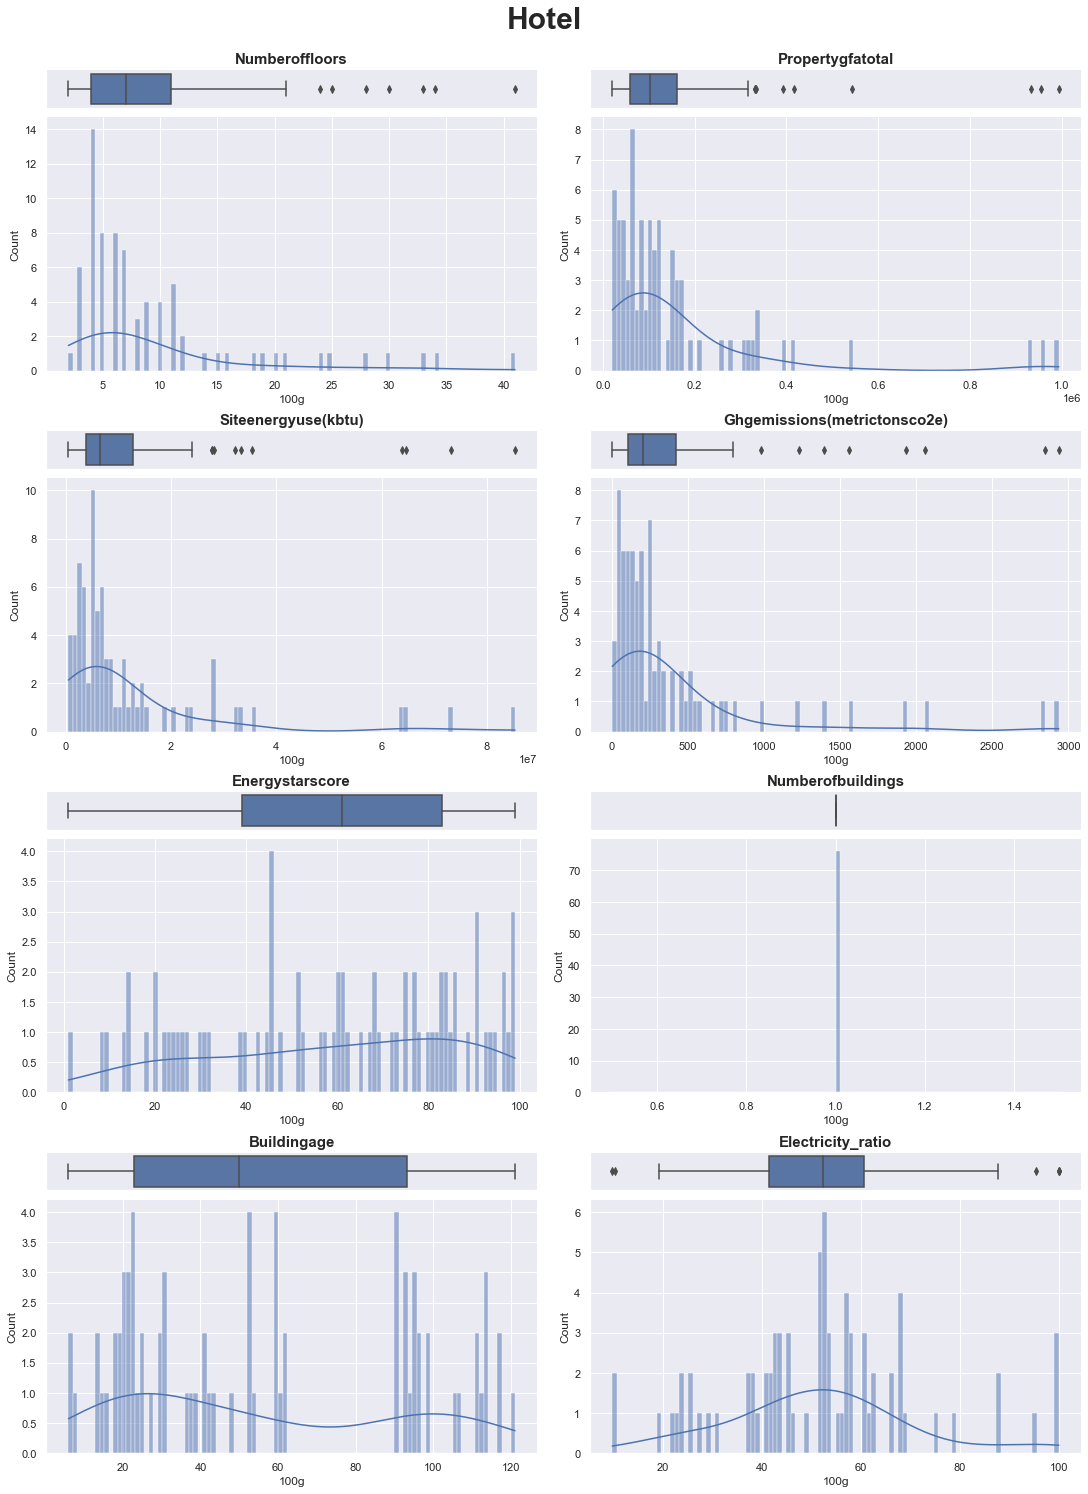

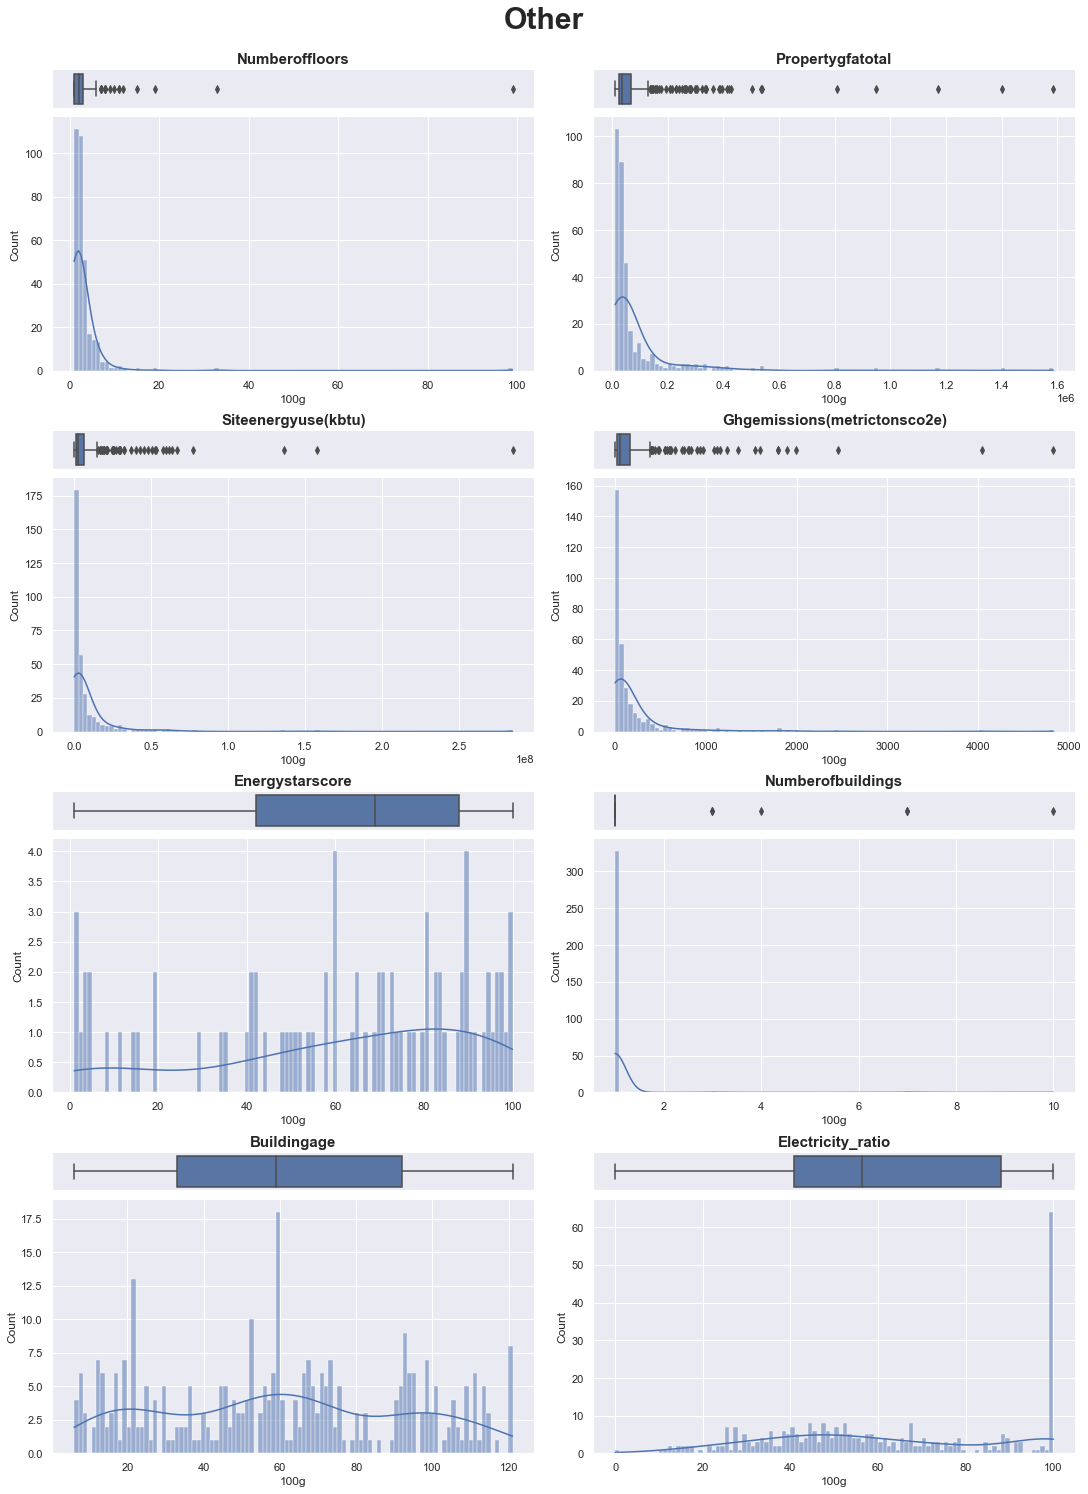

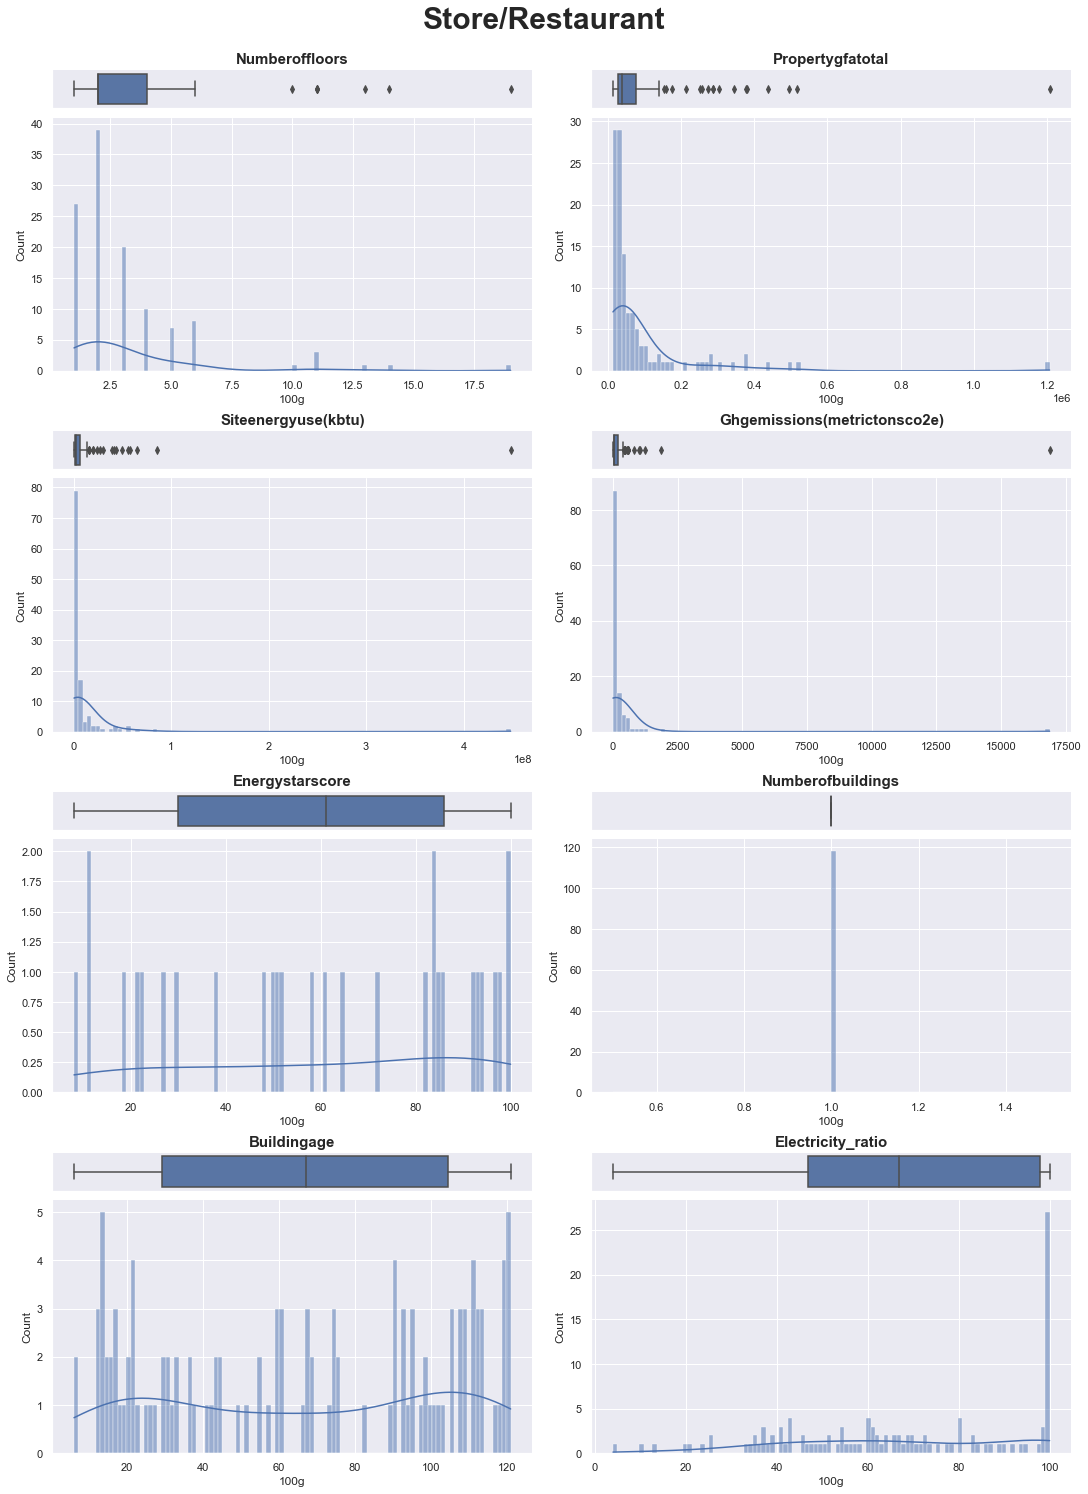

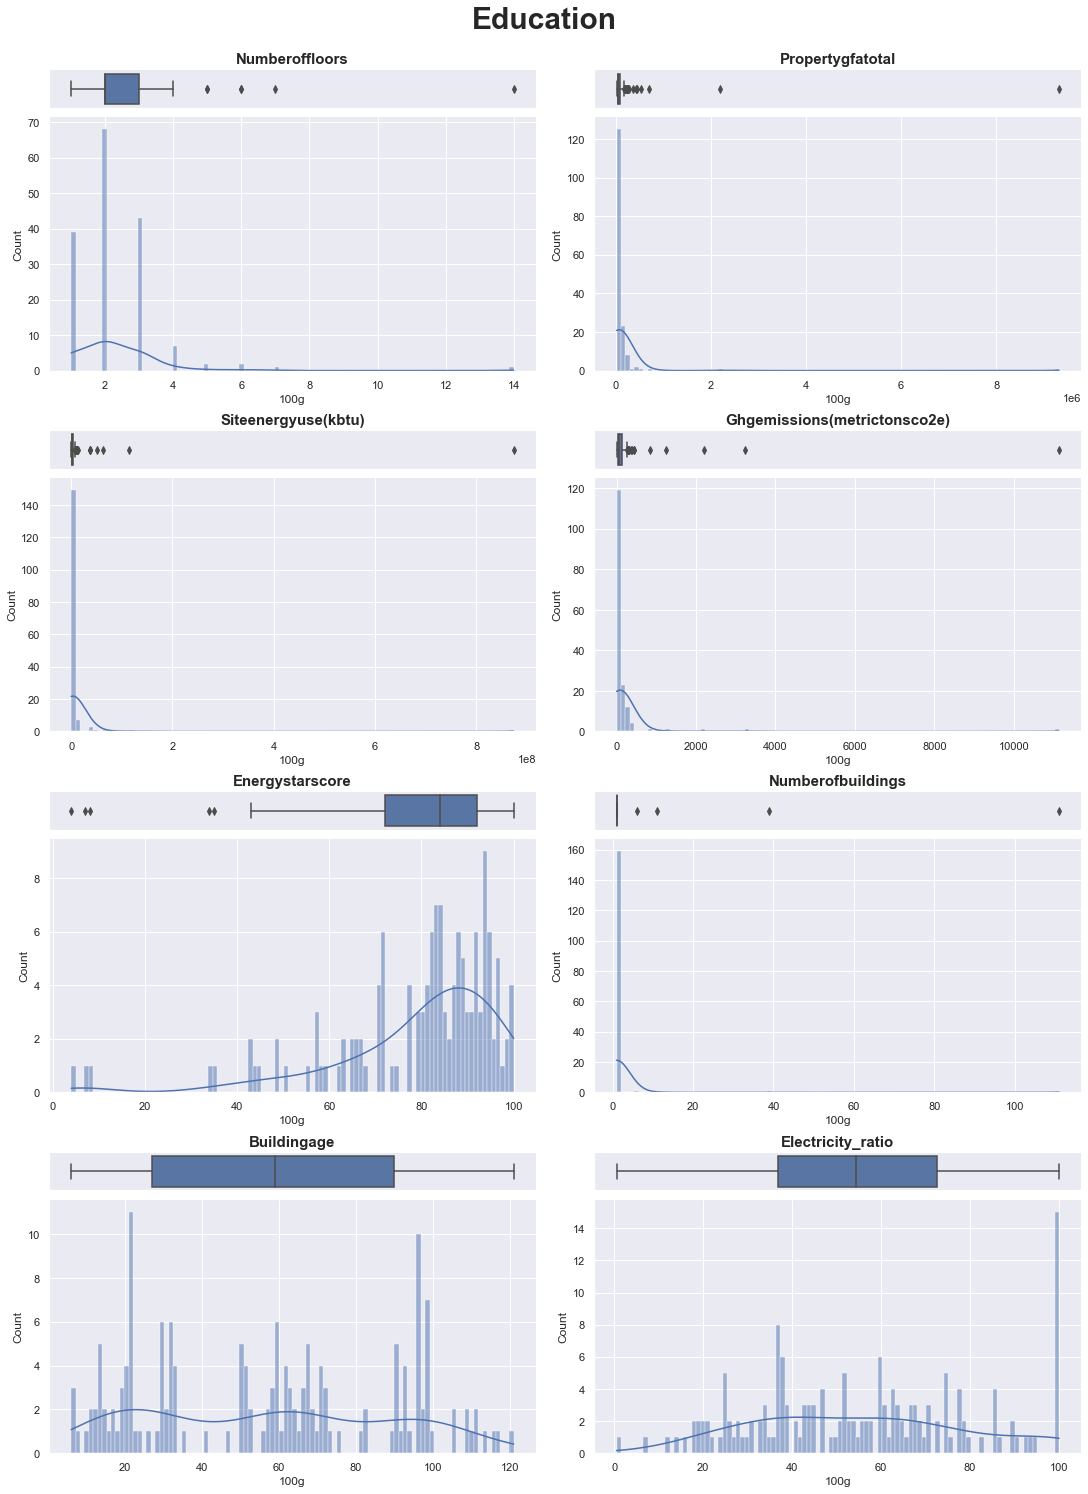

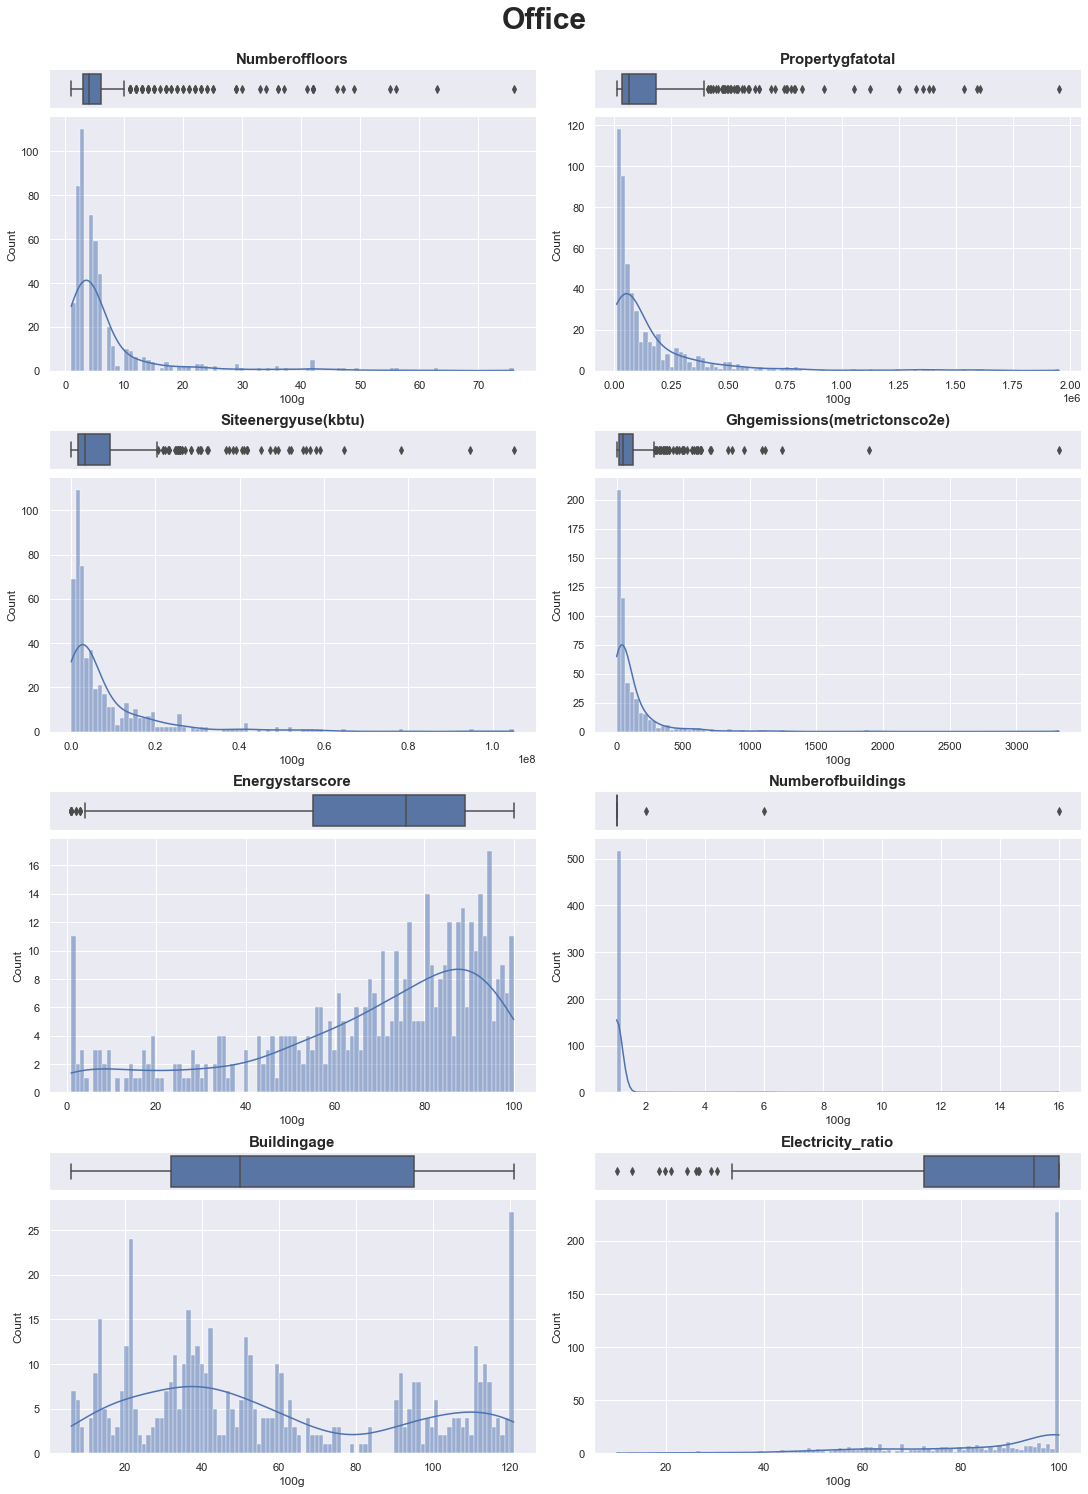

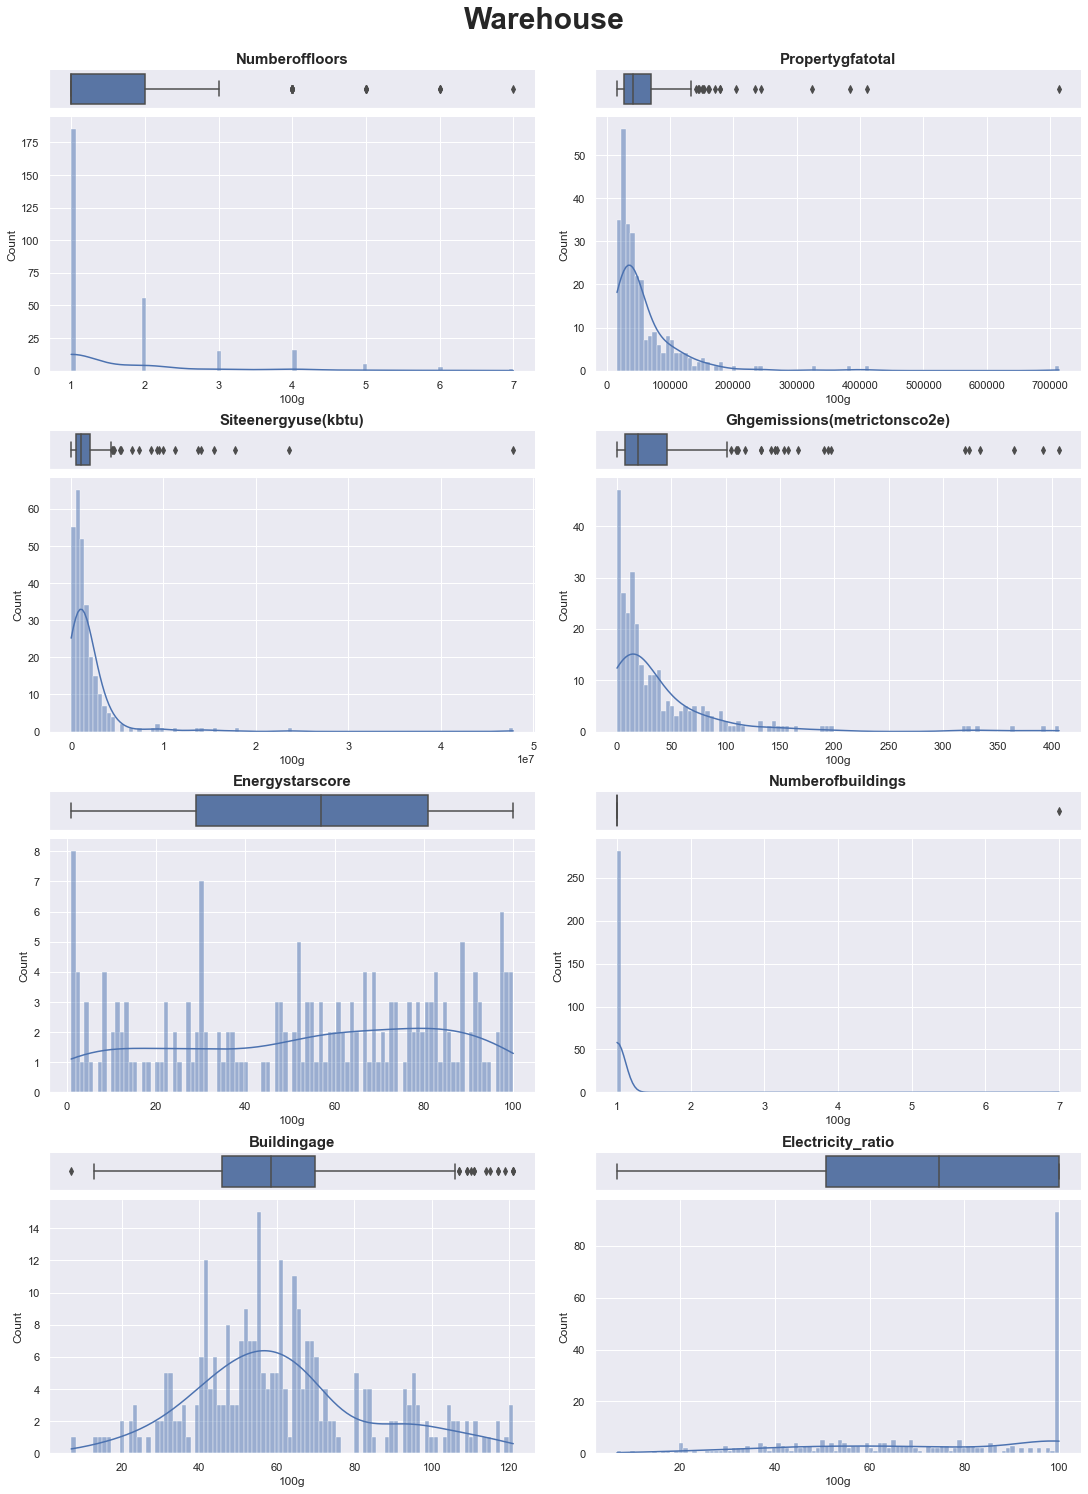

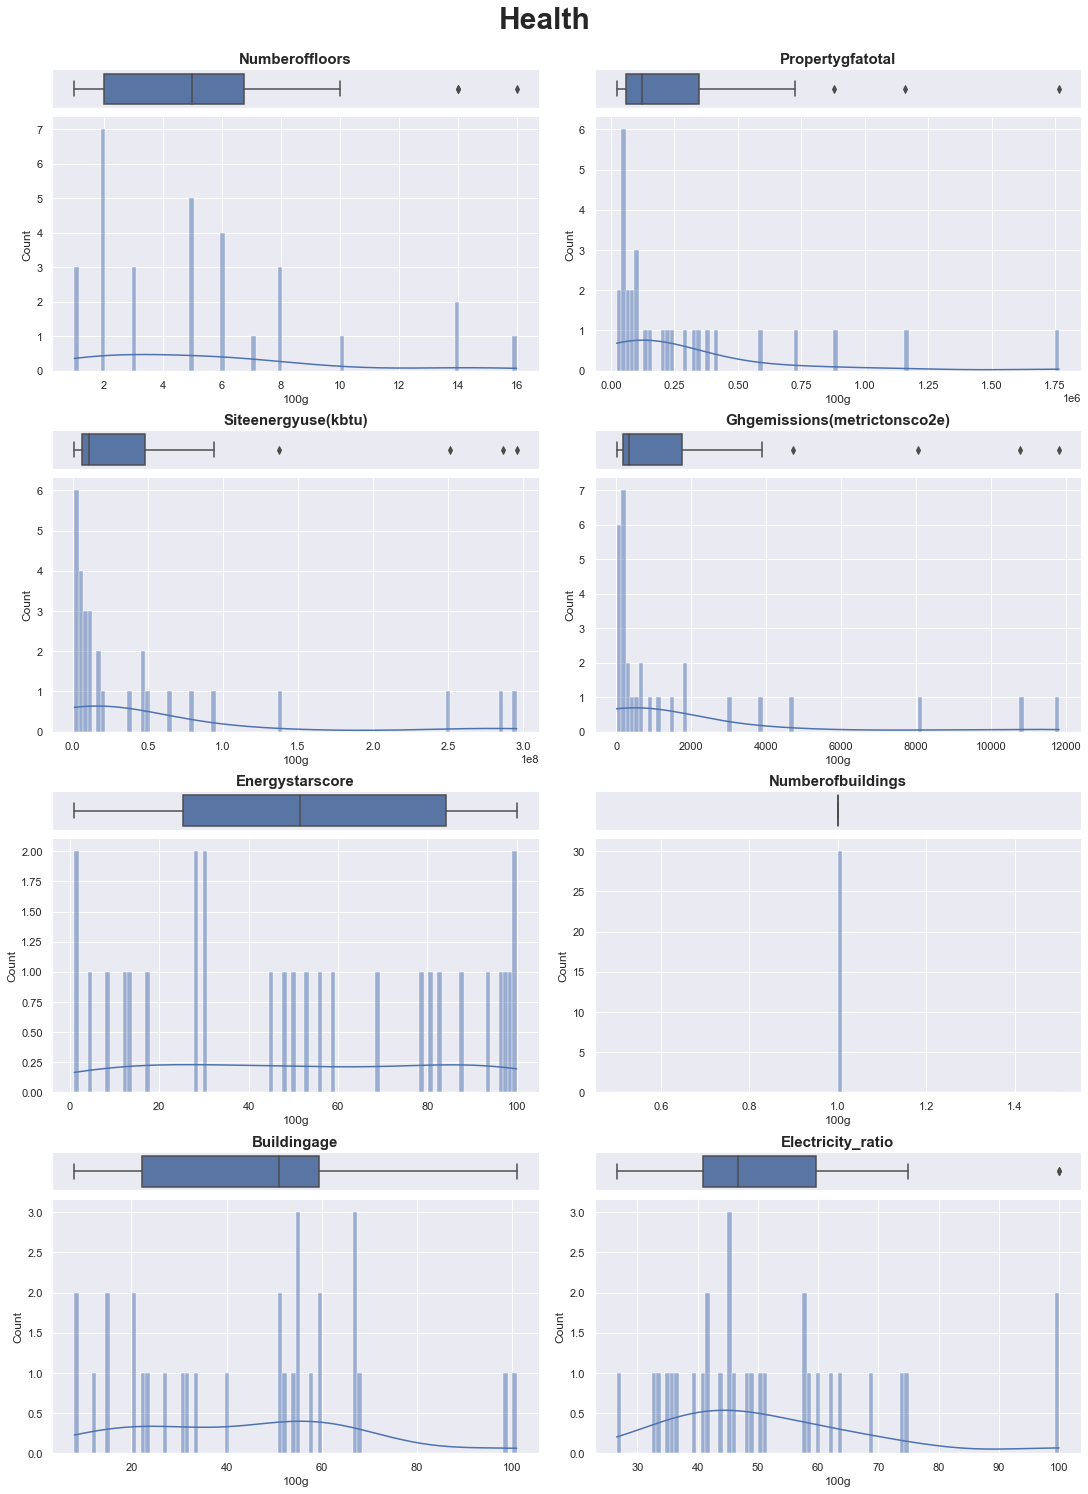

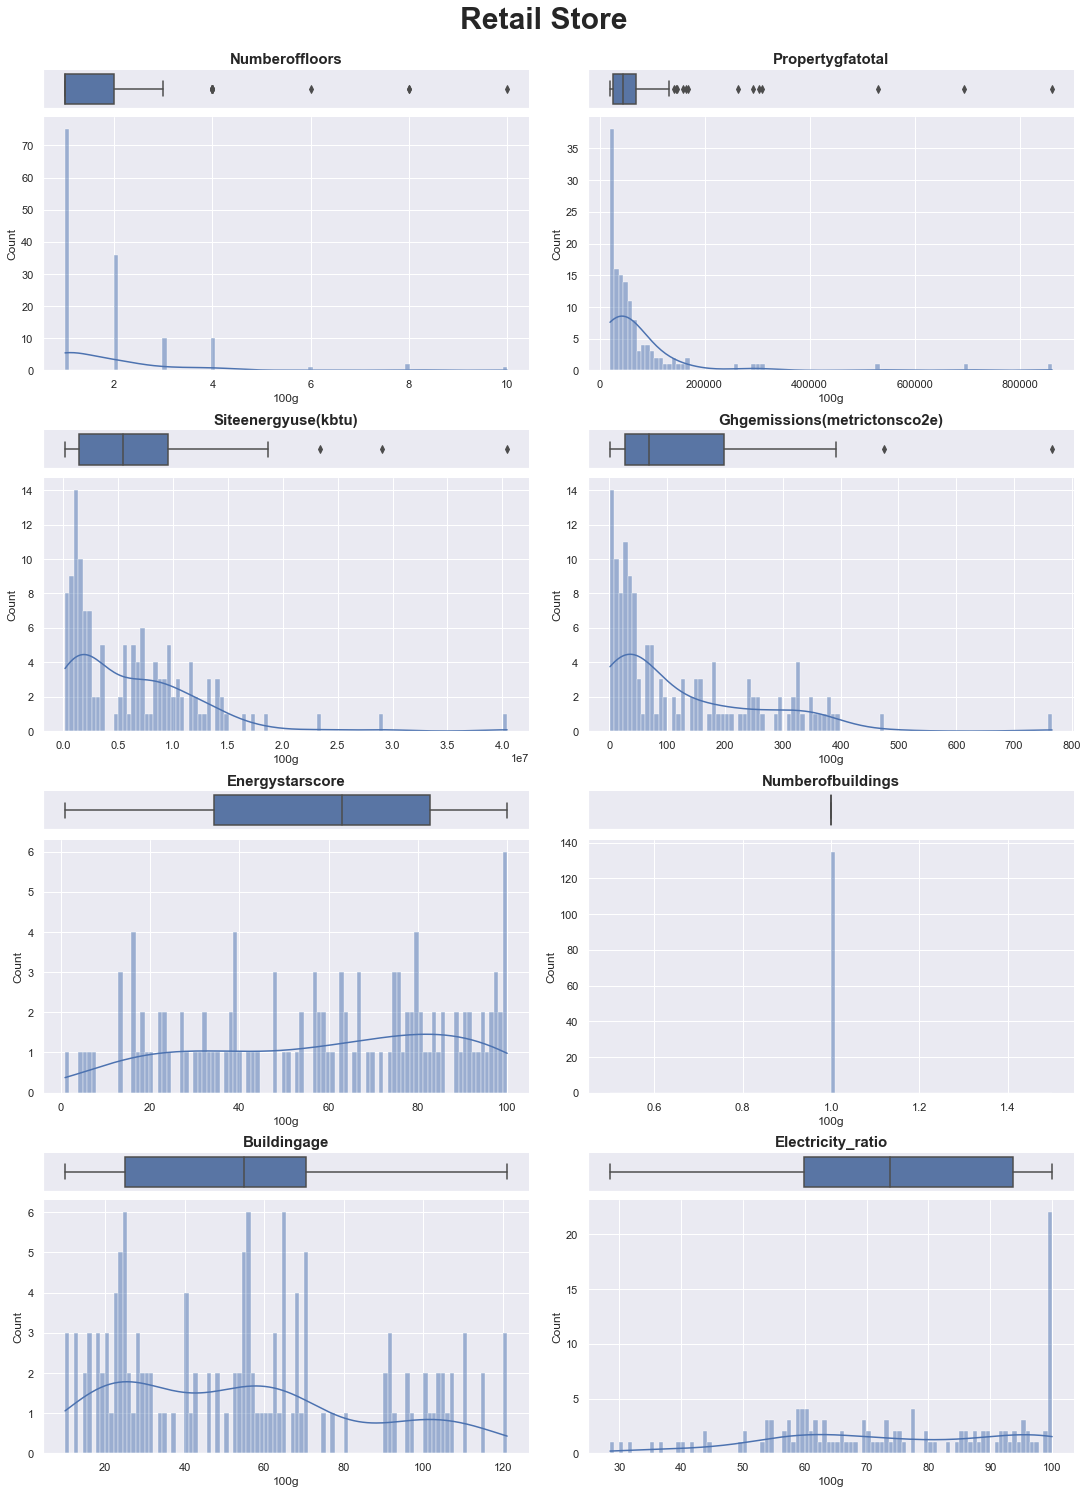

In [111]:
for property_type in df_bebcs["renamed_PropertyType"].unique():
    
    df_temp_by_property_type = df_bebcs[df_bebcs["renamed_PropertyType"] == property_type].copy()
    
    fig = plt.figure(constrained_layout=True, figsize=[15,20])
    fig.suptitle(property_type, size=30, fontweight="bold", y=1.03)
    spec = fig.add_gridspec(ncols=2, nrows=8, width_ratios=[1,1], height_ratios=[0.3,2,0.3,2,0.3,2,0.3,2])
    
    # to cycle through the columns 
    col_boxplot, col_histplot = 0, 0
    
    for i in range(8):
        
        for j in range(2):
            
            if i % 2 == 0:
                
                if col_boxplot > len(NUMERIC_COLS_APP) - 1:
                    break
                    
                ax_box = fig.add_subplot(spec[i, j])
                boxplot = sns.boxplot(data=df_temp_by_property_type, x=NUMERIC_COLS_APP[col_boxplot], ax=ax_box)
                
                # Remove x axis name for the boxplot
                ax_box.set(xlabel="", xticks=[])
                ax_box.set(yticks=[])
                
                boxplot.set_title(NUMERIC_COLS_APP[col_boxplot].capitalize(), fontdict={ "fontsize": 15, "fontweight": "bold" })
                
                col_boxplot += 1
                
            elif i % 2 != 0:
                
                if col_histplot > len(NUMERIC_COLS_APP) - 1:
                    break
                
                ax_hist = fig.add_subplot(spec[i, j])
                sns.histplot(data=df_temp_by_property_type, x=NUMERIC_COLS_APP[col_histplot], bins=100,  kde=True,  ax=ax_hist)
                ax_hist.set(xlabel="100g")
                
                col_histplot += 1
    
#     plt.savefig("img/nan-" + property_type + ".png", bbox_inches="tight")
    sns.despine(fig)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Treating outliers wit Z-Score</h3>
</div>

In [112]:
df_without_outliers_by_zscore = pd.DataFrame()

In [113]:
for property_type in df_bebcs["renamed_PropertyType"].unique():
    
    # for each property type, we are going to define the max and min threshold to replace outliers
    df_temp_outliers  = df_bebcs[df_bebcs["renamed_PropertyType"] == property_type].copy()
    
    for col in NUMERIC_COLS_APP:
        
        # Defining the Z Score
        df_temp_outliers[col + "_zscore"] = (df_temp_outliers[col] - df_temp_outliers[col].mean()) / df_temp_outliers[col].std()
        df_temp_outliers.loc[(df_temp_outliers[col + "_zscore"] > 3) | (df_temp_outliers[col + "_zscore"] < -3), col] = np.nan
        
        del df_temp_outliers[col + "_zscore"]
        
    df_without_outliers_by_zscore = pd.concat([df_without_outliers_by_zscore, df_temp_outliers])

<div class="alert alert-block alert-info">
     Analyzing the result
</div>

In [114]:
df_analysis(df_without_outliers_by_zscore, "df_without_outliers_by_zscore", type_analysis="complete")


Analysis of df_without_outliers_by_zscore dataset
--------------------------------------------------------------------
- Dataset shape:                  1656 rows and 14 columns
- Total of NaN values:            685
- Percentage of NaN:              2.95 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 138.5 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1656,1656,0,0.00000,16139.63345,1.00000,579.75000,21127.00000,24560.75000,50226.00000,13747.94898
1,Neighborhood,category,1656,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,BuildingAge,float64,1656,113,0,0.00000,59.22645,6.00000,32.00000,56.00000,91.00000,121.00000,32.65619
10,NaturalGas,bool,1656,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,SteamUse,bool,1656,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,OtherFuelUse,bool,1656,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,renamed_PropertyType,category,1656,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Electricity_ratio,float64,1650,1291,6,0.36000,70.93898,0.00033,50.77261,72.52696,99.99999,100.00874,25.67278
7,NumberofBuildings,float64,1647,5,9,0.54000,1.01214,1.00000,1.00000,1.00000,1.00000,11.00000,0.28506
5,GHGEmissions(MetricTonsCO2e),float64,1628,1555,28,1.69000,139.03994,0.08000,19.15750,47.60500,133.94750,10780.64000,425.97345


<div class="alert alert-block alert-info">
    Selecting only the rows without missing-values on the target values
</div>

In [115]:
df_bebcs = pd.DataFrame(df_without_outliers_by_zscore[df_without_outliers_by_zscore[["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"]].notnull().all(axis=1)]).reset_index(drop=True)

In [116]:
df_analysis(df_bebcs, "df_bebcs", type_analysis="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  1614 rows and 14 columns
- Total of NaN values:            572
- Percentage of NaN:              2.53 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 122.5 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1614,1614,0,0.00000,16392.99009,1.00000,599.25000,21181.50000,24590.50000,50226.00000,13641.76985
1,Neighborhood,category,1614,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SiteEnergyUse(kBtu),float64,1614,1613,0,0.00000,6301646.01963,11441.00000,1188142.75000,2397995.50000,6499306.00000,295812640.00000,13693695.87053
5,GHGEmissions(MetricTonsCO2e),float64,1614,1541,0,0.00000,134.64926,0.08000,19.08000,47.22000,131.02750,10780.64000,422.52765
8,BuildingAge,float64,1614,113,0,0.00000,59.44796,6.00000,32.00000,56.00000,91.00000,121.00000,32.75537
10,NaturalGas,bool,1614,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,SteamUse,bool,1614,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,OtherFuelUse,bool,1614,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,renamed_PropertyType,category,1614,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NumberofBuildings,float64,1610,5,4,0.25000,1.01118,1.00000,1.00000,1.00000,1.00000,11.00000,0.28403


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>At this point we've reduced the dataset from 1656 to 1551 rows</p>
    <p><b>Note</b></p>
    <p>We are not going to treat the missing-values for the target values</p>
</div>

<div class="alert alert-block alert-info">
    Now, we are going to save the dataframe without transformation to make all process through pipelines in the modeling notebook
</div>

In [117]:
df_bebcs_without_transformation = df_bebcs.copy()

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Exploratory Data Analysis I</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Univariate analysis for continous variables</h3>
</div>
<br>
<div class="alert alert-block alert-info">
    Before to make missing-values treating, we are going to analyse normal distribution for each continuos variable
</div>

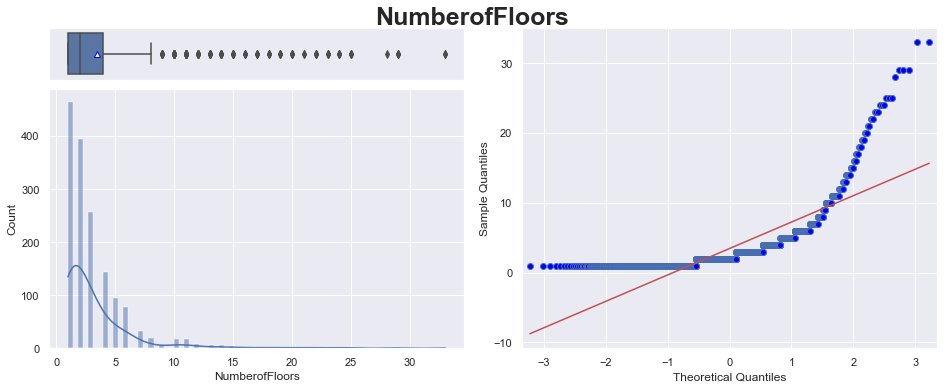


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,NumberofFloors,Shapiro-Wilk,"Statistics=0.610, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,NumberofFloors,D’Agostino’s K^2,"Statistics=1228.734, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,NumberofFloors,Kolmogorov-Smirnov,"Statistics=0.841, p-value=0.000",Sample does not look Gaussian (reject H₀)


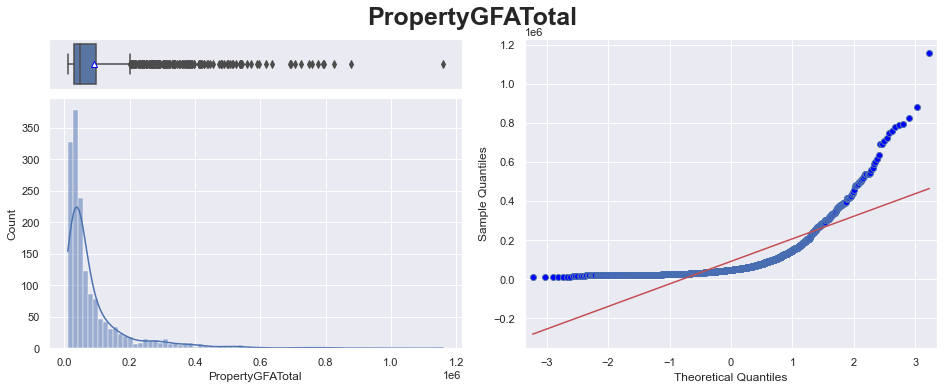


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,PropertyGFATotal,Shapiro-Wilk,"Statistics=0.608, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,PropertyGFATotal,D’Agostino’s K^2,"Statistics=1161.630, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,PropertyGFATotal,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


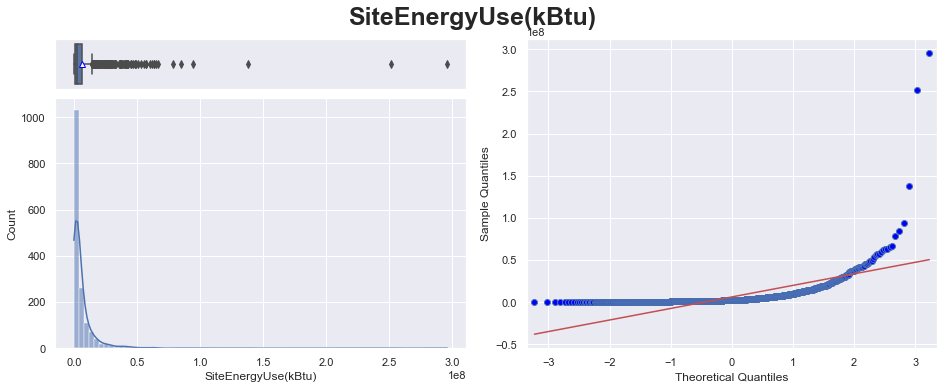


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,SiteEnergyUse(kBtu),Shapiro-Wilk,"Statistics=0.364, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,SiteEnergyUse(kBtu),D’Agostino’s K^2,"Statistics=2740.539, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,SiteEnergyUse(kBtu),Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


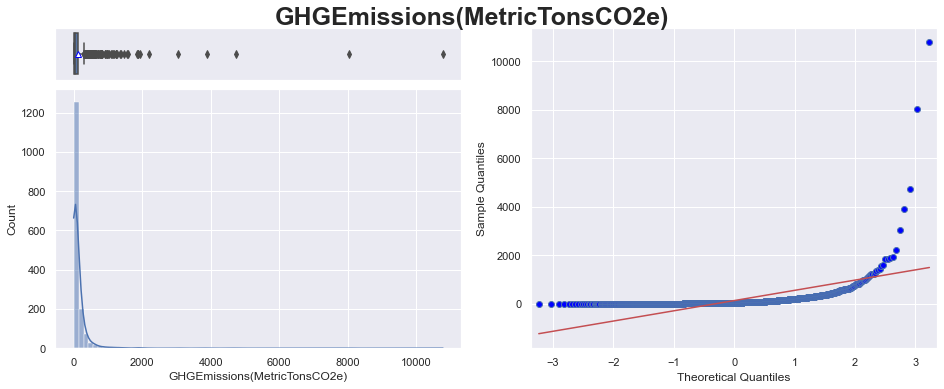


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,GHGEmissions(MetricTonsCO2e),Shapiro-Wilk,"Statistics=0.227, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,GHGEmissions(MetricTonsCO2e),D’Agostino’s K^2,"Statistics=3256.237, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,GHGEmissions(MetricTonsCO2e),Kolmogorov-Smirnov,"Statistics=0.969, p-value=0.000",Sample does not look Gaussian (reject H₀)


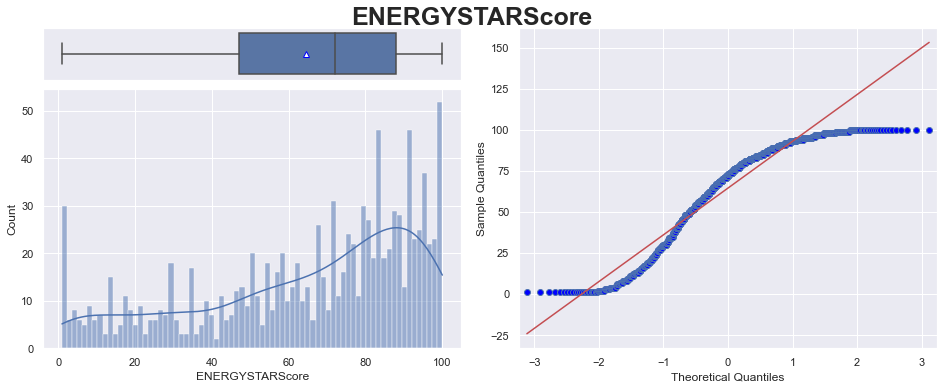


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,ENERGYSTARScore,Shapiro-Wilk,"Statistics=0.908, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,ENERGYSTARScore,D’Agostino’s K^2,"Statistics=111.826, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,ENERGYSTARScore,Kolmogorov-Smirnov,"Statistics=0.971, p-value=0.000",Sample does not look Gaussian (reject H₀)


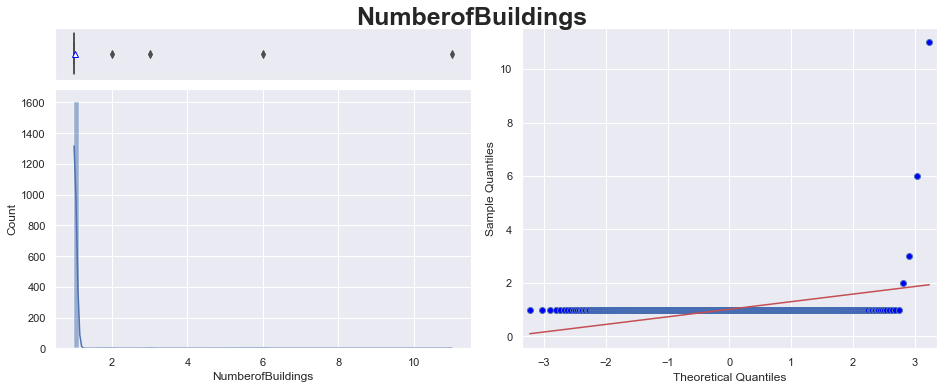


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,NumberofBuildings,Shapiro-Wilk,"Statistics=0.017, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,NumberofBuildings,D’Agostino’s K^2,"Statistics=4296.117, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,NumberofBuildings,Kolmogorov-Smirnov,"Statistics=0.841, p-value=0.000",Sample does not look Gaussian (reject H₀)


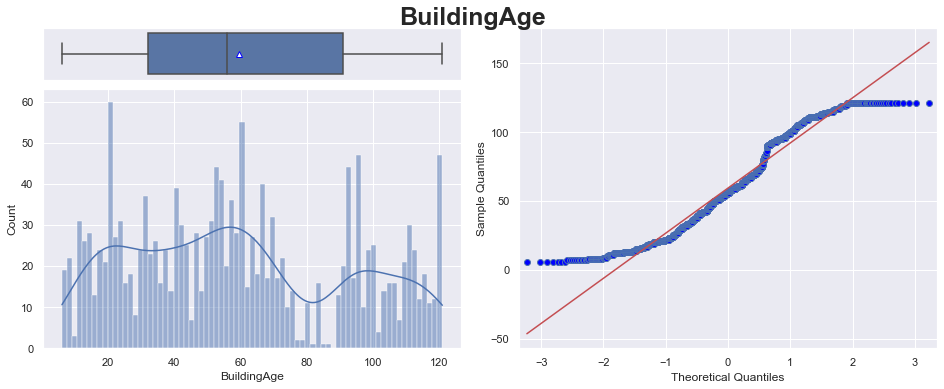


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,BuildingAge,Shapiro-Wilk,"Statistics=0.950, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,BuildingAge,D’Agostino’s K^2,"Statistics=474.986, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,BuildingAge,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


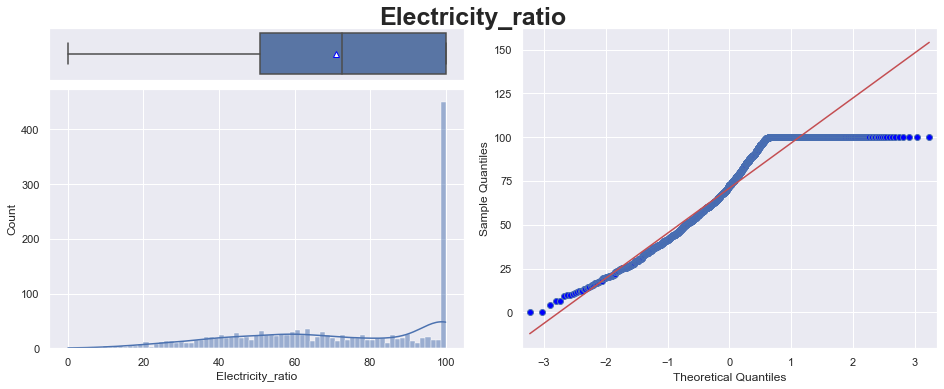


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,Electricity_ratio,Shapiro-Wilk,"Statistics=0.904, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,Electricity_ratio,D’Agostino’s K^2,"Statistics=438.239, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,Electricity_ratio,Kolmogorov-Smirnov,"Statistics=0.999, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [118]:
for var in NUMERIC_COLS_APP:
    
    # We are going to work only with the rows without missing-values for the features
    df_subset = pd.DataFrame(df_bebcs[df_bebcs[[var]].notnull().all(axis=1)]).reset_index(drop=True)
    
    fig = plt.figure(constrained_layout=True, figsize=[13,5])
    fig.suptitle(var, size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

    ax_box = fig.add_subplot(spec[0, 0])
    ax_hist = fig.add_subplot(spec[1, 0])
    ax_qqplot = fig.add_subplot(spec[:, 1])

    # Boxplot
    boxplot = sns.boxplot(data=df_subset, x=df_subset[var], showmeans=True, ax=ax_box,
                          meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
    ax_box.set(xlabel="", xticks=[])
    ax_box.set(yticks=[])
    boxplot.set_title("")

    # Histplot
    sns.histplot(data=df_subset, x=df_subset[var], bins=75,  kde=True,  ax=ax_hist)
    ax_hist.set(xlabel=var)
    
    # QQplot
    qqplot(df_subset[var], line='s', ax=ax_qqplot)

    plt.savefig("img/qqplot-of-" + var + ".png")
    plt.show()

    print("\nMaking the Normality Test")
    print("---------------------------------")
    normality_test(df_subset[[var]])
    print("\n")

In [119]:
pd.reset_option("display.max_colwidth") # reset width of showing cols

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Continuous Variables Transformation</h3>
</div>
<br>
<div class="alert alert-block alert-info">
     Based on the <b>Univariate analysis</b> where we note that <b>none</b> of the analyzed numeric variables have a <b>Normal distribution</b>
     and <b>all their values are very close</b> so, we are going to apply the <b>Logarithmic transformation</b> in these variables to get a <b>better Normal distribution</b> of these values
</div>

In [120]:
for col in NUMERIC_COLS_APP:
    df_bebcs[col + "_log"] = np.log(df_bebcs[col] + 1)
    df_bebcs[col + "_log2"] = np.log2(df_bebcs[col] + 1)
    df_bebcs[col + "_log10"] = np.log10(df_bebcs[col] + 1)

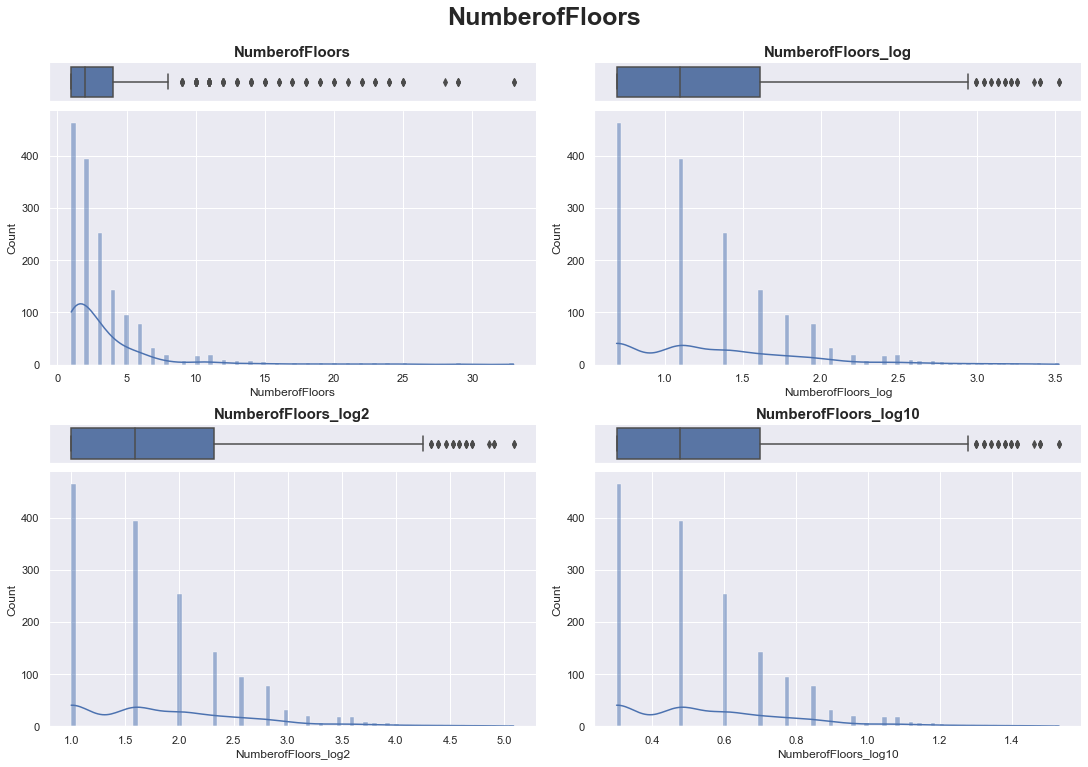


Variance of NumberofFloors
------------------------------------


,variance
NumberofFloors_log,0.322902
NumberofFloors_log2,0.672078
NumberofFloors_log10,0.060903


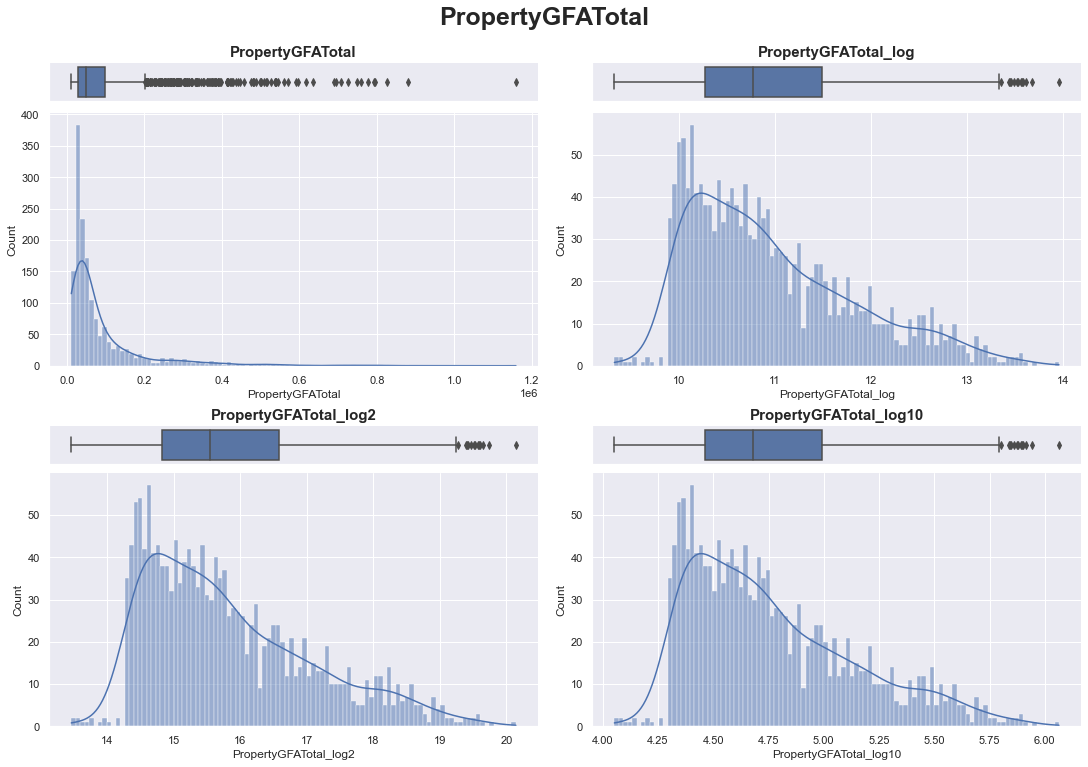


Variance of PropertyGFATotal
------------------------------------


,variance
PropertyGFATotal_log,0.739175
PropertyGFATotal_log2,1.538497
PropertyGFATotal_log10,0.139417


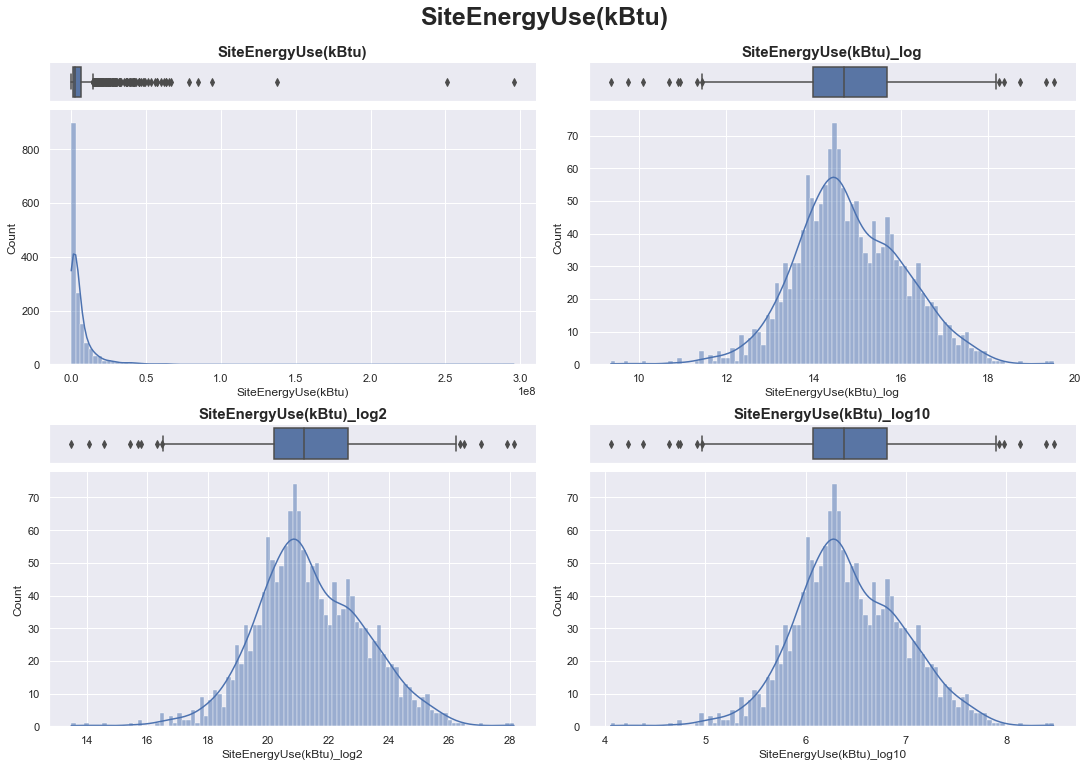


Variance of SiteEnergyUse(kBtu)
------------------------------------


,variance
SiteEnergyUse(kBtu)_log,1.584431
SiteEnergyUse(kBtu)_log2,3.297785
SiteEnergyUse(kBtu)_log10,0.298842


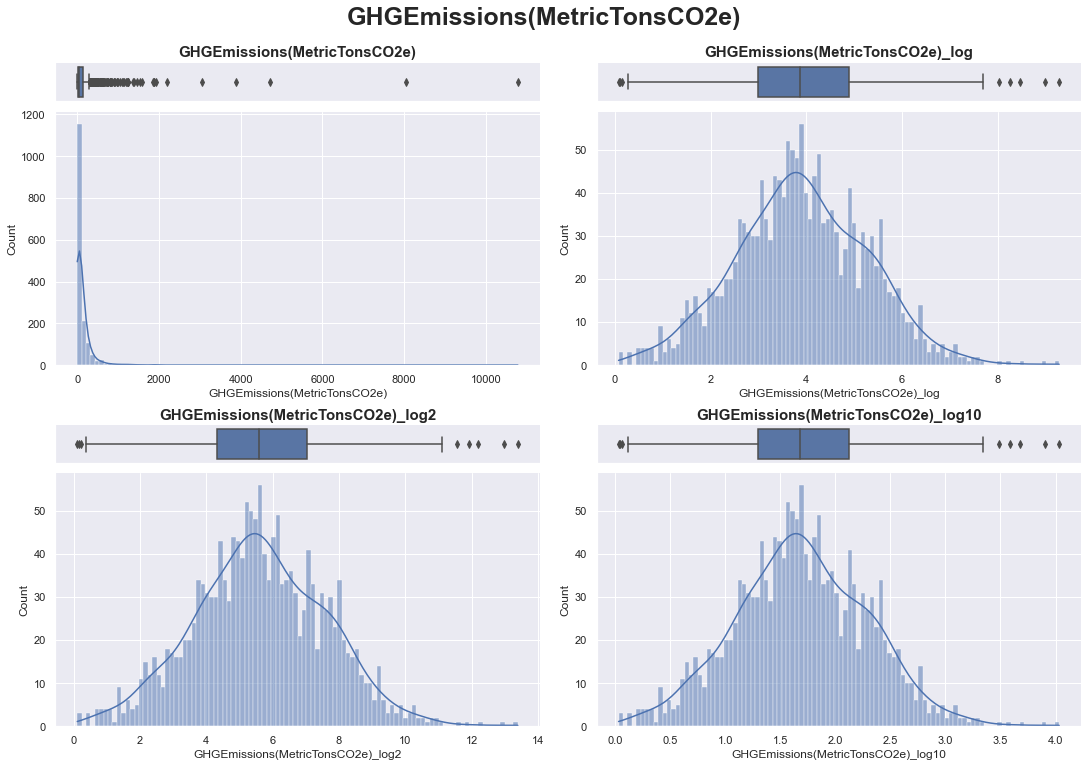


Variance of GHGEmissions(MetricTonsCO2e)
------------------------------------


,variance
GHGEmissions(MetricTonsCO2e)_log,1.900577
GHGEmissions(MetricTonsCO2e)_log2,3.955802
GHGEmissions(MetricTonsCO2e)_log10,0.358471


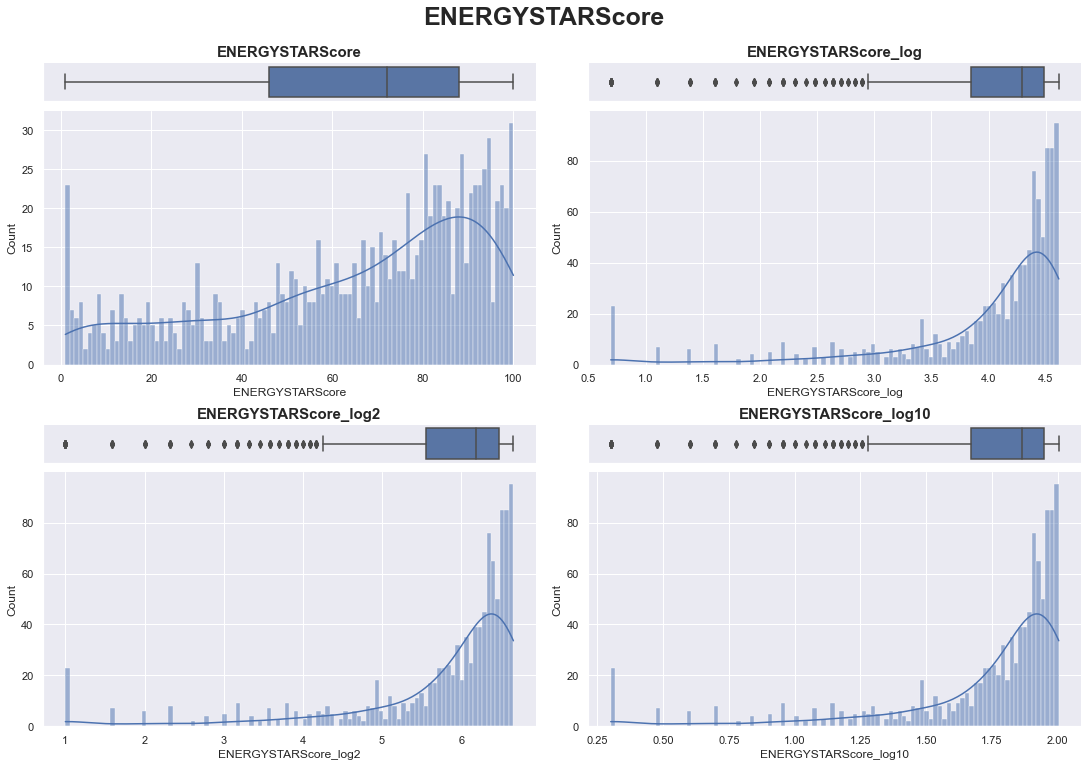


Variance of ENERGYSTARScore
------------------------------------


,variance
ENERGYSTARScore_log,0.688961
ENERGYSTARScore_log2,1.433981
ENERGYSTARScore_log10,0.129946


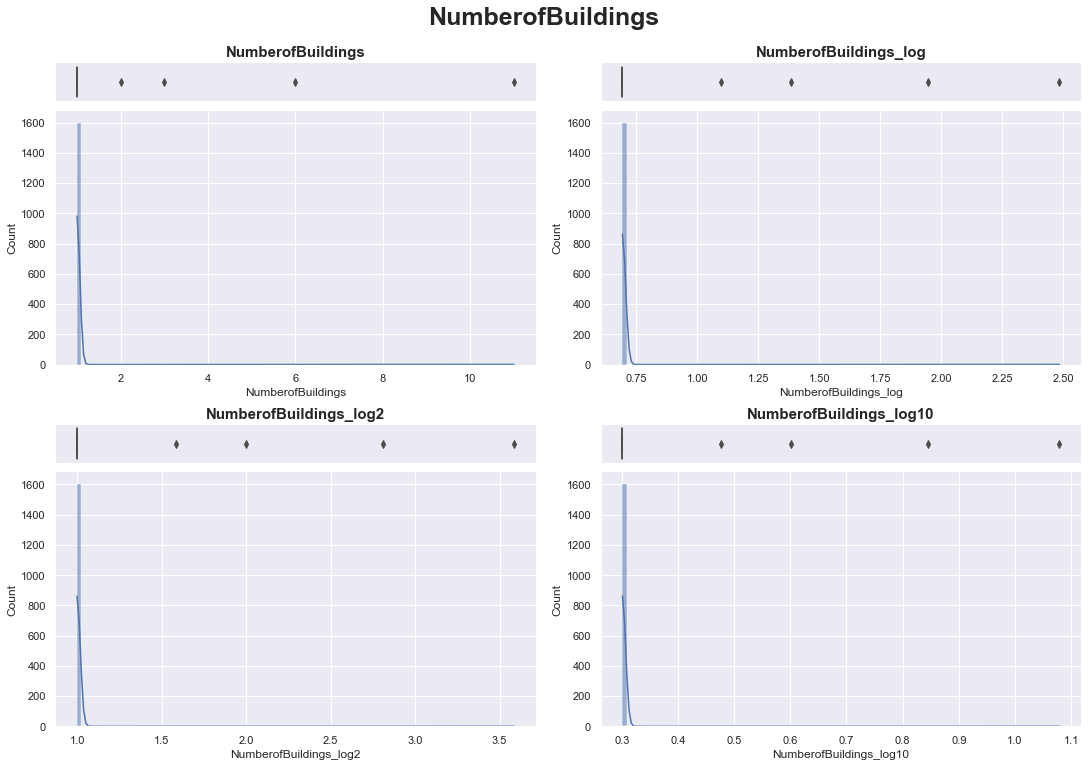


Variance of NumberofBuildings
------------------------------------


,variance
NumberofBuildings_log,0.003365
NumberofBuildings_log2,0.007003
NumberofBuildings_log10,0.000635


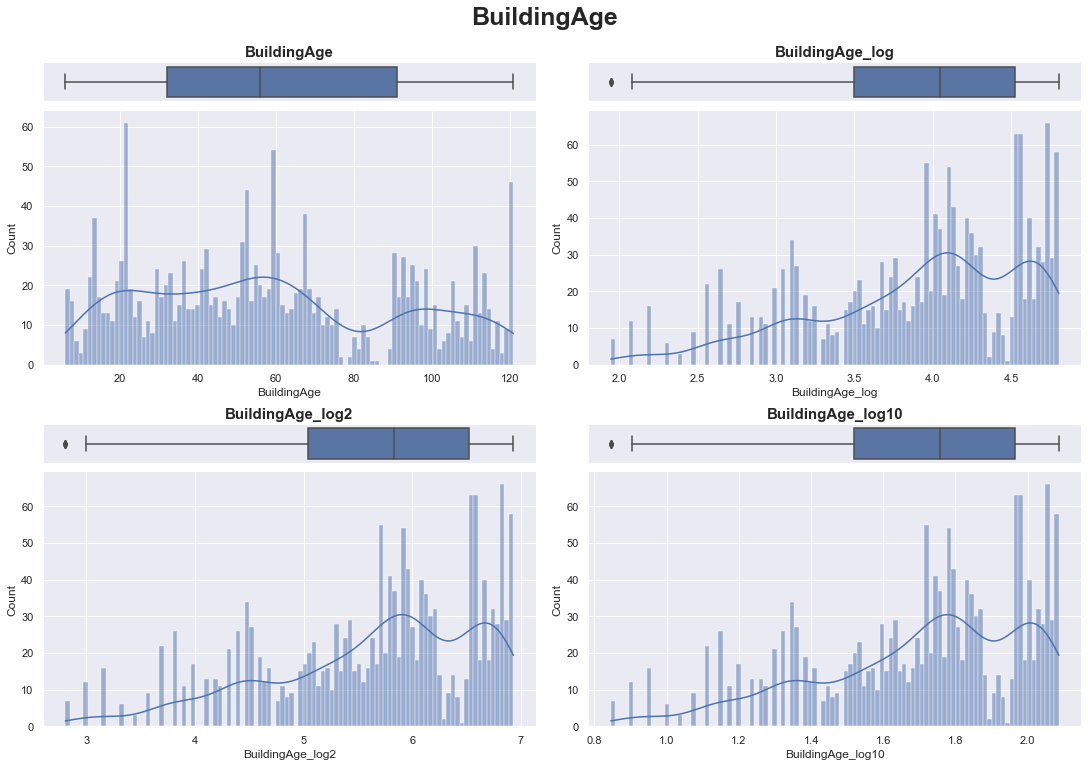


Variance of BuildingAge
------------------------------------


,variance
BuildingAge_log,0.450306
BuildingAge_log2,0.937252
BuildingAge_log10,0.084933


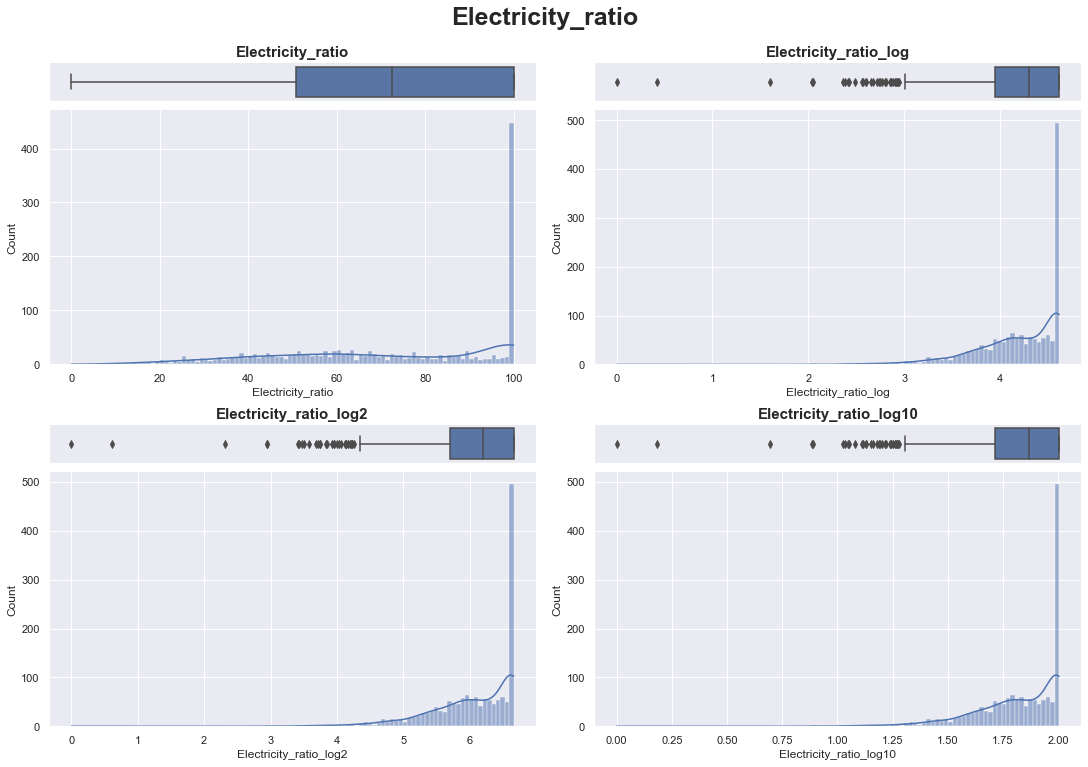


Variance of Electricity_ratio
------------------------------------


,variance
Electricity_ratio_log,0.222037
Electricity_ratio_log2,0.462141
Electricity_ratio_log10,0.041879


In [121]:
for var in NUMERIC_COLS_APP:
    
    # We are going to work only with the rows without missing-values for the features
    df_subset = pd.DataFrame(df_bebcs[df_bebcs[[col]].notnull().all(axis=1)]).reset_index(drop=True)
    
    var_cols = [var + "", var + "_log", var + "_log2", var + "_log10"]
    
    fig = plt.figure(constrained_layout=True, figsize=[15,10])
    fig.suptitle(var, size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(ncols=2, nrows=4, width_ratios=[1,1], height_ratios=[0.3,2,0.3,2])
    
    # to cycle through the columns 
    col_boxplot, col_histplot = 0, 0
    
    for i in range(4):
        
        for j in range(2):
            
            if i % 2 == 0:
                
                if col_boxplot > len(var_cols) - 1:
                    break
                    
                ax_box = fig.add_subplot(spec[i, j])
                boxplot = sns.boxplot(data=df_subset, x=var_cols[col_boxplot], ax=ax_box)
                
                # Remove x axis name for the boxplot
                ax_box.set(xlabel="", xticks=[])
                ax_box.set(yticks=[])
                
                boxplot.set_title(var_cols[col_boxplot], fontdict={ "fontsize": 15, "fontweight": "bold" })
                
                col_boxplot += 1
                
            elif i % 2 != 0:
                
                if col_histplot > len(NUMERIC_COLS_APP) - 1:
                    break
                
                ax_hist = fig.add_subplot(spec[i, j])
                sns.histplot(data=df_subset, x=var_cols[col_histplot], bins=100,  kde=True,  ax=ax_hist)
                ax_hist.set(xlabel=var_cols[col_histplot])
                
                col_histplot += 1
    
    plt.savefig("img/transformation-" + var + ".png", bbox_inches="tight")
    sns.despine(fig)  
    plt.show()
    
    print("\nVariance of", var)
    print("------------------------------------")
    var_cols.remove(var)
    df_temp = pd.DataFrame(df_bebcs[var_cols].var(), columns=["variance"])
    display(df_temp.style.apply(highlight_max))
    print("\n")

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br><br>
    Based on the description of data and distribution plot before and after transformation, we can notice the following
    <ul style="list-style-type: square;">
        <li>Some features <b>cannot achieve</b> a normal distribution due to much of their data is composed by the same number.<br> 
             So, we are going to <b>exclude</b> these features from the transformation. </li>
            <ul style="list-style-type: disc;">
                <li>NumberofBuildings</li>
                <li>NumberofFloors</li>
                <li>BuildingAge</li>
                <li>Electricity_ratio</li>
                <li>ENERGYSTARScore</li> 
            </ul>  
        <li>For the others features, we are going to work with <b>log_2</b> because is the <b>highest variance</b></li>
            <ul style="list-style-type: disc;">
                <li>PropertyGFATotal</li>            
                <li>SiteEnergyUse(kBtu)</li>
                <li>GHGEmissions(MetricTonsCO2e)</li>
            </ul>  
    </ul>  
</div>

<div class="alert alert-block alert-info">
     Deleting the columns differents to "_log2" and ordering columns
</div>

In [122]:
COL_TO_DELETE = []
for col in df_bebcs.columns:
    if "_log" in df_bebcs[col].name and "_log2" not in df_bebcs[col].name:
        COL_TO_DELETE.append(df_bebcs[col].name)
        
for col in ["NumberofBuildings", "NumberofFloors", "BuildingAge", "Electricity_ratio", "ENERGYSTARScore"]:
    COL_TO_DELETE.append(df_bebcs[col + "_log2"].name)
    
for col in ["PropertyGFATotal", "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"]:
    COL_TO_DELETE.append(df_bebcs[col].name)
    
df_bebcs.drop(labels=COL_TO_DELETE, axis=1, inplace=True)

In [123]:
for col in df_bebcs.columns:
    if "log" in col:
        df_bebcs[col[:-5]] = df_bebcs[col]
        del df_bebcs[col]

In [124]:
COL_ORDERED = ["OSEBuildingID", "Neighborhood", "BuildingAge", "NumberofFloors", "NumberofBuildings", 
               "PropertyGFATotal", "renamed_PropertyType", "Electricity_ratio", "NaturalGas", "SteamUse", 
               "OtherFuelUse", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"
]

In [125]:
df_bebcs = df_bebcs[COL_ORDERED]

In [126]:
df_bebcs.head()

,OSEBuildingID,Neighborhood,BuildingAge,NumberofFloors,NumberofBuildings,PropertyGFATotal,renamed_PropertyType,Electricity_ratio,NaturalGas,SteamUse,OtherFuelUse,ENERGYSTARScore,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
0,1,DOWNTOWN,94.0,12.0,1.0,16.432330,Hotel,52.79951,True,True,False,65.0,22.735091,7.968264
1,2,DOWNTOWN,25.0,11.0,1.0,16.660205,Hotel,46.74768,True,False,False,51.0,22.994076,8.047178
2,5,DOWNTOWN,95.0,10.0,1.0,15.904094,Hotel,9.80903,True,True,False,1.0,24.750691,10.919861
3,8,DOWNTOWN,41.0,18.0,1.0,17.421777,Hotel,40.90771,True,False,False,67.0,23.821928,8.990671
4,10,DOWNTOWN,95.0,11.0,1.0,16.340980,Hotel,42.85568,True,False,False,25.0,22.576081,7.710531


In [127]:
df_analysis(df_bebcs, "df_bebcs", type_analysis="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  1614 rows and 14 columns
- Total of NaN values:            572
- Percentage of NaN:              2.53 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 122.5 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1614,1614,0,0.00000,16392.99009,1.00000,599.25000,21181.50000,24590.50000,50226.00000,13641.76985
1,Neighborhood,category,1614,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BuildingAge,float64,1614,113,0,0.00000,59.44796,6.00000,32.00000,56.00000,91.00000,121.00000,32.75537
6,renamed_PropertyType,category,1614,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaturalGas,bool,1614,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,SteamUse,bool,1614,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,OtherFuelUse,bool,1614,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,SiteEnergyUse(kBtu),float64,1614,1613,0,0.00000,21.39268,13.48205,20.18028,21.19340,22.63185,28.14011,1.81598
13,GHGEmissions(MetricTonsCO2e),float64,1614,1541,0,0.00000,5.62930,0.11103,4.32769,5.59156,7.04469,13.39629,1.98892
4,NumberofBuildings,float64,1610,5,4,0.25000,1.01118,1.00000,1.00000,1.00000,1.00000,11.00000,0.28403


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">7. Treating missing-values</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.1. Train/Test split</h3>
</div>

<div class="alert alert-block alert-info">
    Selecting only the rows without missing-values
</div>

In [128]:
df_subset = pd.DataFrame(df_bebcs[df_bebcs[["Electricity_ratio", "NumberofBuildings", "PropertyGFATotal", "NumberofFloors"]].notnull().all(axis=1)]).reset_index(drop=True)

In [129]:
df_subset.drop(columns=["ENERGYSTARScore", "OSEBuildingID"], axis=1, inplace=True)

In [130]:
df_analysis(df_subset, "df_subset")


Analysis of df_subset dataset
--------------------------------------------------------------------
- Dataset shape:                  1573 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 94.8 KB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,Neighborhood,category,1573,0,0.00000
1,BuildingAge,float64,1573,0,0.00000
2,NumberofFloors,float64,1573,0,0.00000
3,NumberofBuildings,float64,1573,0,0.00000
4,PropertyGFATotal,float64,1573,0,0.00000
5,renamed_PropertyType,category,1573,0,0.00000
6,Electricity_ratio,float64,1573,0,0.00000
7,NaturalGas,bool,1573,0,0.00000
8,SteamUse,bool,1573,0,0.00000
9,OtherFuelUse,bool,1573,0,0.00000


<div class="alert alert-block alert-info">
    <b>Slipt</b> the dataset into <b>train</b> and <b>test</b>.</br> We are goint to work with the configuration below
    <ul style="list-style-type: square;">
        <li>Spliting the dataset without missing-values into <b>70% training dataset</b> and <b>30% testing dataset</b></li>
        <li>Create a <b>copy</b> dataset based on <b>testing dataset</b></li>
        <li><b>To assign NaN 90%</b> of data for <b>Electricity_ratio</b>, <b>PropertyGFATotal</b> and <b>NumberofFloors</b> columns in the <b>copy</b> dataset based on <b>testing dataset</b></li>
        <li><b>Concatenating</b> the <b>training dataset</b> with <b>testing dataset (with 100% of NaN in testing dataset)</b> to make the <b>transform()</b></li>
    </ul>
</div>

In [131]:
test_features_nan = { "electricity" : "Electricity_ratio", "gfa_total" : "PropertyGFATotal", "number_floors" : "NumberofFloors", "number_buildings" : "NumberofBuildings"}

In [132]:
for item in test_features_nan.keys():
    globals()["train_" + item], globals()["test_" + item] = train_test_split(df_subset, test_size=0.3, random_state=0)
    globals()["test_NaN_" + item] = globals()["test_" + item].copy()
    globals()["test_NaN_" + item][test_features_nan.get(item)] = globals()["test_NaN_" + item][test_features_nan.get(item)].mask(np.random.random(globals()["test_NaN_" + item].shape[0]) < 0.99)
    
    globals()["test_" + item].loc[:, "Data"] = "Original"

C:\Users\Samir\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Samir\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.2. Data preprocessing</h3>
</div>

In [133]:
ohe = OneHotEncoder(sparse=False, drop="first")

In [134]:
scaler = StandardScaler()

In [135]:
for item in test_features_nan.keys():
    
    for df_type in ["train_", "test_NaN_"]:
        
        # Making OneHotEncoder on categorical columns
        array_ohe = ohe.fit_transform(globals()[df_type + item][["Neighborhood", "renamed_PropertyType"]])
        df_ohe = pd.DataFrame(array_ohe, index=globals()[df_type + item].index)
        df_ohe.columns = ohe.get_feature_names(["N", "PT"])
        
        # Droping the real columns and concatenating the encoder columns
        globals()[df_type + item] = globals()[df_type + item].drop(columns=["Neighborhood", "renamed_PropertyType"], axis=1)
        globals()[df_type + item] = pd.concat([globals()[df_type + item], df_ohe], axis=1)
        
        # Transforming boolean columns to numeric
        globals()[df_type + item]["NaturalGas"] = globals()[df_type + item]["NaturalGas"].astype(int)
        globals()[df_type + item]["SteamUse"] = globals()[df_type + item]["SteamUse"].astype(int)
        globals()[df_type + item]["OtherFuelUse"] = globals()[df_type + item]["OtherFuelUse"].astype(int)
        
        # Normalizing the datesets
        scaler_features = scaler.fit_transform(globals()[df_type + item])
        globals()[df_type + item + "_scaled"] = pd.DataFrame(scaler_features, index=globals()[df_type + item].index, columns=globals()[df_type + item].columns)
        

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.3. Make imputations</h3>
</div>

In [136]:
for item in test_features_nan.keys():
    
    for impute in ["SimpleImputer", "KNNImputer", "IterativeImputer"]:
        
        # Making the imputations by each impute
        globals()["result_" + item + "_" + impute] = df_imputations(globals()["train_" + item + "_scaled"], globals()["test_NaN_" + item + "_scaled"], impute, scaler)
        globals()["result_" + item + "_" + impute]["Data"] = impute
        
         # Concatenating the results to compare
        globals()["test_" + item] = pd.concat([globals()["test_" + item], globals()["result_" + item + "_" + impute]])

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.4. Calculating the Root Mean Square Error</h3>
</div>

In [137]:
LIST_METHOD, LIST_FEATURE, LIST_RMSE = [list() for i in range(3)]

for item in test_features_nan.keys():
    
    for data in globals()["test_" + item]["Data"].unique():
        
        if data != "Original":
            
            # Calculating MSE for each feature
            MSE = mean_squared_error((globals()["test_" + item].loc[globals()["test_" + item]["Data"] == "Original", test_features_nan.get(item)]), \
                                 (globals()["test_" + item].loc[globals()["test_" + item]["Data"] == data, test_features_nan.get(item)]))
            
            # Calculating RMSE for each feature
            RMSE = round(math.sqrt(MSE), 2)
            
            LIST_FEATURE.append(test_features_nan.get(item))
            LIST_METHOD.append(data)
            LIST_RMSE.append(RMSE)
            
            
df_RMSE = pd.DataFrame({
    "Feature" : LIST_FEATURE,
    "Method" : LIST_METHOD,
    "RMSE" : LIST_RMSE
})

df_RMSE

,Feature,Method,RMSE
0,Electricity_ratio,SimpleImputer,25.97
1,Electricity_ratio,KNNImputer,18.25
2,Electricity_ratio,IterativeImputer,7.18
3,PropertyGFATotal,SimpleImputer,1.19
4,PropertyGFATotal,KNNImputer,0.87
5,PropertyGFATotal,IterativeImputer,0.72
6,NumberofFloors,SimpleImputer,3.81
7,NumberofFloors,KNNImputer,2.52
8,NumberofFloors,IterativeImputer,2.69
9,NumberofBuildings,SimpleImputer,1.24


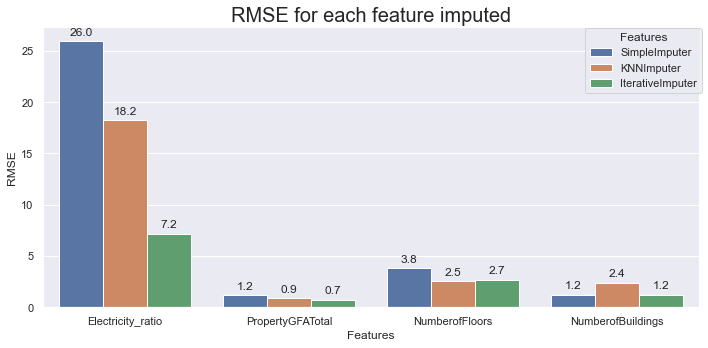

In [138]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title("RMSE for each feature imputed", size=20)
plot = sns.barplot(x="Feature", y="RMSE", hue="Method", data=df_RMSE, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Features")
plt.tight_layout()
plt.xlabel("Features", size=12)
plt.ylabel("RMSE", size=12)
plt.savefig("img/missing-values-imputations-RMSE.png")
sns.despine(fig)

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br><br>
    Considering that <b>IterativeImputer</b> is still experimental, we are goingo to treat missing values with <b>KNNImputer</b>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.5. Making final imputations</h3>
</div>

<div class="alert alert-block alert-info">
    Making a <b>mask</b> to filter the records <b>without missing-values</b> to use them to fit the <b>KNN Imputer</b>
</div>

In [139]:
df_bebcs_to_impute_KNN = df_bebcs.drop(columns=["ENERGYSTARScore"], axis=1)

In [140]:
mask = df_bebcs_to_impute_KNN[["Electricity_ratio", "PropertyGFATotal", "NumberofFloors", "NumberofBuildings"]].notnull().all(axis=1)

In [141]:
KNN_trainning_data = df_bebcs_to_impute_KNN[mask].copy()

In [142]:
df_analysis(df_bebcs_to_impute_KNN, "df_subset")


Analysis of df_subset dataset
--------------------------------------------------------------------
- Dataset shape:                  1614 rows and 13 columns
- Total of NaN values:            48
- Percentage of NaN:              0.23 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 109.9 KB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,1614,0,0.00000
1,Neighborhood,category,1614,0,0.00000
2,BuildingAge,float64,1614,0,0.00000
6,renamed_PropertyType,category,1614,0,0.00000
8,NaturalGas,bool,1614,0,0.00000
9,SteamUse,bool,1614,0,0.00000
10,OtherFuelUse,bool,1614,0,0.00000
11,SiteEnergyUse(kBtu),float64,1614,0,0.00000
12,GHGEmissions(MetricTonsCO2e),float64,1614,0,0.00000
4,NumberofBuildings,float64,1610,4,0.25000


<div class="alert alert-block alert-info">
    Preprocessing training data
</div>

In [143]:
# Making OneHotEncoder on categorical columns
array_ohe = ohe.fit_transform(KNN_trainning_data[["Neighborhood", "renamed_PropertyType"]])
df_ohe = pd.DataFrame(array_ohe, index=KNN_trainning_data.index)
df_ohe.columns = ohe.get_feature_names(["N", "PT"])

# Droping the real columns and concatenating the encoder columns
KNN_trainning_data = KNN_trainning_data.drop(columns=["Neighborhood", "renamed_PropertyType"], axis=1)
KNN_trainning_data = pd.concat([KNN_trainning_data, df_ohe], axis=1)

# Transforming boolean columns to numeric
KNN_trainning_data["NaturalGas"] = KNN_trainning_data["NaturalGas"].astype(int)
KNN_trainning_data["SteamUse"] = KNN_trainning_data["SteamUse"].astype(int)
KNN_trainning_data["OtherFuelUse"] = KNN_trainning_data["OtherFuelUse"].astype(int)

# Normalizing the datesets
scaler_features = scaler.fit_transform(KNN_trainning_data)
KNN_trainning_data_scaled = pd.DataFrame(scaler_features, index=KNN_trainning_data.index, columns=KNN_trainning_data.columns)

<div class="alert alert-block alert-info">
    Preprocessing all data
</div>

In [144]:
# Making OneHotEncoder on categorical columns
array_ohe = ohe.fit_transform(df_bebcs_to_impute_KNN[["Neighborhood", "renamed_PropertyType"]])
df_ohe = pd.DataFrame(array_ohe, index=df_bebcs_to_impute_KNN.index)
df_ohe.columns = ohe.get_feature_names(["N", "PT"])

# Droping the real columns and concatenating the encoder columns
df_bebcs_to_impute_KNN = df_bebcs_to_impute_KNN.drop(columns=["Neighborhood", "renamed_PropertyType"], axis=1)
df_bebcs_to_impute_KNN = pd.concat([df_bebcs_to_impute_KNN, df_ohe], axis=1)

# Transforming boolean columns to numeric
df_bebcs_to_impute_KNN["NaturalGas"] = df_bebcs_to_impute_KNN["NaturalGas"].astype(int)
df_bebcs_to_impute_KNN["SteamUse"] = df_bebcs_to_impute_KNN["SteamUse"].astype(int)
df_bebcs_to_impute_KNN["OtherFuelUse"] = df_bebcs_to_impute_KNN["OtherFuelUse"].astype(int)

# Normalizing the datesets
scaler_features = scaler.transform(df_bebcs_to_impute_KNN)
df_bebcs_to_impute_KNN_scaled = pd.DataFrame(scaler_features, index=df_bebcs_to_impute_KNN.index, columns=df_bebcs_to_impute_KNN.columns)

<div class="alert alert-block alert-info">
    Making the imputation
</div>

In [145]:
df_imputed = df_imputations(KNN_trainning_data_scaled, df_bebcs_to_impute_KNN_scaled, "KNNImputer", scaler)

<div class="alert alert-block alert-info">
    Refactoring the dataframe as original
</div>

In [146]:
for col in df_imputed.columns:
    if "PT_" in col or "N_" in col:
        del df_imputed[col]

In [147]:
df_imputed = pd.concat([df_imputed, df_bebcs[["Neighborhood", "renamed_PropertyType", "ENERGYSTARScore"]]], axis=1)

In [148]:
df_imputed["NaturalGas"] = df_imputed["NaturalGas"].astype(bool)
df_imputed["SteamUse"] = df_imputed["SteamUse"].astype(bool)
df_imputed["OtherFuelUse"] = df_imputed["OtherFuelUse"].astype(bool)

In [149]:
df_analysis(df_imputed, "df_imputed")


Analysis of df_imputed dataset
--------------------------------------------------------------------
- Dataset shape:                  1614 rows and 14 columns
- Total of NaN values:            524
- Percentage of NaN:              2.32 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 122.5 KB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,float64,1614,0,0.00000
1,BuildingAge,float64,1614,0,0.00000
2,NumberofFloors,float64,1614,0,0.00000
3,NumberofBuildings,float64,1614,0,0.00000
4,PropertyGFATotal,float64,1614,0,0.00000
5,Electricity_ratio,float64,1614,0,0.00000
6,NaturalGas,bool,1614,0,0.00000
7,SteamUse,bool,1614,0,0.00000
8,OtherFuelUse,bool,1614,0,0.00000
9,SiteEnergyUse(kBtu),float64,1614,0,0.00000


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">8. Feature engineering II</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.1. Adding a bins for size of buildings </h3>
</div>

In [150]:
bins = np.linspace(min(df_imputed["PropertyGFATotal"]), max(df_imputed["PropertyGFATotal"]), 4)

In [151]:
group_names = ["Small",  "Medium", "Large"]

In [152]:
df_imputed["PropertyGFATotal-binned"] = pd.cut(df_imputed["PropertyGFATotal"], bins, labels=group_names, include_lowest=True)

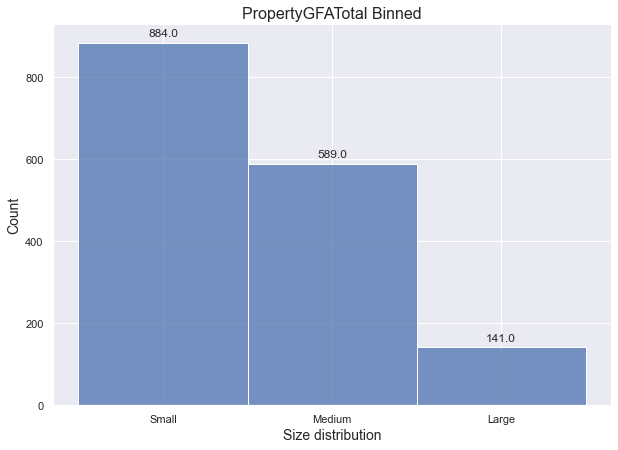

In [153]:
fig, ax1 = plt.subplots(figsize=(10, 7))
plot = sns.histplot(data=df_imputed, x="PropertyGFATotal-binned", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.title("PropertyGFATotal Binned", size=16)
plt.xlabel("Size distribution", size=14)
plt.ylabel("Count", size=14)
plt.savefig("img/PropertyGFATotal-binned.png")
sns.despine(fig)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">9. Exploratory Data Analysis II</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.1. Initial analysis</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">9.1.1 Primary Property type distribution</h4>
</div>

In [154]:
data_piechart = df_imputed["renamed_PropertyType"].sort_values(ascending=False).value_counts().values
labels_piechart = df_imputed["renamed_PropertyType"].sort_values(ascending=False).value_counts().index.tolist()
textprops = dict(size=16, color="gray")
colors = ["#5975A4", "#CC8963", "#5F9E6E", "#AD5B5E", "#857AAB", "#7D6D5F", "#D095BF", "#C1B37F"]
explode = (0, 0, 0, 0, 0, 0, 0, 0)

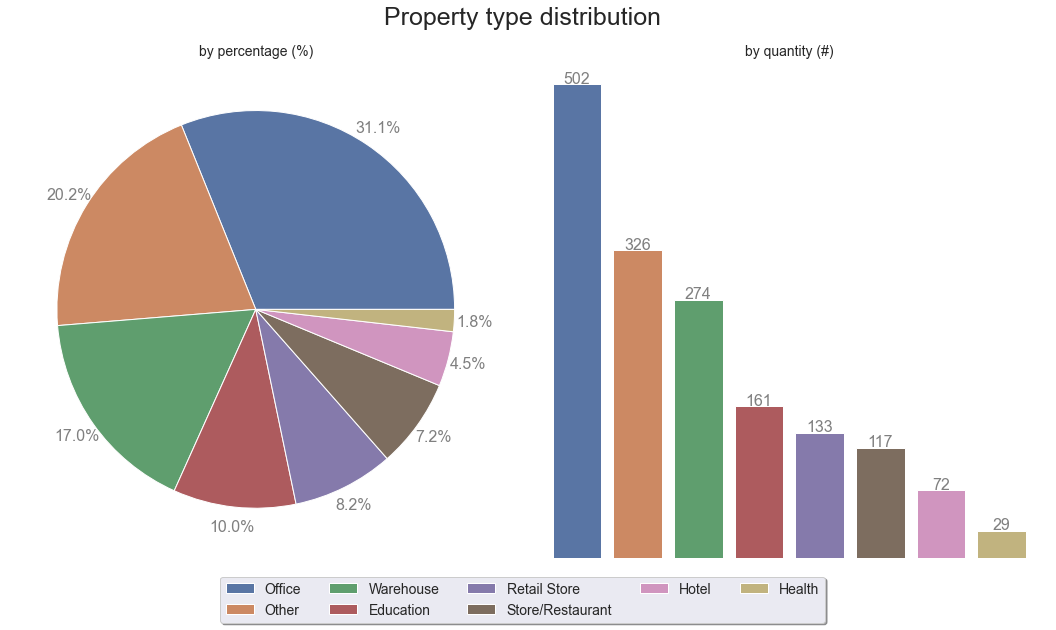

In [155]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15,8])

fig.suptitle("Property type distribution", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors):
    ax2.bar(lb, data, label=lb, color=color)
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=1.10, 
        textprops=textprops, colors=[color for color in colors], startangle=0)
ax1.set_title("by percentage (%)", fontsize=14)

fig.legend(labels_piechart, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/property-type-distribution.png")
plt.show()

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">9.1.2  Comparison of the targets variables in each Property type</h4>
</div>

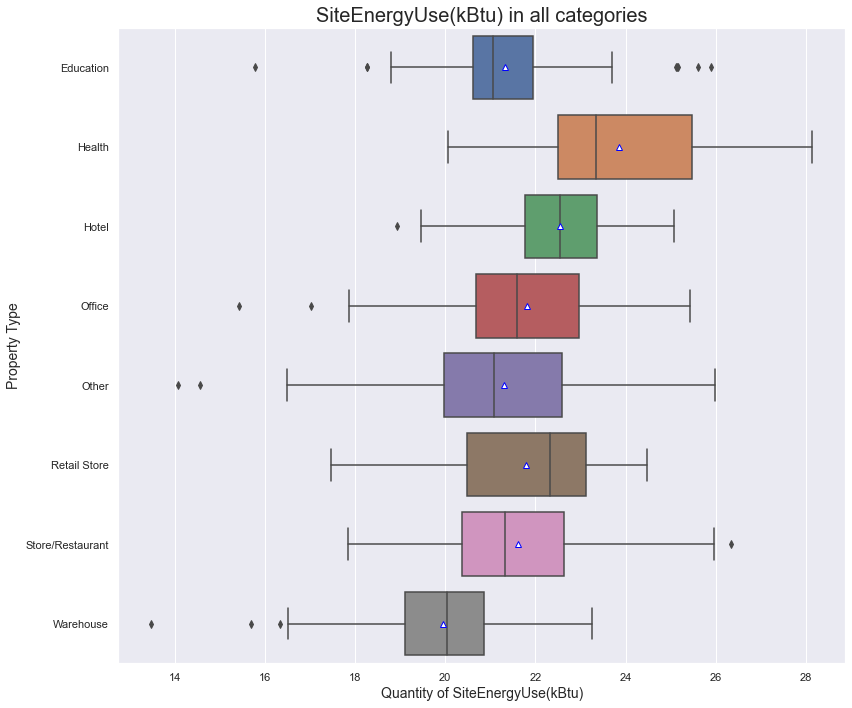

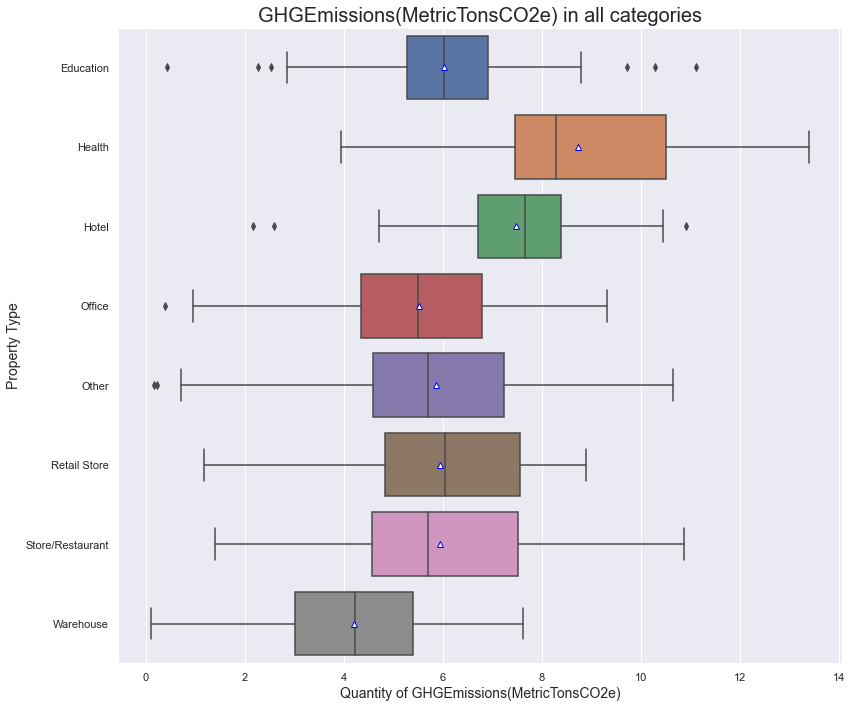

In [156]:
for var in TARGET_VARIABLES:
    if var != "ENERGYSTARScore":
        plt.figure(figsize=[12,10])
        sns.boxplot(x=df_imputed[var], y=df_imputed["renamed_PropertyType"], orient="h", showmeans=True, 
                    meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        plt.title(var + " in all categories", size=20)
        plt.ylabel("Property Type", size=14)
        plt.xlabel("Quantity of " + var, size=14)
        plt.tight_layout()
        plt.savefig("img/comparison-of-" + var + "-in-each-category.png")
        plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br/><br/>
    Building related to <b>Health</b> have a high <b>SiteEnergyUse(kBtu)</b> and <b>GHGEmissions(MetricTonsCO2e)</b>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.2. Univariate analysis</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">9.2.1. UA for Categorical Variables</h4>
</div>

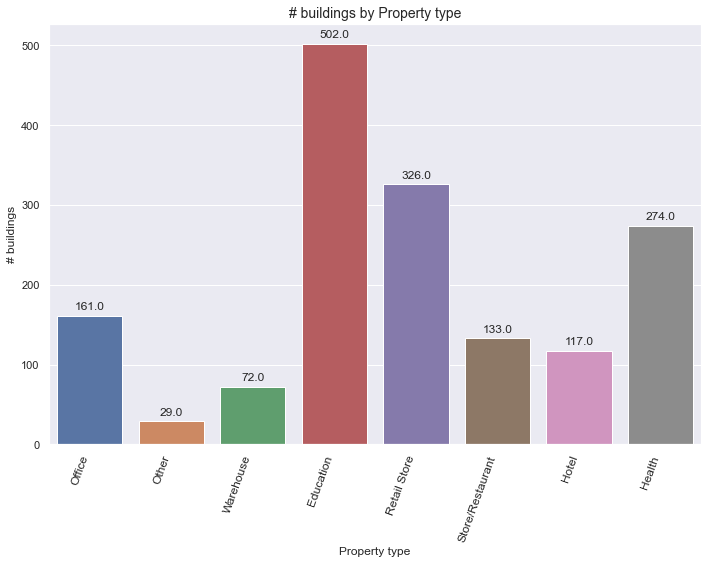

In [157]:
fig = plt.subplots(figsize=(10, 8))
plot = sns.barplot(x=df_imputed["renamed_PropertyType"].value_counts().index, y=df_imputed["renamed_PropertyType"].value_counts(), data=df_imputed)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Property type", size=12)
plt.ylabel("# buildings", size=12)
plt.title("# buildings by Property type", size=14)
plot.set_xticklabels(labels=df_imputed["renamed_PropertyType"].value_counts().index, rotation=70, size=12, horizontalalignment="right")
plt.tight_layout()
plt.savefig("img/buildings-by-property-type.png")
plt.show()

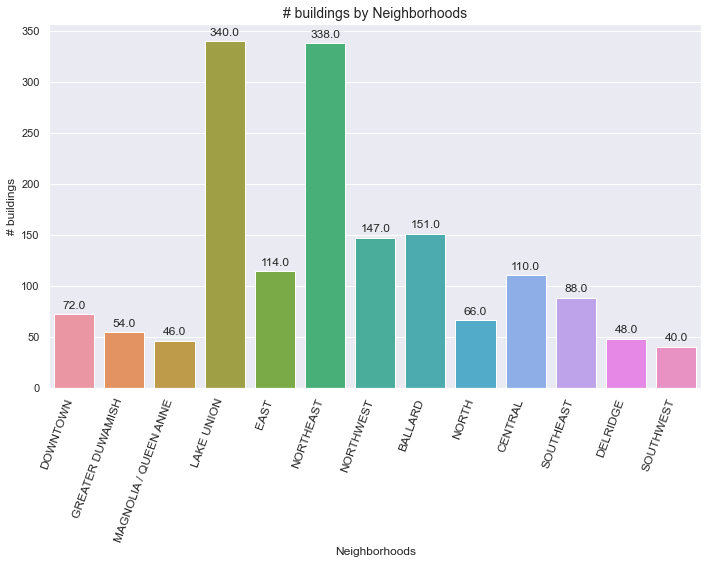

In [158]:
fig = plt.subplots(figsize=(10, 8))
plot = sns.barplot(x=df_imputed["Neighborhood"].value_counts().index, y=df_imputed["Neighborhood"].value_counts(), data=df_imputed)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Neighborhoods", size=12)
plt.ylabel("# buildings", size=12)
plt.title("# buildings by Neighborhoods", size=14)
plot.set_xticklabels(labels=df_imputed["Neighborhood"].value_counts().index, rotation=70, size=12, horizontalalignment="right")
plt.tight_layout()
plt.savefig("img/buildings-by-neighborhoods.png")
plt.show()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.3. Bivariate analysis</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">9.3.1. Pearson correlation</h4>
</div>

In [159]:
FEATURES = [
    "PropertyGFATotal", "BuildingAge", "NumberofFloors", "NumberofBuildings", "Electricity_ratio"
]

In [160]:
TARGETS = [
    "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"
]

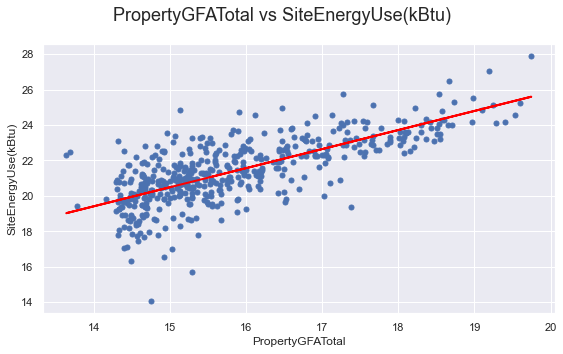

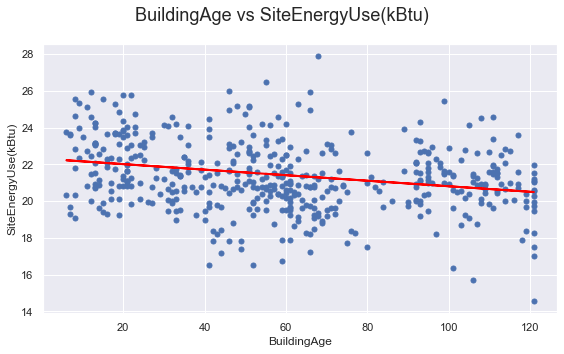

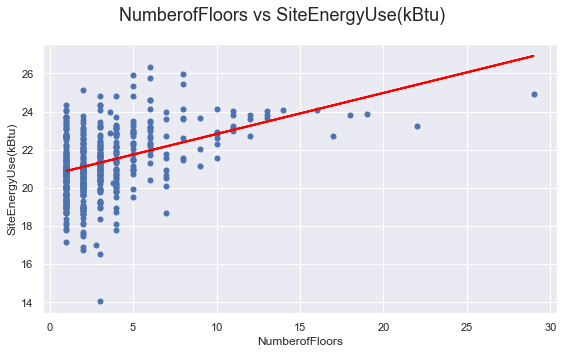

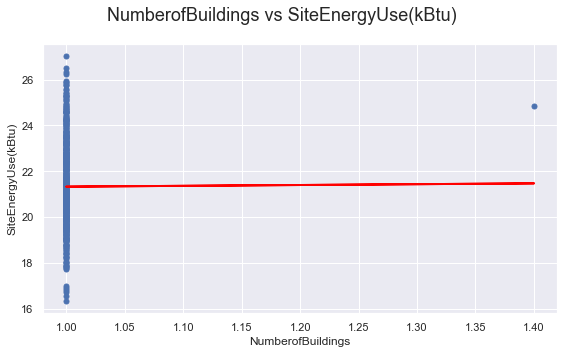

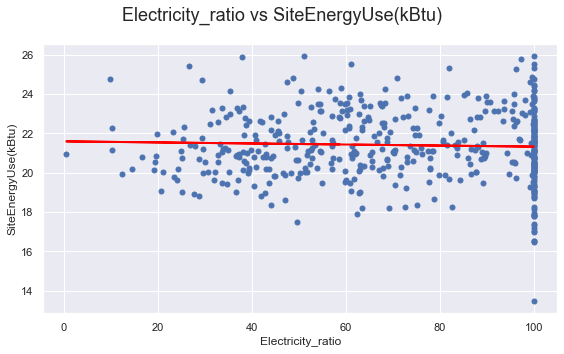

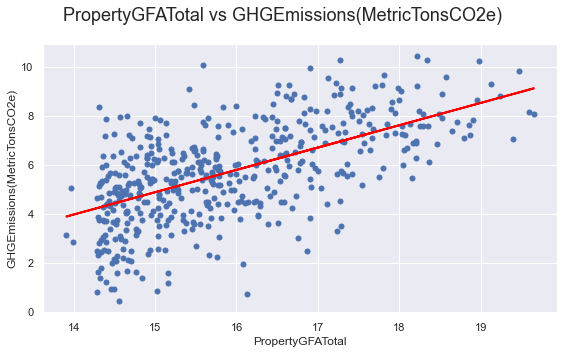

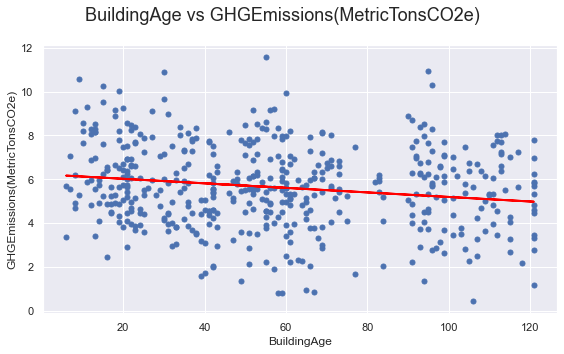

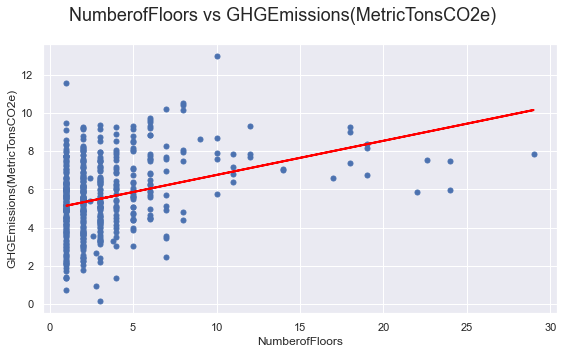

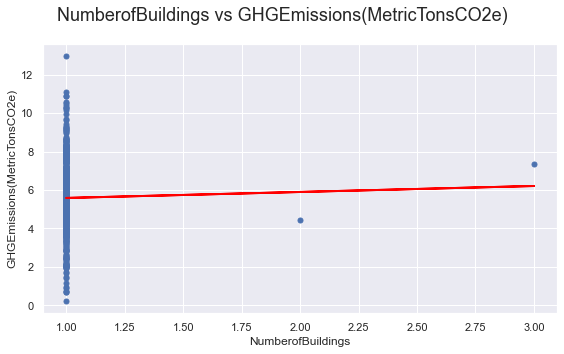

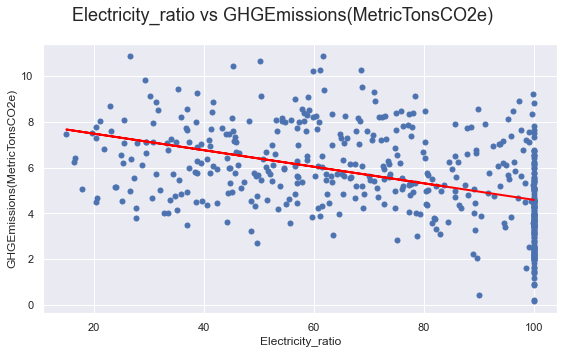

In [161]:
list_variables, list_COEF, list_MSE, list_RMSE, list_R2SCORE = ([] for i in range(5))

for target in TARGETS:
    
    for feature in FEATURES:
    
        # initializing Linear Regression by Pearson
        lr = LinearRegression()
        xtrain, xtest, ytrain, ytest = train_test_split(df_imputed[[feature]], df_imputed[[target]], test_size=0.3)
        lr = LinearRegression()
        lr_baseline = lr.fit(xtrain, ytrain)
        pred_baseline = lr_baseline.predict(xtest)

        list_variables.append(feature + " vs " + target)
        list_COEF.append(round(lr_baseline.coef_[0,0], 4))
        list_MSE.append(round(mean_squared_error(ytest, pred_baseline), 2))
        list_RMSE.append(round(math.sqrt(mean_squared_error(ytest, pred_baseline)), 2))
        list_R2SCORE.append(round(r2_score(ytest, pred_baseline), 2))

        # PLotting the graph
        plt.figure(figsize=(8,5))
        ax = plt.gca()

        plt.suptitle(feature + " vs " + target, fontsize=18)
        plt.plot(xtest, ytest, 'bo', markersize = 5)
        plt.plot(xtest, pred_baseline, color="red", linewidth = 2)
        plt.xlabel(feature, size=12)
        plt.ylabel(target, size=12)
        plt.tight_layout()
        plt.savefig("img/correlation-" + feature + "-vs-" + target + ".png")
        plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    
    <p>Here, we got that the dataset is <b>Non-linear Dataset</b> based on the relation among some features and target variables</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.4. Multivariate Analysis</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">9.4.1. Correlation Matrix</h4>
</div>

<div class="alert alert-block alert-info">
    We are going to make the Correlation matrix for numeric features
</div>

In [162]:
FEATURES_IN_MATRIX_CORR = [
    "NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "BuildingAge",
    "Electricity_ratio", "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"
]
RENAME_COLS = {
    "NumberofBuildings":"# buildings", "NumberofFloors":"# floors", "PropertyGFATotal":"GFA Total", 
     "BuildingAge":"Age", "Electricity_ratio":"Elec. ratio", "SiteEnergyUse(kBtu)":"Energy Use", "GHGEmissions(MetricTonsCO2e)":"CO2"
}

In [163]:
df_temp = pd.DataFrame(df_imputed[FEATURES_IN_MATRIX_CORR]).copy()
df_temp.rename(columns=RENAME_COLS, inplace=True)

In [164]:
df_correlation_matrix = pd.DataFrame(df_temp.corr()).round(2)

In [165]:
mask = np.zeros_like(df_correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True 

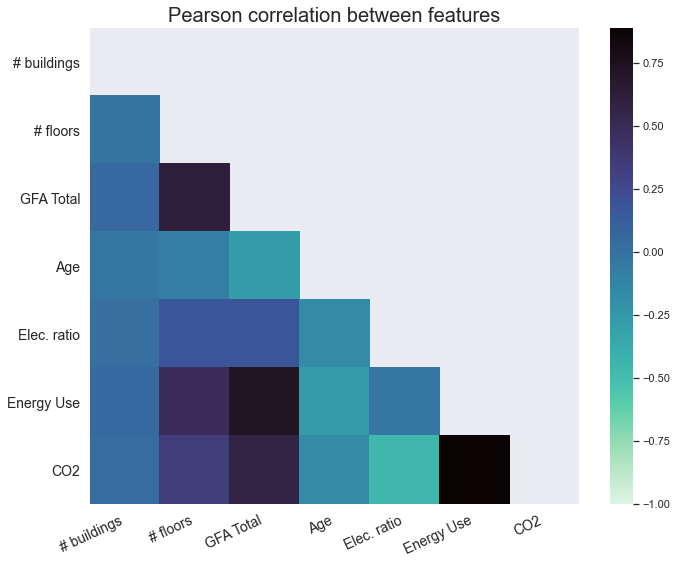

In [166]:
plt.figure(figsize=(10,8))
plt.title("Pearson correlation between features", size=20)

ax = sns.heatmap(df_correlation_matrix, mask=mask, vmin=-1, cmap="mako_r")

plt.xticks(rotation=25, size=14, horizontalalignment="right")
plt.yticks(rotation=0, size=14)
plt.tight_layout()
plt.savefig("img/pearson-correlation-between-features.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    
        <ul style="list-style-type: square;">
            <li>There are some correlation among <b>GFA Total</b> and <b># floors</b> and <b>Target feautres</b></li>
        </ul>               
</div>

In [167]:
print("Pearson correlation")
print("---------------------------------------------")

for threshold in [ 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    
    features_correlated = df_correlation_matrix[((np.abs(df_correlation_matrix) > threshold) & (np.abs(df_correlation_matrix) < 1)).any(1)].index
    
    print("- Threshold  of: " + str(threshold))
    print("  · Numbers of features with correlatin in the threshold: "  + "{}".format(str(len(features_correlated))))
    
    flag = True
    count = 0

    for val in list(features_correlated):
        
        if count == len(features_correlated) - 1:
            print(val)
        elif flag:
            print("   ", val, end=", ")
            flag = False
        else:
            print(val, end=", ")
            
        count += 1
    print("\n")

Pearson correlation
---------------------------------------------
- Threshold  of: 0.3
  · Numbers of features with correlatin in the threshold: 5
    # floors, GFA Total, Elec. ratio, Energy Use, CO2


- Threshold  of: 0.4
  · Numbers of features with correlatin in the threshold: 5
    # floors, GFA Total, Elec. ratio, Energy Use, CO2


- Threshold  of: 0.5
  · Numbers of features with correlatin in the threshold: 4
    # floors, GFA Total, Energy Use, CO2


- Threshold  of: 0.6
  · Numbers of features with correlatin in the threshold: 4
    # floors, GFA Total, Energy Use, CO2


- Threshold  of: 0.7
  · Numbers of features with correlatin in the threshold: 3
    GFA Total, Energy Use, CO2


- Threshold  of: 0.8
  · Numbers of features with correlatin in the threshold: 2
    Energy Use, CO2


- Threshold  of: 0.9
  · Numbers of features with correlatin in the threshold: 0




<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.5. Principal component analysis - PCA</h3>
</div>

In [168]:
df_analysis(df_imputed, "df_imputed")


Analysis of df_imputed dataset
--------------------------------------------------------------------
- Dataset shape:                  1614 rows and 15 columns
- Total of NaN values:            524
- Percentage of NaN:              2.16 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 124.2 KB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,float64,1614,0,0.00000
1,BuildingAge,float64,1614,0,0.00000
2,NumberofFloors,float64,1614,0,0.00000
3,NumberofBuildings,float64,1614,0,0.00000
4,PropertyGFATotal,float64,1614,0,0.00000
5,Electricity_ratio,float64,1614,0,0.00000
6,NaturalGas,bool,1614,0,0.00000
7,SteamUse,bool,1614,0,0.00000
8,OtherFuelUse,bool,1614,0,0.00000
9,SiteEnergyUse(kBtu),float64,1614,0,0.00000


<div class="alert alert-block alert-info">
    We are <b>not</b> going to <b>consider</b> the following features
    <ul style="list-style-type: square;">
        <li><b>OSEBuildingID:</b> Not interesting for the mission</li>
        <li><b>SiteEnergyUse(kBtu): </b> Features target</li>
        <li><b>SiteEnergyUse(kBtu)_log2: </b>Transformed features target</li>
        <li><b>GHGEmissions(MetricTonsCO2e): </b> Features target</li>
        <li><b>GHGEmissions(MetricTonsCO2e)_log2: </b> Transformed features target</li>
        <li><b>ENERGYSTARScore: </b>Other features</li>
    </ul>  
</div>

<div class="alert alert-block alert-info">
    <b>Encoding</b> through <b>LabelEncoder</b> the booleans features
</div>

In [169]:
le = LabelEncoder()

In [170]:
df_le = df_imputed[["Neighborhood", "renamed_PropertyType", "PropertyGFATotal-binned"]].copy().apply(le.fit_transform)

In [171]:
df_le.head(5)

,Neighborhood,renamed_PropertyType,PropertyGFATotal-binned
0,3,2,1
1,3,2,1
2,3,2,1
3,3,2,1
4,3,2,1


<div class="alert alert-block alert-info">
    <b>The numeric</b> features <br>
</div>

In [172]:
df_numeric_features = df_imputed.loc[:, ["NumberofFloors", "NumberofBuildings", "PropertyGFATotal", "BuildingAge", "Electricity_ratio"]]

<div class="alert alert-block alert-info">
    <b>The boolean</b> features <br>
</div>

In [173]:
df_boolean_features = df_imputed.loc[:, ["NaturalGas", "SteamUse", "OtherFuelUse"]]

<div class="alert alert-block alert-info">
    <b>Concatenating</b> dataframes to <b>Normalize</b>
</div>

In [174]:
df_subset = pd.concat([df_numeric_features, df_boolean_features, df_le], axis=1)

In [175]:
df_subset.head()

,NumberofFloors,NumberofBuildings,PropertyGFATotal,BuildingAge,Electricity_ratio,NaturalGas,SteamUse,OtherFuelUse,Neighborhood,renamed_PropertyType,PropertyGFATotal-binned
0,12.0,1.0,16.432330,94.0,52.79951,True,True,False,3,2,1
1,11.0,1.0,16.660205,25.0,46.74768,True,False,False,3,2,1
2,10.0,1.0,15.904094,95.0,9.80903,True,True,False,3,2,1
3,18.0,1.0,17.421777,41.0,40.90771,True,False,False,3,2,1
4,11.0,1.0,16.340980,95.0,42.85568,True,False,False,3,2,1


<div class="alert alert-block alert-info">
    <b>Normalizing</b> the features <br>
    None of the numerical variables follow a normal distribution, so we will use StandardScaler
    
</div>

In [176]:
scaler = StandardScaler()

In [177]:
scaler_features = scaler.fit_transform(df_subset)

In [178]:
df_scaler = pd.DataFrame(scaler_features, index=df_subset.index, columns=df_subset.columns)
df_scaler.head(5)

,NumberofFloors,NumberofBuildings,PropertyGFATotal,BuildingAge,Electricity_ratio,NaturalGas,SteamUse,OtherFuelUse,Neighborhood,renamed_PropertyType,PropertyGFATotal-binned
0,2.156739,-0.040177,0.477717,1.055178,-0.705521,0.631358,3.954640,-0.196494,-0.822438,-0.926383,-0.707683
1,1.902390,-0.040177,0.660906,-1.051999,-0.940974,0.631358,-0.252868,-0.196494,-0.822438,-0.926383,-0.707683
2,1.648040,-0.040177,0.053066,1.085717,-2.378116,0.631358,3.954640,-0.196494,-0.822438,-0.926383,-0.707683
3,3.682836,-0.040177,1.273137,-0.563378,-1.168185,0.631358,-0.252868,-0.196494,-0.822438,-0.926383,-0.707683
4,1.902390,-0.040177,0.404281,1.085717,-1.092397,0.631358,-0.252868,-0.196494,-0.822438,-0.926383,-0.707683


<div class="alert alert-block alert-info">
   Numbers of components to calculate to PCA            
</div>

In [179]:
n_comp = 9

<div class="alert alert-block alert-info">
    Selecting the features to analyse with PCA
</div>

In [180]:
X = df_scaler.values
index_values = df_scaler.index
features = df_scaler.columns

<div class="alert alert-block alert-info">
   Principal components determination      
</div>

In [181]:
pca = PCA(n_components=n_comp).fit(X)

In [182]:
df_pca = pd.DataFrame(pca.components_, 
                      index=["PC" + str(i+1) for i in range(n_comp)],
                      columns=features ).T

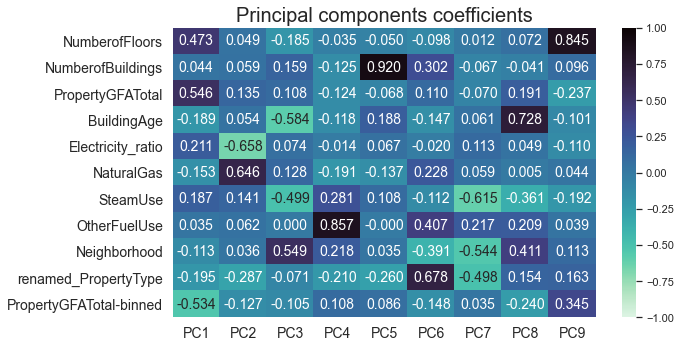

In [183]:
plt.figure(figsize=(10,5))
plt.title("Principal components coefficients", size=20)

ax = sns.heatmap(df_pca, vmin=-1, vmax=1, center=0, cmap="mako_r",
                annot=True, annot_kws={"size": 14}, fmt=".3f")

plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()
plt.savefig("img/principal-components-coefficients.png")
plt.show()

<div class="alert alert-block alert-info">
    Plotting the <b>Scree of eigenvalues</b>
</div>

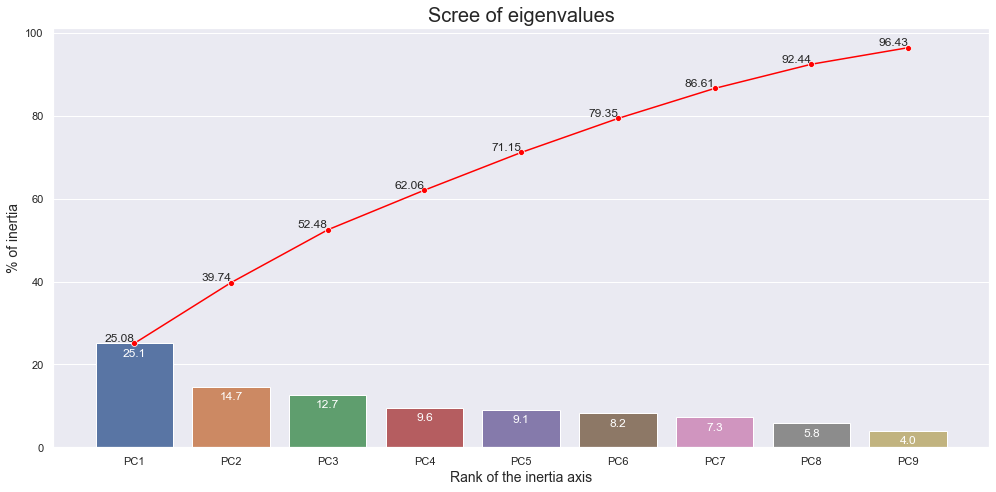

In [184]:
scree = pca.explained_variance_ratio_*100

fig = plt.subplots(figsize=(14, 7))
plot_bar = sns.barplot(x=df_pca.columns, y=scree)
for p in plot_bar.patches:
    plot_bar.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="bottom", xytext=(0, -15), textcoords="offset points", color="white")
plot_line = sns.lineplot(x=df_pca.columns, y=scree.cumsum(), marker="o", color="red")

for x, y in zip(df_pca.columns, scree.cumsum()):
    plot_line.text(x, y, "{:.2f}".format(y), ha="right", va="bottom")

plt.xlabel("Rank of the inertia axis", size=14)
plt.ylabel("% of inertia", size=14)
plt.title("Scree of eigenvalues", size=20)
plt.tight_layout()
plt.savefig("img/scree-of-eigenvalues.png")
plt.show()

<div class="alert alert-block alert-info">
    Plotting the <b>Correlation Circle</b>
</div>

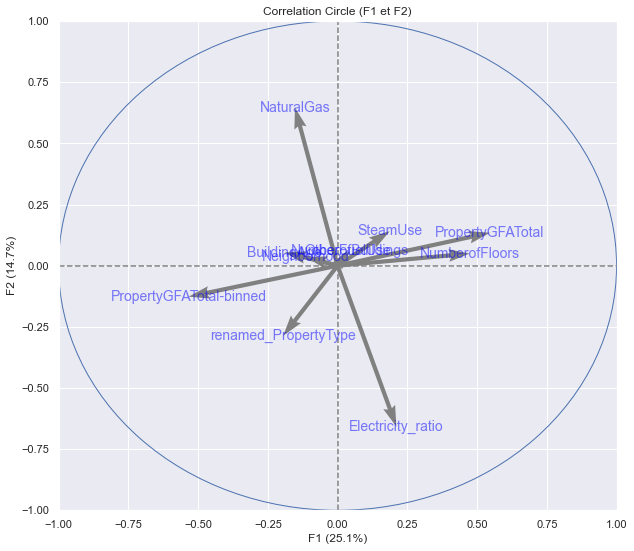

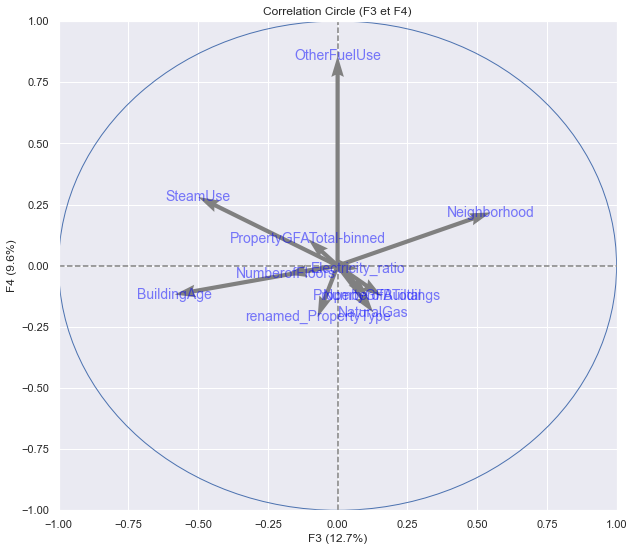

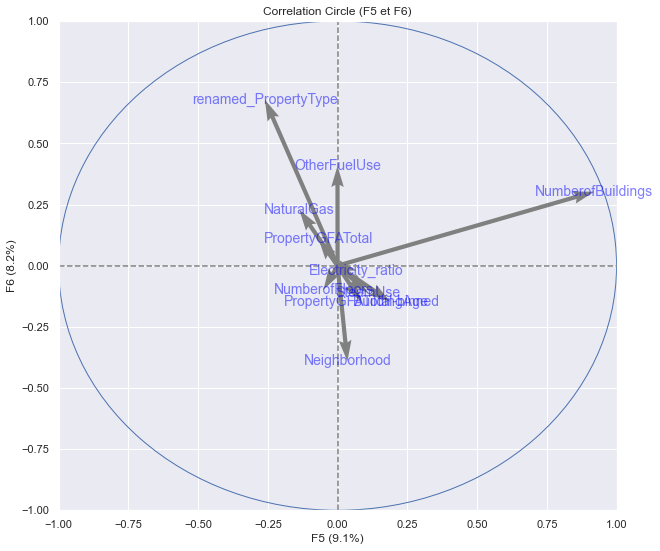

In [185]:
display_circles(pca.components_, n_comp, pca, [(0,1),(2,3),(4,5)], labels=np.array(features))

<div class="alert alert-block alert-info">
    Plotting the <b>Projection of individuals</b>
</div>

In [186]:
X_projected = pca.transform(X)
index_values_sample = pd.Series(index_values).sample(100)

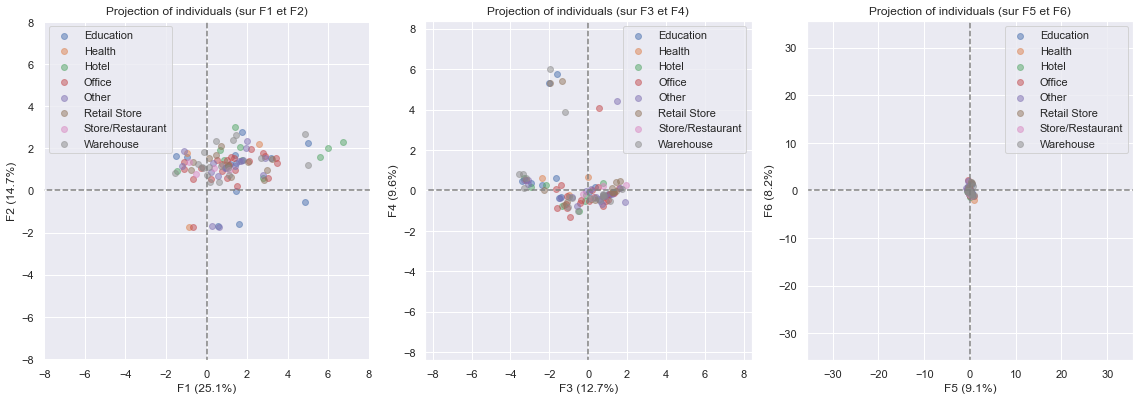

In [187]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], 
                         labels=np.array(index_values_sample), illus_var=df_bebcs.loc[index_values_sample, "renamed_PropertyType"], 
                         lab_on=False, alpha = 0.5)

<div class="alert alert-block alert-info">
    Keeping the <b>90% of the variance of the components</b>
</div>

In [188]:
var_threshold=0.90

# Processing the PCA
pca = decomposition.PCA()
pca.fit(X)

# Getting the explained variance ratio for each principal component
scree = pca.explained_variance_ratio_

# Getting the number of principal components to reach variance thresholds
mask = scree.cumsum() > var_threshold
nb_selected_components = len(scree[~mask]) + 1
print("Number of selected components:", nb_selected_components)

# Compute and displays the actual ratio of explained variance
explained_variance_sum = scree.cumsum()[nb_selected_components-1]
print("Cumulative explained variance:  {:.2f}%".format(explained_variance_sum*100))

# Getting the projection of the data on the first components
X_PCA = pca.transform(X)[:,:nb_selected_components]

Number of selected components: 8
Cumulative explained variance:  92.44%


In [189]:
COL_TO_PC =  ["PC" + str(i + 1) for i in range(nb_selected_components)]

In [190]:
df_worked = pd.DataFrame(data=X_PCA, columns=COL_TO_PC, index=index_values)

In [191]:
df_worked.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,2.219189,1.968990,-3.224799,0.514252,0.466900,-0.891532,-1.575095,-0.796569
1,1.761093,1.428240,0.154642,-0.427552,-0.401691,-0.062767,0.841791,-0.804658
2,1.388044,2.989048,-3.317794,0.603832,0.414441,-0.860050,-1.738531,-0.974545
3,2.797948,1.774751,-0.410030,-0.620678,-0.456326,-0.237572,0.824223,-0.214634
4,1.184820,1.609804,-1.132326,-0.646658,0.008407,-0.402223,0.973678,0.695133


<div class="alert alert-block alert-info">
    <b>Concatenating</b> the final dataset
</div>

In [192]:
df_subset = pd.concat([df_worked, df_imputed.loc[:, ["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"]]], axis=1)

In [193]:
df_subset.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
0,2.219189,1.968990,-3.224799,0.514252,0.466900,-0.891532,-1.575095,-0.796569,22.735091,7.968264
1,1.761093,1.428240,0.154642,-0.427552,-0.401691,-0.062767,0.841791,-0.804658,22.994076,8.047178
2,1.388044,2.989048,-3.317794,0.603832,0.414441,-0.860050,-1.738531,-0.974545,24.750691,10.919861
3,2.797948,1.774751,-0.410030,-0.620678,-0.456326,-0.237572,0.824223,-0.214634,23.821928,8.990671
4,1.184820,1.609804,-1.132326,-0.646658,0.008407,-0.402223,0.973678,0.695133,22.576081,7.710531


In [194]:
df_subset.shape

(1614, 10)

In [195]:
df_subset.to_csv("datasets\df_PCA.csv", index=False)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">10. Features to work in the prediction models</h2>
</div>

<div class="alert alert-block alert-info">
    We are going to work with features without transformation and missing-values imputed
</div>

In [196]:
df_bebcs_without_transformation = df_bebcs_without_transformation[[
    "NumberofFloors", "NumberofBuildings", "BuildingAge", "PropertyGFATotal", "Neighborhood", 
    "renamed_PropertyType", "Electricity_ratio", "NaturalGas", "SteamUse", "OtherFuelUse",
    "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"
]]

In [197]:
df_bebcs_without_transformation.head()

,NumberofFloors,NumberofBuildings,BuildingAge,PropertyGFATotal,Neighborhood,renamed_PropertyType,Electricity_ratio,NaturalGas,SteamUse,OtherFuelUse,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
0,12.0,1.0,94.0,88434.0,DOWNTOWN,Hotel,52.79951,True,True,False,6981428.0,249.43
1,11.0,1.0,25.0,103566.0,DOWNTOWN,Hotel,46.74768,True,False,False,8354235.0,263.51
2,10.0,1.0,95.0,61320.0,DOWNTOWN,Hotel,9.80903,True,True,False,28229320.0,1936.34
3,18.0,1.0,41.0,175580.0,DOWNTOWN,Hotel,40.90771,True,False,False,14829099.0,507.70
4,11.0,1.0,95.0,83008.0,DOWNTOWN,Hotel,42.85568,True,False,False,6252842.0,208.46


In [198]:
df_bebcs_without_transformation = pd.concat([df_bebcs_without_transformation, df_imputed[["PropertyGFATotal-binned"]]], axis=1)

In [199]:
df_bebcs_without_transformation = df_bebcs_without_transformation[[
    "NumberofFloors", "NumberofBuildings", "BuildingAge", "PropertyGFATotal", "PropertyGFATotal-binned",
    "Neighborhood", "renamed_PropertyType", "Electricity_ratio", "NaturalGas", "SteamUse", "OtherFuelUse",
    "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"
]]

In [200]:
df_bebcs_without_transformation.head()

,NumberofFloors,NumberofBuildings,BuildingAge,PropertyGFATotal,PropertyGFATotal-binned,Neighborhood,renamed_PropertyType,Electricity_ratio,NaturalGas,SteamUse,OtherFuelUse,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
0,12.0,1.0,94.0,88434.0,Medium,DOWNTOWN,Hotel,52.79951,True,True,False,6981428.0,249.43
1,11.0,1.0,25.0,103566.0,Medium,DOWNTOWN,Hotel,46.74768,True,False,False,8354235.0,263.51
2,10.0,1.0,95.0,61320.0,Medium,DOWNTOWN,Hotel,9.80903,True,True,False,28229320.0,1936.34
3,18.0,1.0,41.0,175580.0,Medium,DOWNTOWN,Hotel,40.90771,True,False,False,14829099.0,507.70
4,11.0,1.0,95.0,83008.0,Medium,DOWNTOWN,Hotel,42.85568,True,False,False,6252842.0,208.46


In [201]:
df_analysis(df_bebcs_without_transformation, "df_bebcs_without_transformation", type_analysis="complete")


Analysis of df_bebcs_without_transformation dataset
--------------------------------------------------------------------
- Dataset shape:                  1614 rows and 13 columns
- Total of NaN values:            48
- Percentage of NaN:              0.23 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 99.0 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
2,BuildingAge,float64,1614,113,0,0.00000,59.44796,6.00000,32.00000,56.00000,91.00000,121.00000,32.75537
4,PropertyGFATotal-binned,category,1614,3,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Neighborhood,category,1614,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,renamed_PropertyType,category,1614,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaturalGas,bool,1614,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,SteamUse,bool,1614,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,OtherFuelUse,bool,1614,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,SiteEnergyUse(kBtu),float64,1614,1613,0,0.00000,6301646.01963,11441.00000,1188142.75000,2397995.50000,6499306.00000,295812640.00000,13693695.87053
12,GHGEmissions(MetricTonsCO2e),float64,1614,1541,0,0.00000,134.64926,0.08000,19.08000,47.22000,131.02750,10780.64000,422.52765
1,NumberofBuildings,float64,1610,5,4,0.25000,1.01118,1.00000,1.00000,1.00000,1.00000,11.00000,0.28403


In [202]:
df_bebcs_without_transformation.to_csv("datasets\df_to_work.csv", index=False)